In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import json
import ast
from matplotlib.ticker import FuncFormatter
import glob
from matplotlib import animation
from scipy.spatial.distance import pdist, squareform
from itertools import combinations
import scipy
from scipy.stats import entropy
from sklearn import manifold
from adjustText import adjust_text
from mpl_toolkits import mplot3d
import networkx as nx
import os.path as osp
from sklearn import tree
import graphviz
from sklearn.metrics import classification_report
from itertools import product


In [2]:
#plt.style.use('seaborn-white')
plt.style.use('seaborn')
# for matplotlib xkcd I need to install new font without root, like this: 
#https://community.linuxmint.com/tutorial/view/29
# and then ivalidate cache like this: 
#https://stackoverflow.com/questions/19663986/getting-xkcd-plots-using-matplotlib/22812176#22812176
# or by deleting by: rm ~/.cache/matplotlib -r
# the font ttf file must be in ~/.fonts/fonts/truetype/humor-sans directory

# to recover from xkcd
#mpl.rcParams.update(saved_state)

# to save state and go to xkcd
#saved_state = mpl.rcParams.copy()
#plt.xkcd()


In [3]:
# cleaned data are good for user anylysis but not for anime analysis. For users, around 200k animelist records were discarded, over 30m records remainded.
animes = pd.read_csv('anime_cleaned.csv')
users = pd.read_csv('users_cleaned.csv')
animelists = pd.read_csv('animelists_cleaned.csv')

In [4]:
users['birth_date'] = pd.to_datetime(users['birth_date'])
users['last_online'] = pd.to_datetime(users['last_online'])
users['join_date'] = pd.to_datetime(users['join_date'])
animelists['my_last_updated'] = pd.to_datetime(animelists['my_last_updated'])
# renaming possibly array-like columns to end with -s
animes = animes.rename(columns={'genre': 'genres', 'studio': 'studios'})

In [5]:
# setting index for primary identifiers
animes = animes.set_index('anime_id')
users = users.set_index('username')


In [6]:
users['age'] = 2018 - users['birth_date'].dt.year

In [7]:
animes.head()

title              title_english title_japanese  \
anime_id                                                                  
11013           Inu x Boku SS  Inu X Boku Secret Service         妖狐×僕SS   
2104         Seto no Hanayome      My Bride is a Mermaid          瀬戸の花嫁   
5262       Shugo Chara!! Doki         Shugo Chara!! Doki    しゅごキャラ！！どきっ   
721             Princess Tutu              Princess Tutu      プリンセスチュチュ   
12365     Bakuman. 3rd Season                   Bakuman.          バクマン。   

                                         title_synonyms  \
anime_id                                                  
11013                                   Youko x Boku SS   
2104                               The Inland Sea Bride   
5262      Shugo Chara Ninenme, Shugo Chara! Second Year   
721                                                 NaN   
12365                                  Bakuman Season 3   

                                                  image_url type    source  \
anime_id                                                                     
11013     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
2104      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
5262      https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   
721       https://myanimelist.cdn-dena.com/images/anime/...   TV  Original   
12365     https://myanimelist.cdn-dena.com/images/anime/...   TV     Manga   

          episodes           status  airing       ...         \
anime_id                                          ...          
11013           12  Finished Airing   False       ...          
2104            26  Finished Airing   False       ...          
5262            51  Finished Airing   False       ...          
721             38  Finished Airing   False       ...          
12365           25  Finished Airing   False       ...          

                   broadcast  \
anime_id                       
11013     Fridays at Unknown   
2104                 Unknown   
5262                 Unknown   
721       Fridays at Unknown   
12365                Unknown   

                                                    related  \
anime_id                                                      
11013     {'Adaptation': [{'mal_id': 17207, 'type': 'man...   
2104      {'Adaptation': [{'mal_id': 759, 'type': 'manga...   
5262      {'Adaptation': [{'mal_id': 101, 'type': 'manga...   
721       {'Adaptation': [{'mal_id': 1581, 'type': 'mang...   
12365     {'Adaptation': [{'mal_id': 9711, 'type': 'mang...   

                                                   producer          licensor  \
anime_id                                                                        
11013     Aniplex, Square Enix, Mainichi Broadcasting Sy...  Sentai Filmworks   
2104                      TV Tokyo, AIC, Square Enix, Sotsu        Funimation   
5262                                        TV Tokyo, Sotsu               NaN   
721                      Memory-Tech, GANSIS, Marvelous AQL         ADV Films   
12365                                         NHK, Shueisha               NaN   

                   studios                                    genres  \
anime_id                                                               
11013     David Production    Comedy, Supernatural, Romance, Shounen   
2104                 Gonzo  Comedy, Parody, Romance, School, Shounen   
5262             Satelight             Comedy, Magic, School, Shoujo   
721         Hal Film Maker    Comedy, Drama, Magic, Romance, Fantasy   
12365            J.C.Staff           Comedy, Drama, Romance, Shounen   

                                              opening_theme  \
anime_id                                                      
11013                                 ['"Nirvana" by MUCC']   
2104                     ['"Romantic summer" by SUN&LUNAR']   
5262      ['#1: "Minna no Tamago (みんなのたまご)" by Shugo Cha...   
721                  ['"Morning G

In [8]:
animelists.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        59                   26    0000-00-00     0000-00-00   
2  karthiga        74                   26    0000-00-00     0000-00-00   
3  karthiga       120                   26    0000-00-00     0000-00-00   
4  karthiga       178                   26    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         7          2            NaN                 0 2013-03-10 13:54:51   
2         7          2            NaN                 0 2013-04-27 16:43:35   
3         7          2            NaN                 0 2013-03-03 10:53:57   
4         7          2            0.0                 0 2013-03-27 15:59:13   

  my_tags  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [9]:
users.head()

user_id  user_watching  user_completed  user_onhold  \
username                                                              
karthiga        2255153              3              49            1   
Damonashu         37326             45             195           27   
bskai            228342             25             414            2   
terune_uzumaki   327311              5               5            0   
Bas_G           5015094             35             114            6   

                user_dropped  user_plantowatch  user_days_spent_watching  \
username                                                                   
karthiga                   0                 0                 55.091667   
Damonashu                 25                59                 82.574306   
bskai                      5                11                159.483333   
terune_uzumaki             0                 0                 11.394444   
Bas_G                     20               175                 30.458333   

                gender             location birth_date  access_rank  \
username                                                              
karthiga        Female      Chennai, India  1990-04-29          NaN   
Damonashu         Male     Detroit,Michigan 1991-08-01          NaN   
bskai             Male      Nayarit, Mexico 1990-12-14          NaN   
terune_uzumaki  Female    Malaysia, Kuantan 1998-08-24          NaN   
Bas_G             Male  Nijmegen, Nederland 1999-10-24          NaN   

                join_date         last_online  stats_mean_score  \
username                                                          
karthiga       2013-03-03 2014-02-04 01:32:00              7.43   
Damonashu      2008-02-13 2017-07-10 06:52:54              6.15   
bskai          2009-08-31 2014-05-12 16:35:00              8.27   
terune_uzumaki 2010-05-10 2012-10-18 19:06:00              9.70   
Bas_G          2015-11-26 2018-05-10 20:53:37              7.86   

                stats_rewatched  stats_episodes  age  
username                                              
karthiga                    0.0            3391   28  
Damonashu                   6.0            4903   27  
bskai                       1.0            9701   28  
terune_uzumaki              6.0             697   20  
Bas_G                       0.0            1847   19

### comparison of all and active users
Active users are users with some ratings in last 3 months

In [10]:
# newest update date, reflects time of data gathering
now = animelists['my_last_updated'].max()
now

Timestamp('2018-05-22 07:49:06')

In [11]:
from dateutil.relativedelta import relativedelta
last_update = animelists.groupby('username')['my_last_updated'].max()
is_active = last_update > (now - relativedelta(months=3))
active_users = last_update[is_active].index

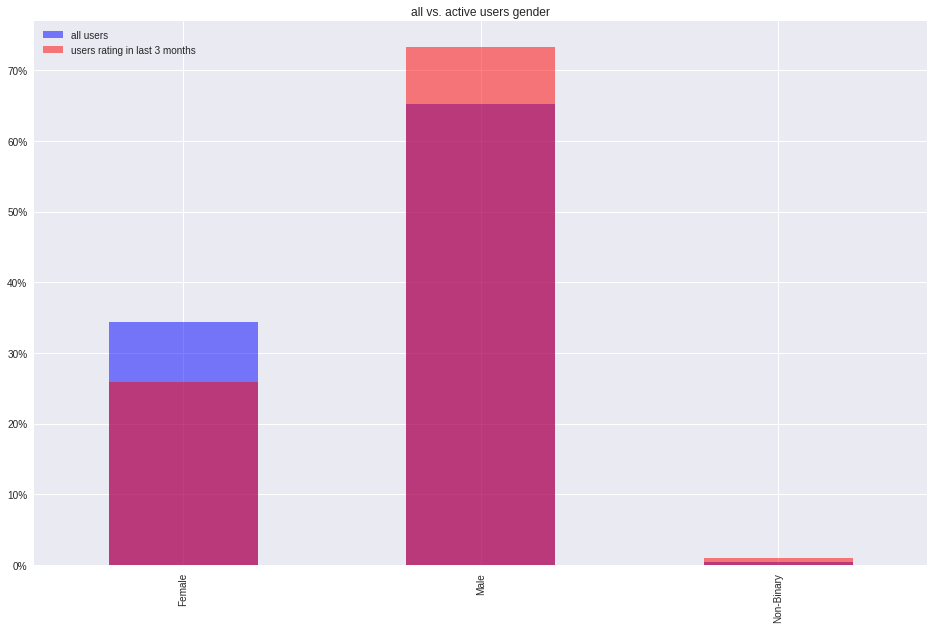

In [12]:
(users['gender'].value_counts() / users['gender'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users gender', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['gender'].value_counts() / users.loc[active_users]['gender'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

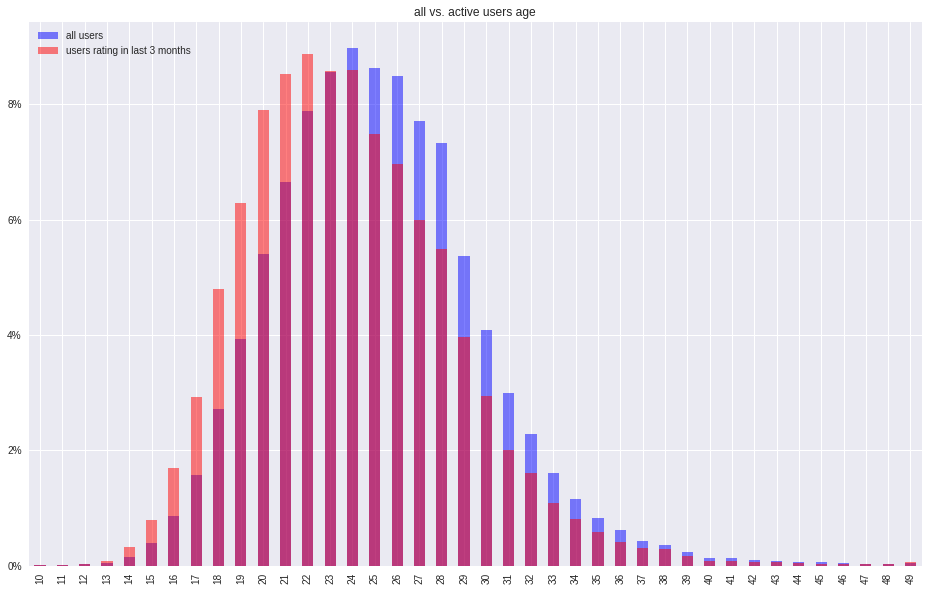

In [13]:
(users['age'].value_counts() / users['age'].count()).sort_index().plot.bar(figsize=(16, 10), title='all vs. active users age', color='blue', alpha=0.5, label='all users')
(users.loc[active_users]['age'].value_counts() / users.loc[active_users]['age'].count()).sort_index().plot.bar(figsize=(16, 10), color='red', alpha=0.5, label='users rating in last 3 months')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.legend(loc=2)

### inspecing seen animes per all genres by age, gender etc.

In [14]:
animes['genres'].fillna('', inplace=True)
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
genres_arr.index.levels[0].name = 'anime_id'
animes_genres = pd.merge(animes, genres_arr, how='left', left_index=True, right_index=True)
genres = genres_arr['genre'].unique()

In [15]:
animelists = animelists.join(animes['genres'], on='anime_id')

### this is just testing of functionality

In [16]:
#animelists.iloc[0:10][['anime_id', 'genres']]
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(x), axis=1)
#animelists.iloc[0:10].apply(lambda x: print(x))
#animelists.apply(lambda x: print(x['genre']))
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(type(x)))
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: print(x[1]), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: x[1].replace(' ', '').split(','), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)
#animelists.iloc[0:10][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1).apply(pd.Series).stack().to_frame(name='genre')

#genres_df = animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
#genres_df.index.levels[0] = animelists.iloc[0:10]['anime_id']
#genres_df

#animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).set_index(animelists.iloc[0:10]['anime_id']).stack().to_frame(name='genre')
lists_genres_pd = animelists.iloc[0:10]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
lists_ids_pd = animelists.iloc[0:10]['anime_id'].to_frame(name='anime_id')
lists_genres_pd.index.levels[0].name = 'anime_id'
lists_ids_pd.index.name = 'anime_id'
pd.merge(lists_genres_pd, lists_ids_pd, how='inner', left_index=True, right_index=True)

genre  anime_id
anime_id                          
0        0        Action        21
         1     Adventure        21
         2        Comedy        21
         3    SuperPower        21
         4         Drama        21
         5       Fantasy        21
         6       Shounen        21
1        0        Sci-Fi        59
         1        Comedy        59
         2         Drama        59
         3       Romance        59
         4         Ecchi        59
         5        Seinen        59
2        0        Comedy        74
         1        School        74
         2        Shoujo        74
         3    SuperPower        74
3        0   SliceofLife       120
         1        Comedy       120
         2         Drama       120
         3       Romance       120
         4       Fantasy       120
         5        Shoujo       120
4        0         Magic       178
         1        Comedy       178
         2       Romance       178
         3        School       178
         4        Shoujo       178
5        0   SliceofLife       210
         1        Comedy       210
         2   MartialArts       210
         3       Fantasy       210
6        0     Adventure       232
         1        Comedy       232
         2         Drama       232
         3         Magic       232
         4       Romance       232
         5       Fantasy       232
         6        School       232
         7        Shoujo       232
7        0        Comedy       233
         1        Sci-Fi       233
         2        Shoujo       233
8        0        Action       249
         1     Adventure       249
         2        Comedy       249
         3    Historical       249
         4        Demons       249
         5  Supernatural       249
         6         Magic       249
         7       Romance       249
         8       Fantasy       249
         9       Shounen       249
9        0        Action       269
         1     Adventure       269
         2        Comedy       269
         3    SuperPower       269
         4  Supernatural       269
         5       Shounen       269

In [17]:
animelists.iloc[0:10][['anime_id', 'genres']]

anime_id                                             genres
0        21  Action, Adventure, Comedy, Super Power, Drama,...
1        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen
2        74                Comedy, School, Shoujo, Super Power
3       120  Slice of Life, Comedy, Drama, Romance, Fantasy...
4       178             Magic, Comedy, Romance, School, Shoujo
5       210       Slice of Life, Comedy, Martial Arts, Fantasy
6       232  Adventure, Comedy, Drama, Magic, Romance, Fant...
7       233                             Comedy, Sci-Fi, Shoujo
8       249  Action, Adventure, Comedy, Historical, Demons,...
9       269  Action, Adventure, Comedy, Super Power, Supern...

### this is test of correctness

In [18]:
animelists.iloc[0:5]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')

genre
0 0       Action
  1    Adventure
  2       Comedy
  3   SuperPower
  4        Drama
  5      Fantasy
  6      Shounen
1 0       Sci-Fi
  1       Comedy
  2        Drama
  3      Romance
  4        Ecchi
  5       Seinen
2 0       Comedy
  1       School
  2       Shoujo
  3   SuperPower
3 0  SliceofLife
  1       Comedy
  2        Drama
  3      Romance
  4      Fantasy
  5       Shoujo
4 0        Magic
  1       Comedy
  2      Romance
  3       School
  4       Shoujo

In [19]:
indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:5][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
pd.Series([y for x in animelists.iloc[0:5]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')


genre
21  0       Action
    1    Adventure
    2       Comedy
    3   SuperPower
    4        Drama
    5      Fantasy
    6      Shounen
59  0       Sci-Fi
    1       Comedy
    2        Drama
    3      Romance
    4        Ecchi
    5       Seinen
74  0       Comedy
    1       School
    2       Shoujo
    3   SuperPower
120 0  SliceofLife
    1       Comedy
    2        Drama
    3      Romance
    4      Fantasy
    5       Shoujo
178 0        Magic
    1       Comedy
    2      Romance
    3       School
    4       Shoujo

In [20]:
pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:5][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])


anime_id        genre
0         21       Action
1         21    Adventure
2         21       Comedy
3         21   SuperPower
4         21        Drama
5         21      Fantasy
6         21      Shounen
7         59       Sci-Fi
8         59       Comedy
9         59        Drama
10        59      Romance
11        59        Ecchi
12        59       Seinen
13        74       Comedy
14        74       School
15        74       Shoujo
16        74   SuperPower
17       120  SliceofLife
18       120       Comedy
19       120        Drama
20       120      Romance
21       120      Fantasy
22       120       Shoujo
23       178        Magic
24       178       Comedy
25       178      Romance
26       178       School
27       178       Shoujo

In [21]:
genres_arr = animes['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre').reset_index().drop(['level_1'], axis=1)
display(genres_arr.iloc[0:10])
merged = pd.merge(animelists.iloc[0:10], genres_arr, how='left', on='anime_id')
merged[['username', 'anime_id', 'genres', 'genre']]

anime_id         genre
0     11013        Comedy
1     11013  Supernatural
2     11013       Romance
3     11013       Shounen
4      2104        Comedy
5      2104        Parody
6      2104       Romance
7      2104        School
8      2104       Shounen
9      5262        Comedy

username  anime_id                                             genres  \
0   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
1   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
2   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
3   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
4   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
5   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
6   karthiga        21  Action, Adventure, Comedy, Super Power, Drama,...   
7   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
8   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
9   karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
10  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
11  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
12  karthiga        59      Sci-Fi, Comedy, Drama, Romance, Ecchi, Seinen   
13  karthiga        74                Comedy, School, Shoujo, Super Power   
14  karthiga        74                Comedy, School, Shoujo, Super Power   
15  karthiga        74                Comedy, School, Shoujo, Super Power   
16  karthiga        74                Comedy, School, Shoujo, Super Power   
17  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
18  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
19  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
20  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
21  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
22  karthiga       120  Slice of Life, Comedy, Drama, Romance, Fantasy...   
23  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
24  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
25  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
26  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
27  karthiga       178             Magic, Comedy, Romance, School, Shoujo   
28  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
29  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
30  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
31  karthiga       210       Slice of Life, Comedy, Martial Arts, Fantasy   
32  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
33  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
34  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
35  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
36  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
37  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
38  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
39  karthiga       232  Adventure, Comedy, Drama, Magic, Romance, Fant...   
40  karthiga       233                             Comedy, Sci-Fi, Shoujo   
41  karthiga       233                             Comedy, Sci-Fi, Shoujo   
42  karthiga       233                             Comedy, Sci-Fi, Shoujo   
43  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
44  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
45  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
46  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
47  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
48  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
49  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   
50  karthiga       249  Action, Adventure, Comedy, Historical, Demons,...   


In [22]:
%%timeit
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 1.78 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack()
# 1.82 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series)
# 1.66 s ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))
# 12 ms ± 825 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# pd.Series([(i, y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y in x])
# 17.7 ms ± 2.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# indices = pd.MultiIndex.from_tuples([(animelists.iloc[i]['anime_id'], y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y, _ in enumerate(x)])
# pd.Series([y for x in animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 42.2 ms ± 566 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# wow, nice, by two list comprehensions I speed up from 1.8s to 40ms, which is 45x faster
# but not correct, I need anime id along with it

#### the measuring above is old, need newer one
# animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 1.87 s ± 86.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(animelists.iloc[i]['anime_id'], y) for i, x in enumerate(animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(','))) for y, _ in enumerate(x)])
# 8.86 s ± 307 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# 391 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in range(len(x[1]))])
# 373 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:10000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 392 ms ± 32.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:10000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 347 ms ± 7.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# I have small speedup when I don't use multiindex, but just use two columns
# very nice, I speedup from 1.87s to 392ms, which is 4.7x faster. Not as good, but still ok
# even nicer, without multiindex, I speedup from 1.87s to 347ms, which is 5.4x faster, slightly better

# I join genres, so I just use genres from animes csv and join them here, that is much smaller than animelists csv, so it is faster
pd.merge(animelists.iloc[0:10000], genres_arr, how='left', on='anime_id')
# 16.6 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# wow, great, with that approach, I speedup from 1.87s to 16ms, which is 112x faster, that could finally actually work. 
# 20x speedup compared to previous attempt


15.9 ms ± 1.13 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%%timeit
# now trying for 10^5 elements
# animelists.iloc[0:100000]['genres'].apply(lambda x: x.replace(' ', '').split(',')).apply(pd.Series).stack().to_frame(name='genre')
# 18 s ± 592 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:100000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:100000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 3.75 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:100000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 3.52 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# wow, nice, I speed up from 18s to 3.49s, which is 5.1x faster only half order of magnitude, but speedup seems to scale well
# so, I tried directly dataframe, times are close, but maybe will be more seen during million elements iteration
pd.merge(animelists.iloc[0:100000], genres_arr, how='left', on='anime_id')
# 132 ms ± 8.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# heureka, seems to scale, 26x faster than previous approach

134 ms ± 6.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
%%timeit
# trying for 1 million
# indices = pd.MultiIndex.from_tuples([(x[0], y) for i, x in enumerate(animelists.iloc[0:1000 000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y, _ in enumerate(x[1])])
# pd.Series([y for x in animelists.iloc[0:1000000]['genres'].apply(lambda x: x.replace(' ', '').split(',')) for y in x], index=indices).to_frame(name='genre')
# 37 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# pd.DataFrame([(x[0], y) for i, x in enumerate(animelists.iloc[0:1000000][['anime_id', 'genres']].apply(lambda x: (x[0], x[1].replace(' ', '').split(',')), axis=1)) for y in x[1]], columns=['anime_id', 'genre'])
# 35.7 s ± 796 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pd.merge(animelists.iloc[0:1000000], genres_arr, how='left', on='anime_id')
# 2.29 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# even in one million, 15x faster. Seems to be slower on higher numbers, but still fast enough

2.44 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
animelists_genres = pd.merge(animelists, genres_arr, how='left', on='anime_id')

In [26]:
animelists_genres.head()

username  anime_id  my_watched_episodes my_start_date my_finish_date  \
0  karthiga        21                  586    0000-00-00     0000-00-00   
1  karthiga        21                  586    0000-00-00     0000-00-00   
2  karthiga        21                  586    0000-00-00     0000-00-00   
3  karthiga        21                  586    0000-00-00     0000-00-00   
4  karthiga        21                  586    0000-00-00     0000-00-00   

   my_score  my_status  my_rewatching  my_rewatching_ep     my_last_updated  \
0         9          1            NaN                 0 2013-03-03 10:52:53   
1         9          1            NaN                 0 2013-03-03 10:52:53   
2         9          1            NaN                 0 2013-03-03 10:52:53   
3         9          1            NaN                 0 2013-03-03 10:52:53   
4         9          1            NaN                 0 2013-03-03 10:52:53   

  my_tags                                             genres       genre  
0     NaN  Action, Adventure, Comedy, Super Power, Drama,...      Action  
1     NaN  Action, Adventure, Comedy, Super Power, Drama,...   Adventure  
2     NaN  Action, Adventure, Comedy, Super Power, Drama,...      Comedy  
3     NaN  Action, Adventure, Comedy, Super Power, Drama,...  SuperPower  
4     NaN  Action, Adventure, Comedy, Super Power, Drama,...       Drama

In [27]:
#%%timeit
#animelists_genres[animelists_genres['genre'] == 'Comedy'].groupby('username')['genre'].count()  # takes about 20s

In [28]:
animelists_genres['my_status'].value_counts()


2     89768041
6     31835543
1      6988523
4      5486788
3      5437355
0          840
5           16
33          14
55           4
Name: my_status, dtype: int64

In [29]:
# semantics of my_status column
status = {
    'watching': 1,
    'completed': 2,
    'on hold': 3,
    'dropped': 4,
    'plan to watch': 6,
}

In [30]:
if osp.exists('users_calculated.csv'):
    users = pd.read_csv('users_calculated.csv')
else:
    # handcrafted features
    genres_columns = ['completed_'+x for x in genres]
    completed = (animelists_genres['my_status'] == status['completed'])
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & completed].groupby('username')['genre'].count()
    
    genres_columns = ['dropped_'+x for x in genres]
    dropped = (animelists_genres['my_status'] == status['dropped'])
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & dropped].groupby('username')['genre'].count()
    
    genres_columns = ['meanscore_'+x for x in genres]
    completed = (animelists_genres['my_status'] == status['completed'])
    rated = (animelists_genres['my_score'] != 0)
    for genre_column, genre in zip(genres_columns, genres):
        users[genre_column] = animelists_genres[(animelists_genres['genre'] == genre) & completed & rated].groupby('username')['my_score'].mean()
    
    users.to_csv('users_calculated.csv', index=False, sep=',', encoding='utf-8')

### analyzing users and genres now when I have features for genres per user

In [31]:
completed_columns = ['completed_'+x for x in genres]
completed_columns.remove('completed_')  # removed empty genre
users_completed = users[completed_columns].div(users[completed_columns].sum(axis=1), axis=0)
users_ages_completed = users_completed.join(users['age'])
ages_genres = users_ages_completed.groupby('age').mean()

In [32]:
# now try the histogram equalization on colormap to better show data
# histogram equalization taken from https://github.com/jobar8/graphics/blob/master/graphics.py and modified little bit
from skimage import exposure

def cmap_to_array(cmap,N=256):
    """
    Return a Nx3 array of RGB values generated from a colormap.
    """
    return cmap(np.linspace(0, 1, N))[:,:3] # remove alpha column

def equalize_colormap(cmap, data, name='EqualizedMap'):
    if type(data) is pd.DataFrame:
        data = data.as_matrix()
    data = data[~np.isnan(data)].flatten()
    cdf, bins = exposure.cumulative_distribution(data, nbins=256)
    # Using it for highly non-uniform data will cause high information loss for extreme values
    #So we do only half equalization, equalizing with histogram averaged with uniform histogram
    # and now the same for uniform distribution of same size
    cdf_u, bins_u = exposure.cumulative_distribution(np.linspace(data.min(), data.max(), data.shape[0]),nbins=256)
    cdf = (cdf + cdf_u) / 2
    '''
    Re-map a colormap according to a cumulative distribution. This is used to 
    perform histogram equalization of an image by changing the colormap 
    instead of the image. *This is not strickly speaking the equalization of the 
    colormap itself*.
    The cdf and bins should be calculated from an input image, as if carrying out
    the histogram equalization of that image. In effect, the cdf becomes integrated  
    to the colormap as a mapping function by redistributing the indices of the
    input colormap.
    
    Parameters
    ----------
    cmap : string or colormap object
        Input colormap to remap.
    bins : array
        Centers of bins.
    cdf : array
        Values of cumulative distribution function.
    '''
    
    # first retrieve the color table (lists of RGB values) behind the input colormap
    if cmap in mpl.cm.cmap_d: # matplotlib colormaps + plus the new ones (viridis, inferno, etc.)
        cmList = cmap_to_array(cm.cmap_d[cmap])
    else:
        try:
            # in case cmap is a colormap object
            cmList = cmap_to_array(cmap) 
        except:
            raise ValueError('Colormap {} has not been recognised'.format(cmap))
    
    # normalize the input bins to interval (0,1)
    bins_norm = (bins - bins.min())/np.float(bins.max() - bins.min())
    
    # calculate new indices by applying the cdf as a function on the old indices
    # which are initially regularly spaced. 
    old_indices = np.linspace(0,1,len(cmList))
    new_indices = np.interp(old_indices,cdf,bins_norm)
    
    # make sure indices start with 0 and end with 1
    new_indices[0] = 0.0
    new_indices[-1] = 1.0
    
    # remap the color table
    cdict = {'red': [], 'green': [], 'blue': []}
    for i,n in enumerate(new_indices):
        r1, g1, b1 = cmList[i]
        cdict['red'].append([n, r1, r1])
        cdict['green'].append([n, g1, g1])
        cdict['blue'].append([n, b1, b1])
        
    return mpl.colors.LinearSegmentedColormap(name, cdict)


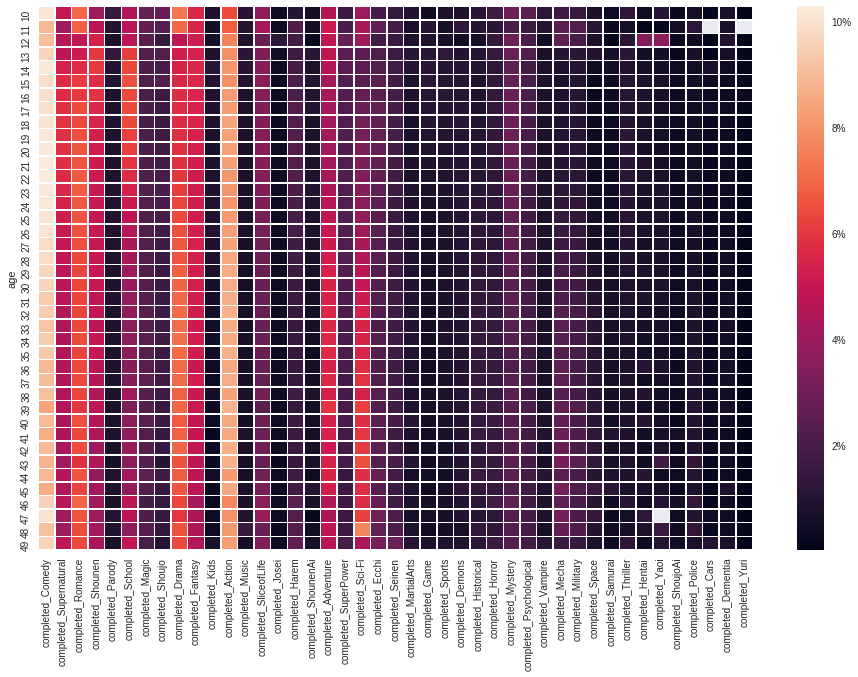

In [33]:
f, ax = plt.subplots(figsize=(16, 10))
data = ages_genres.div(ages_genres.sum(axis=1), axis=0) * 100
cmap = equalize_colormap(plt.cm.hot, data)
mask = np.zeros_like(ages_genres, dtype=np.bool)
mask[ages_genres.isnull()] = True
sns.heatmap(data, mask=mask, linewidths=.5, cbar_kws={'format': '%.0f%%'})

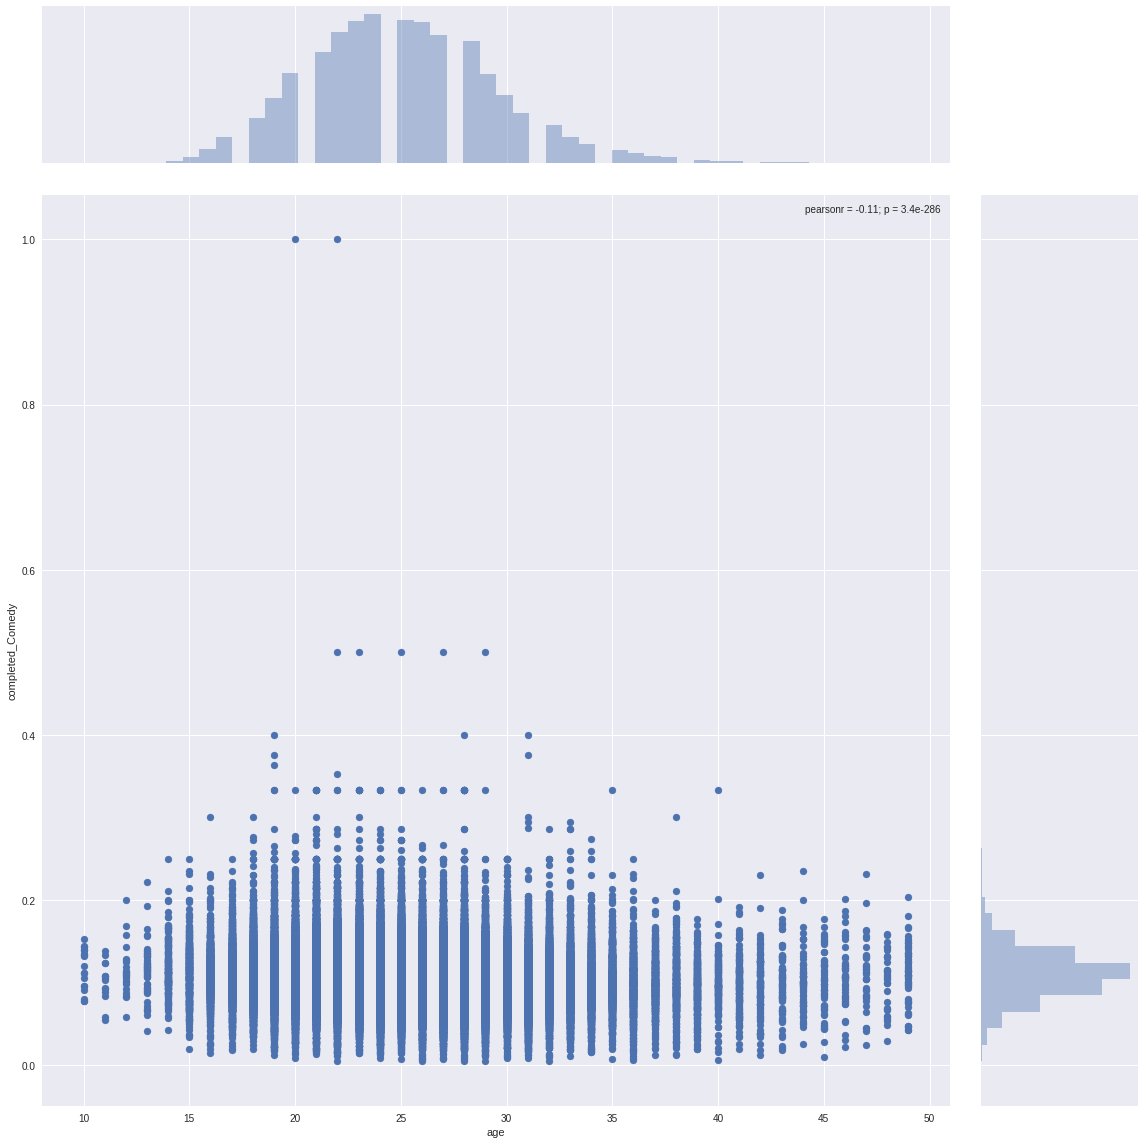

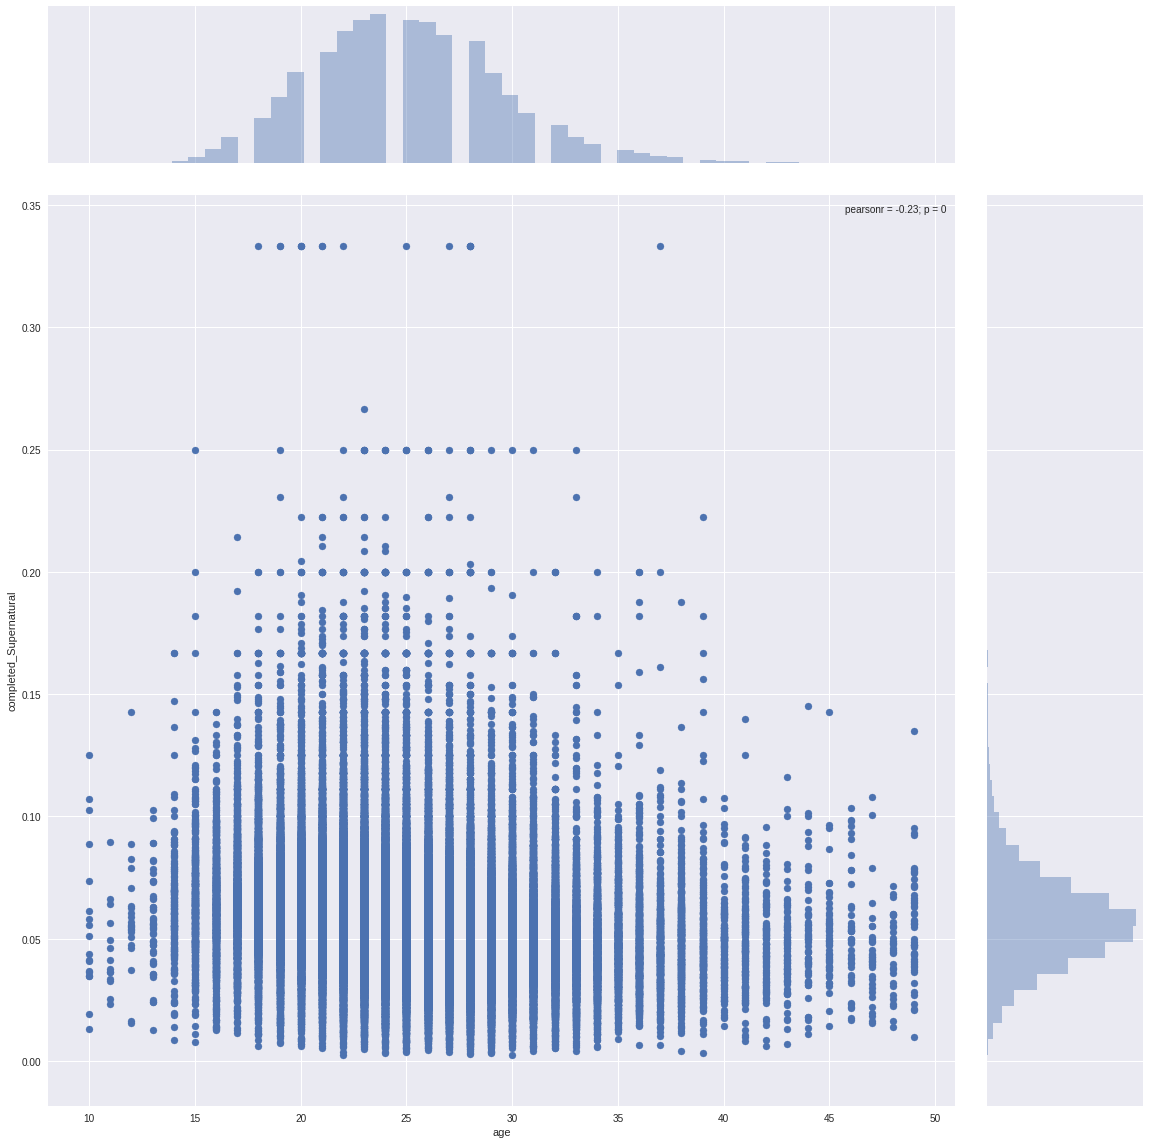

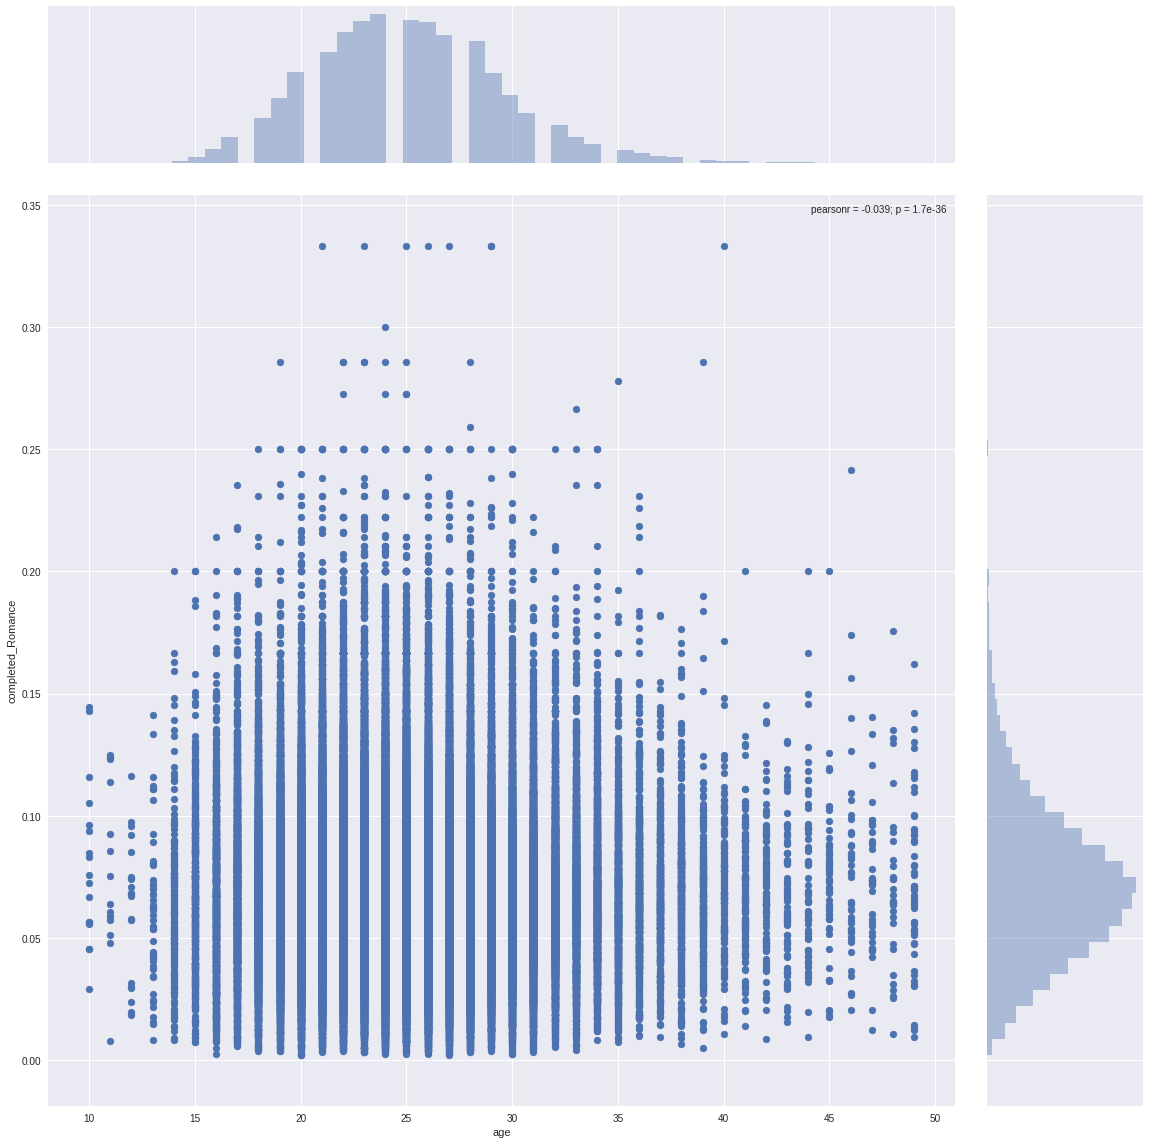

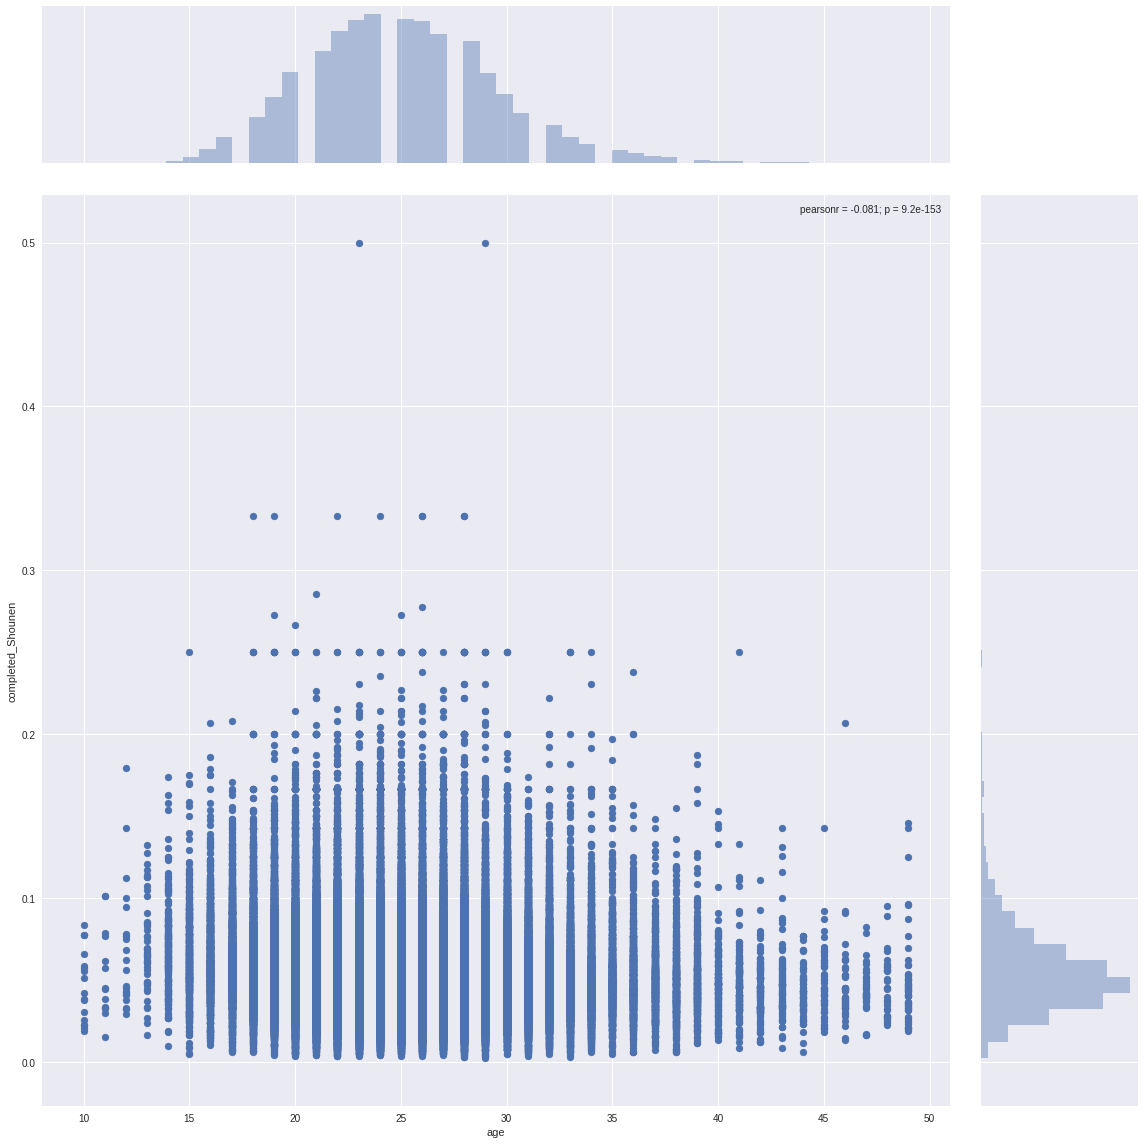

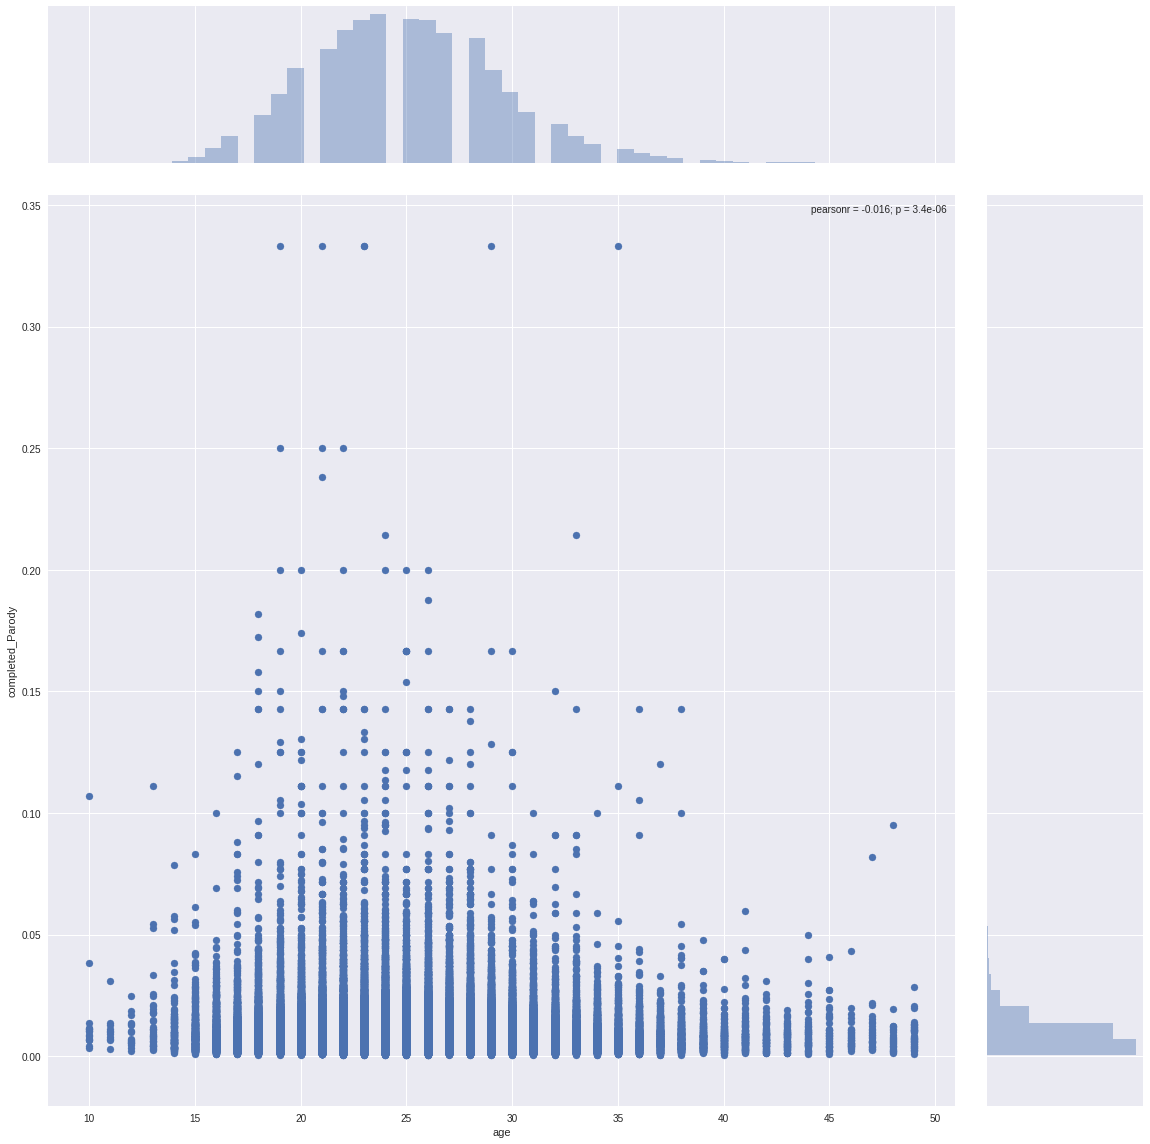

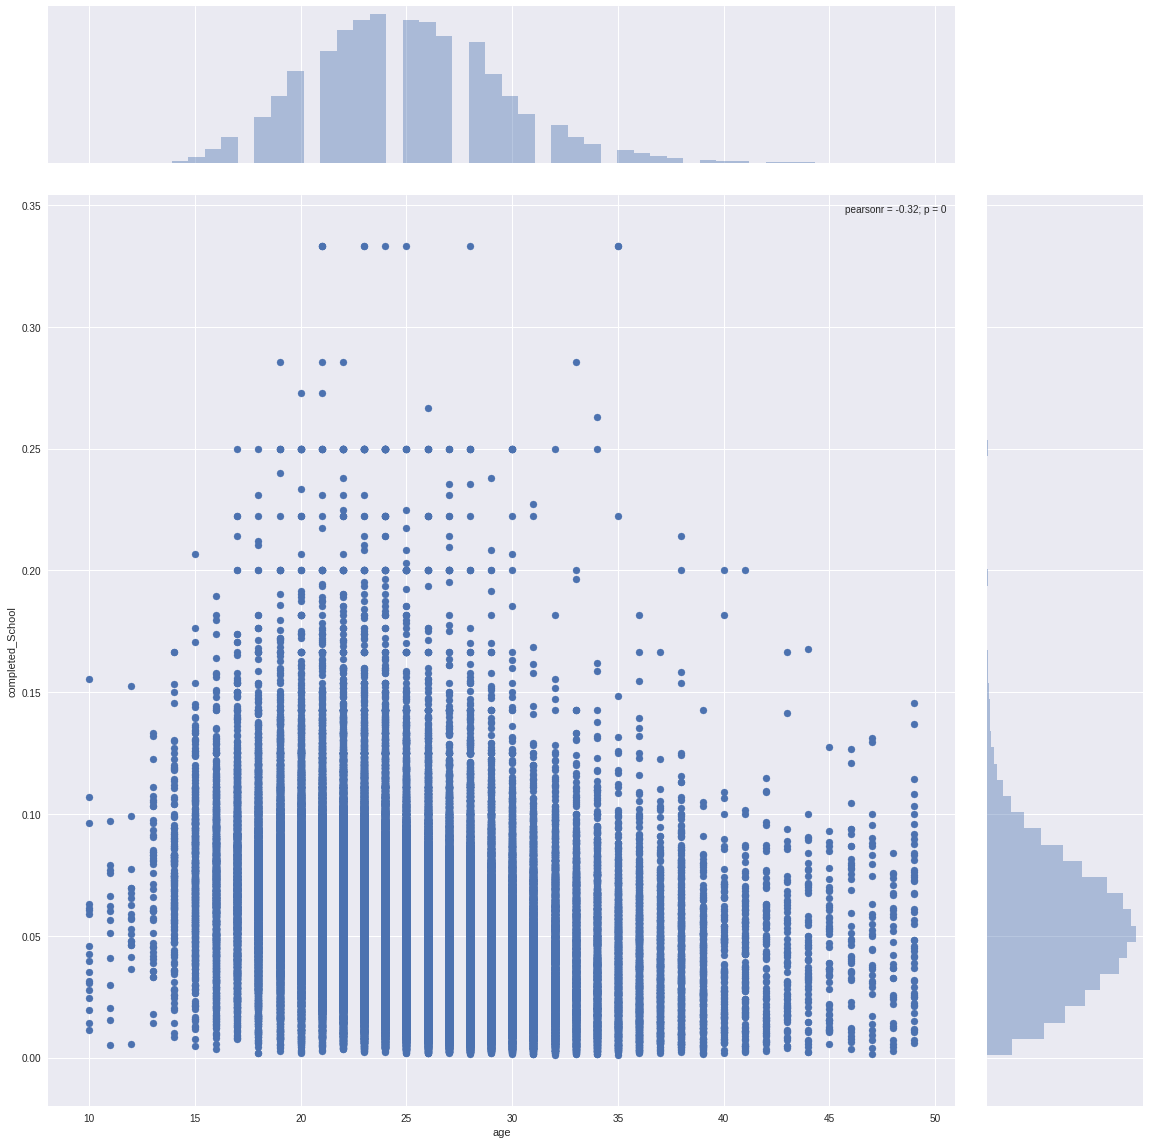

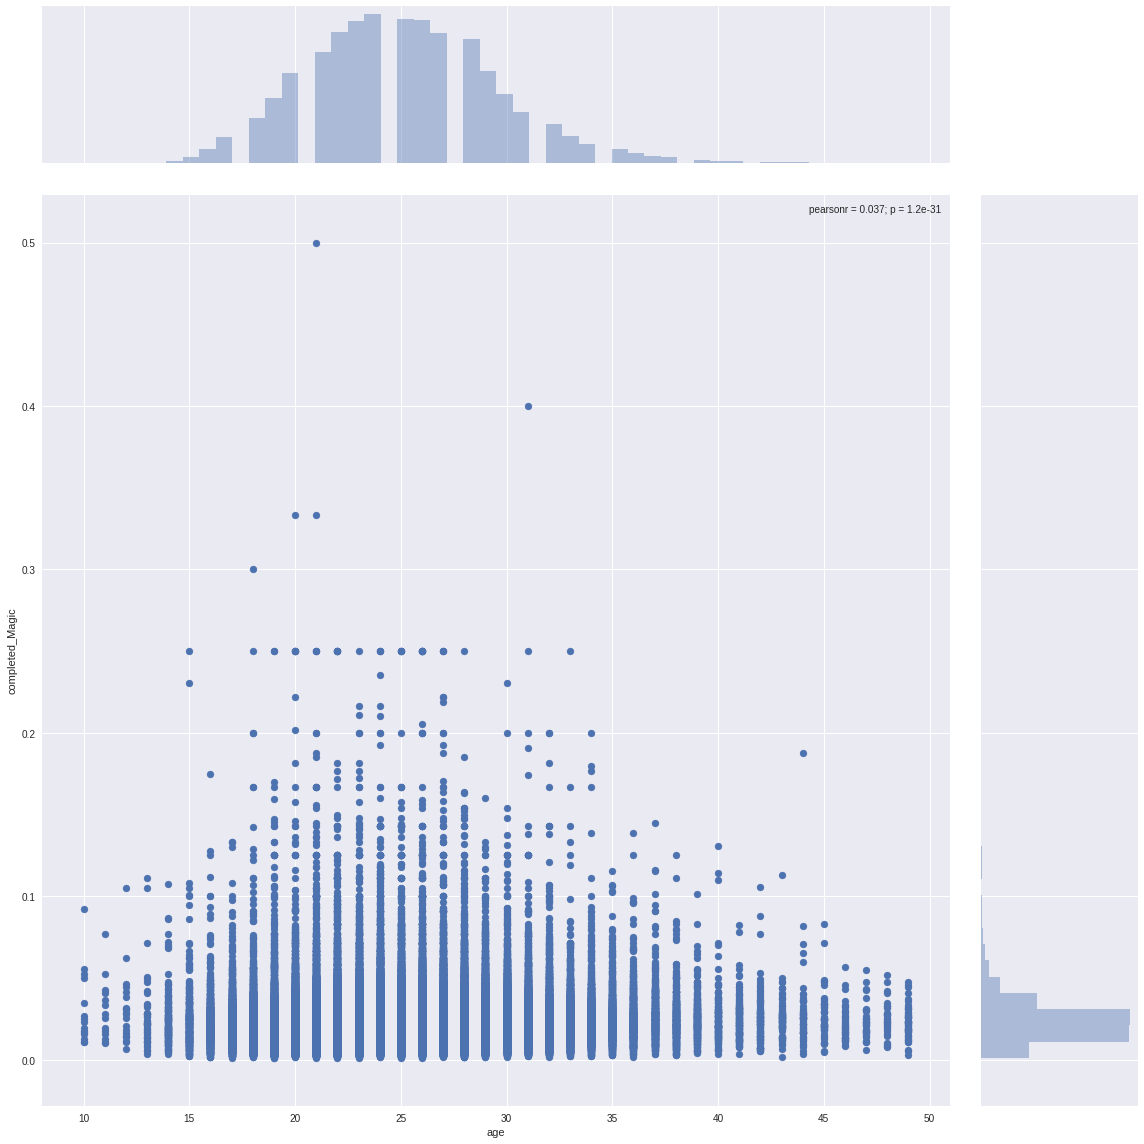

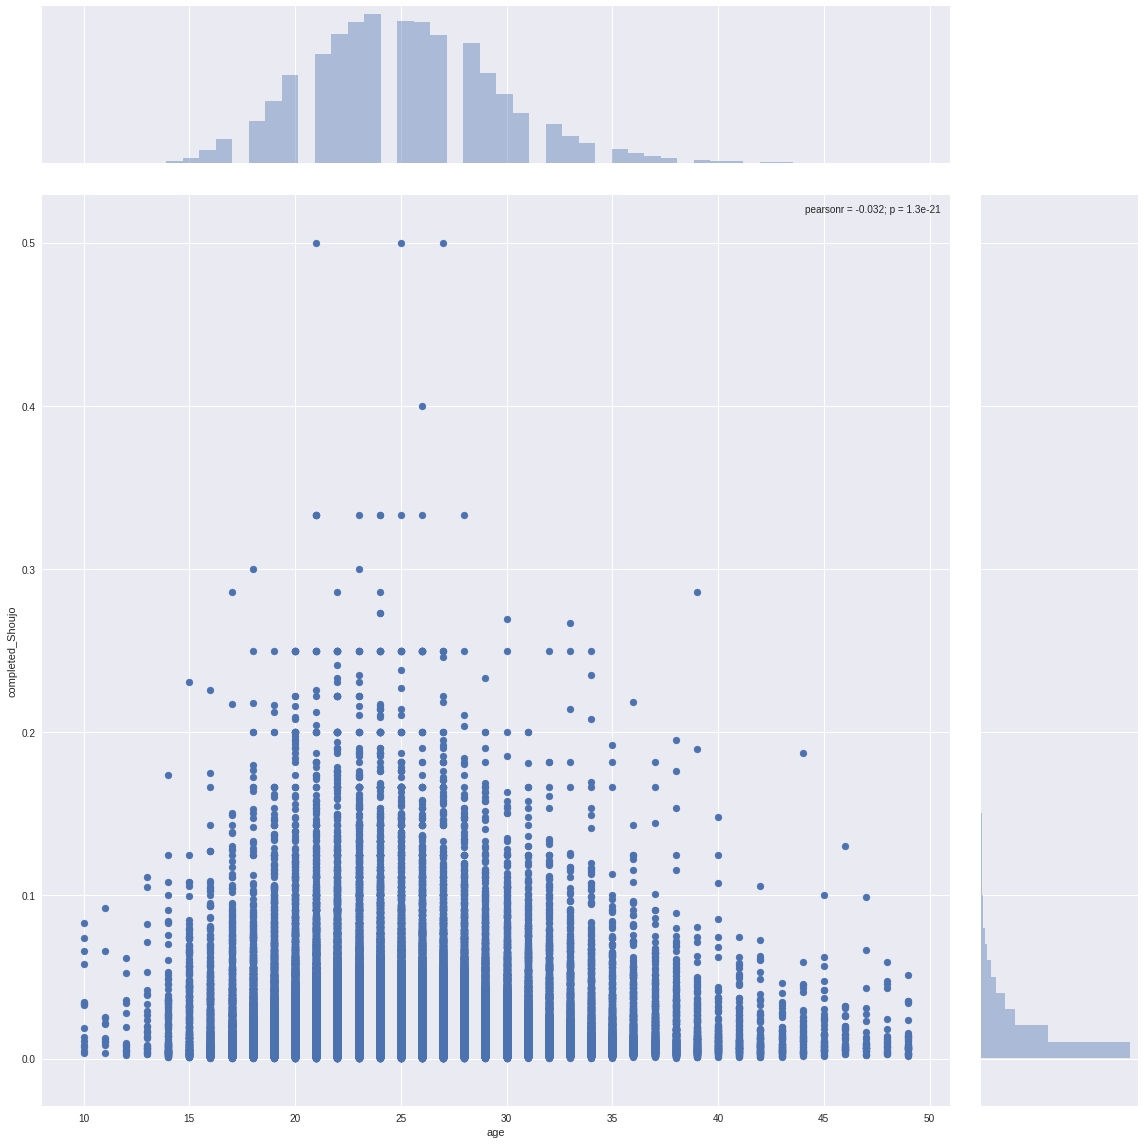

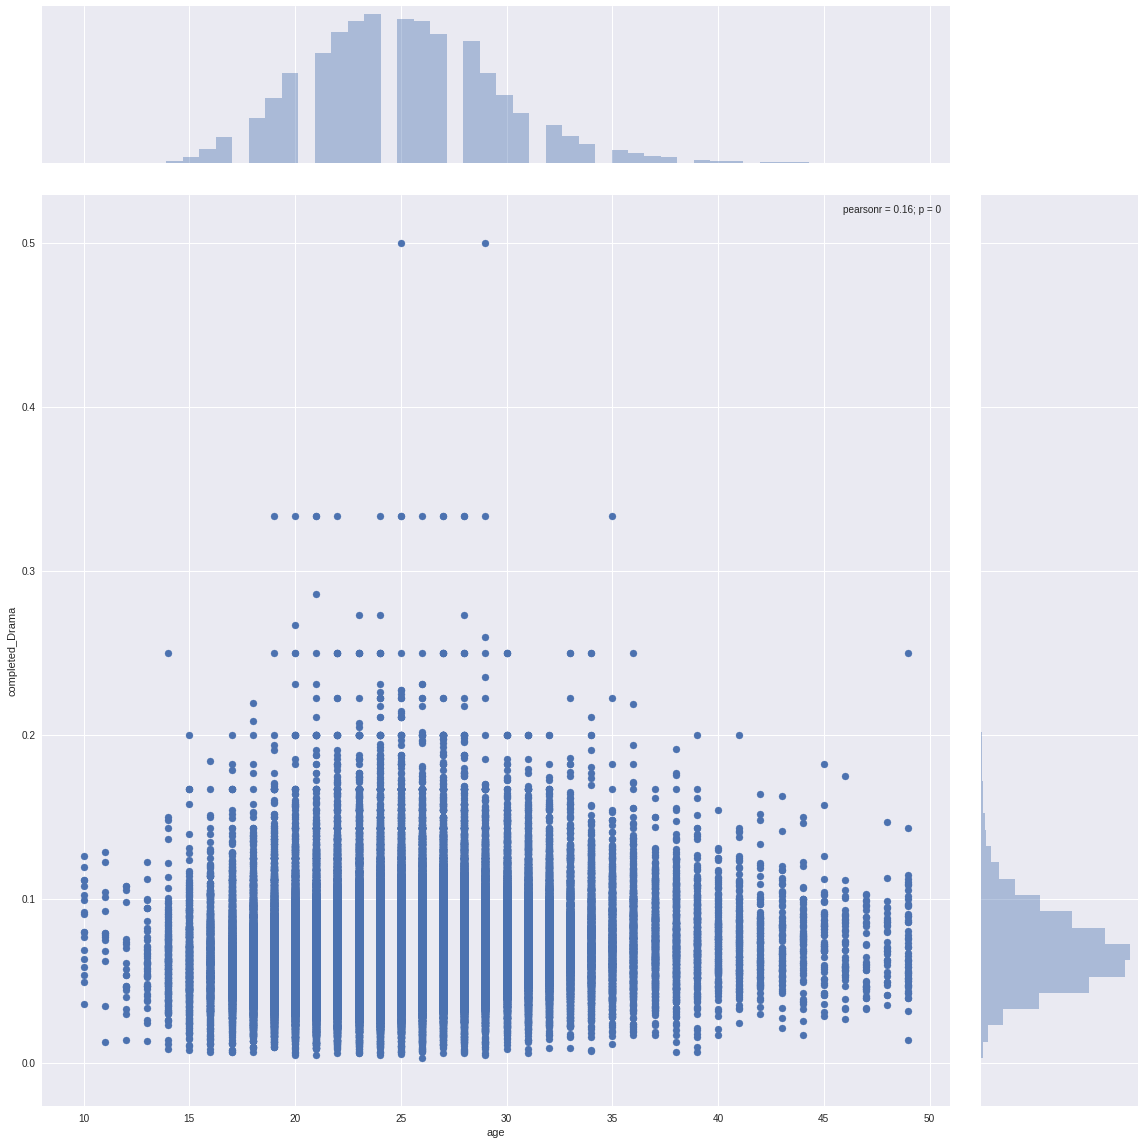

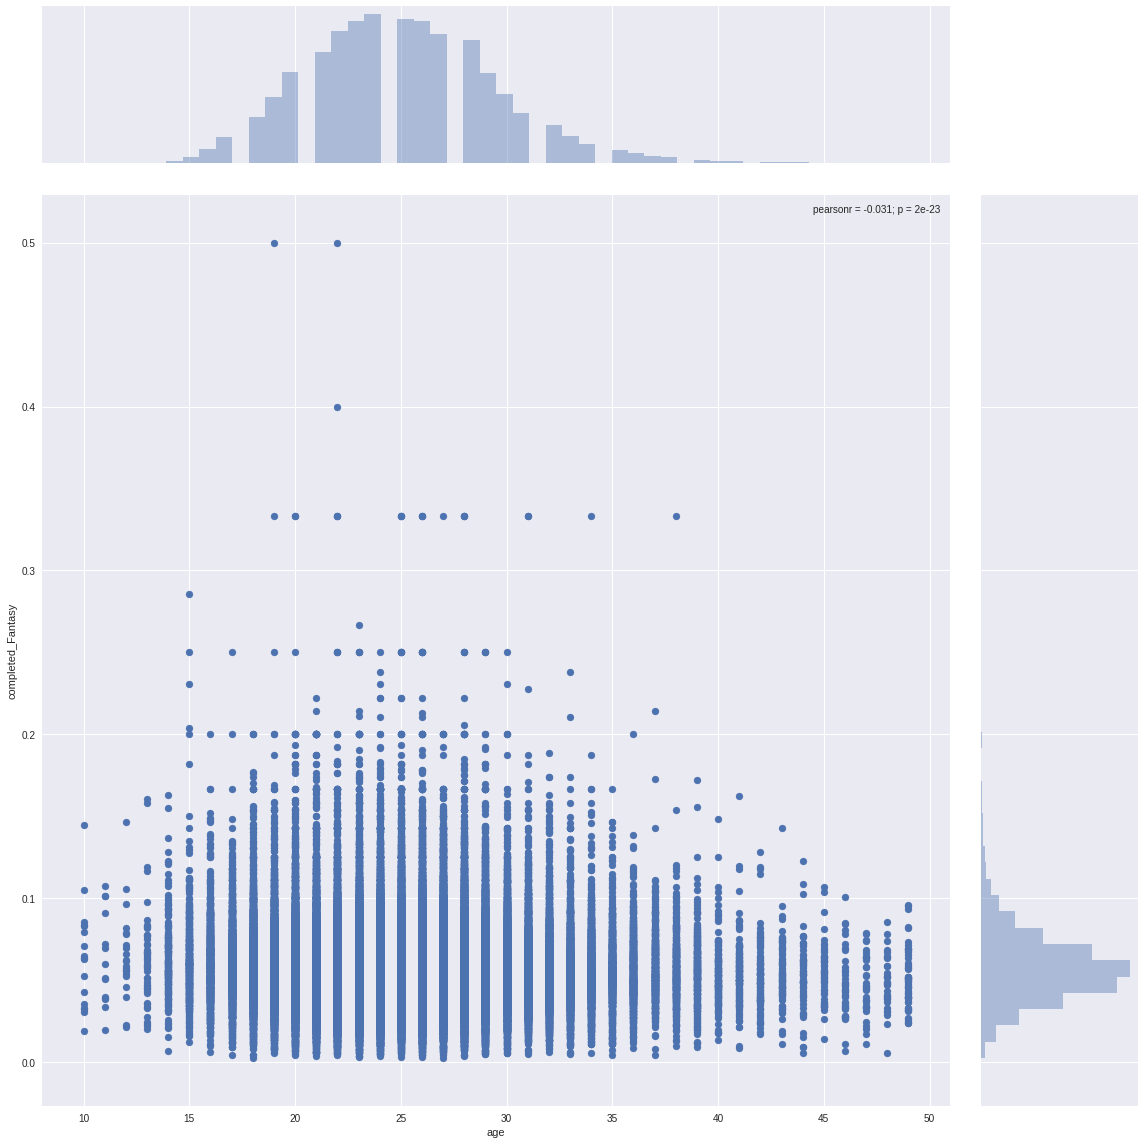

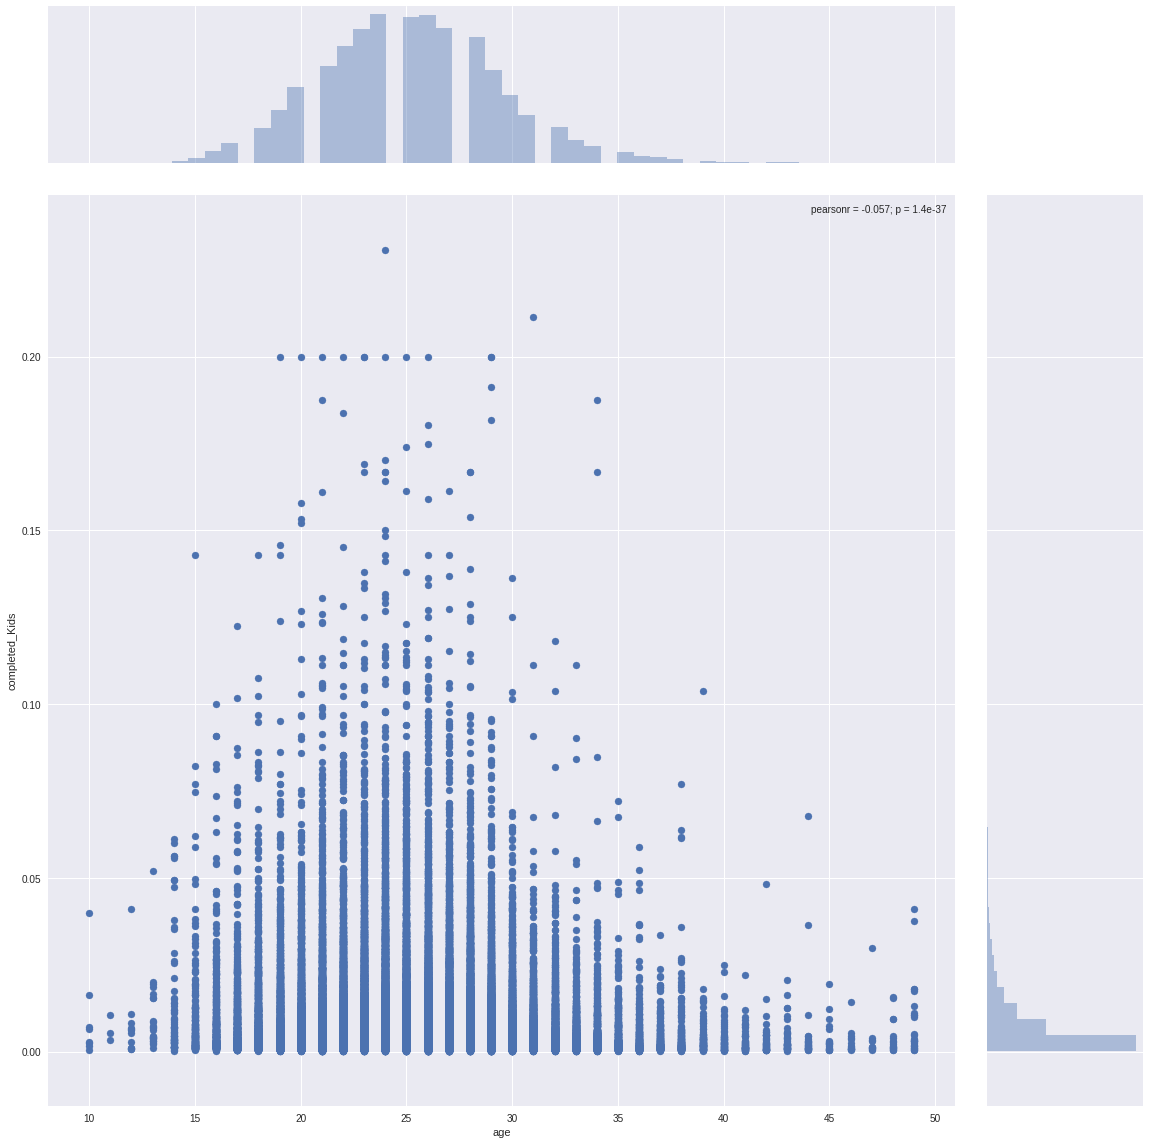

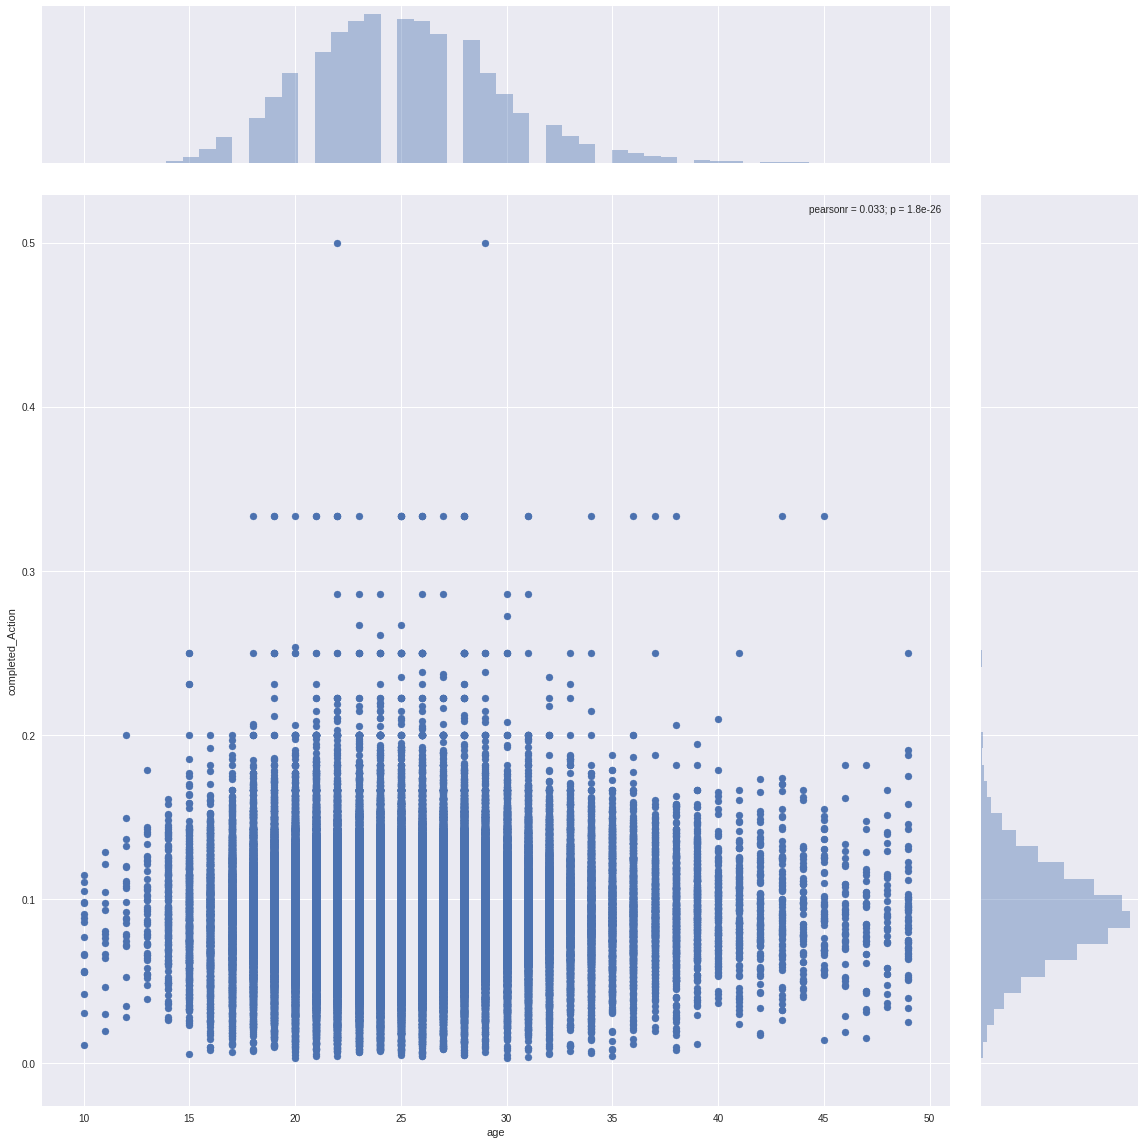

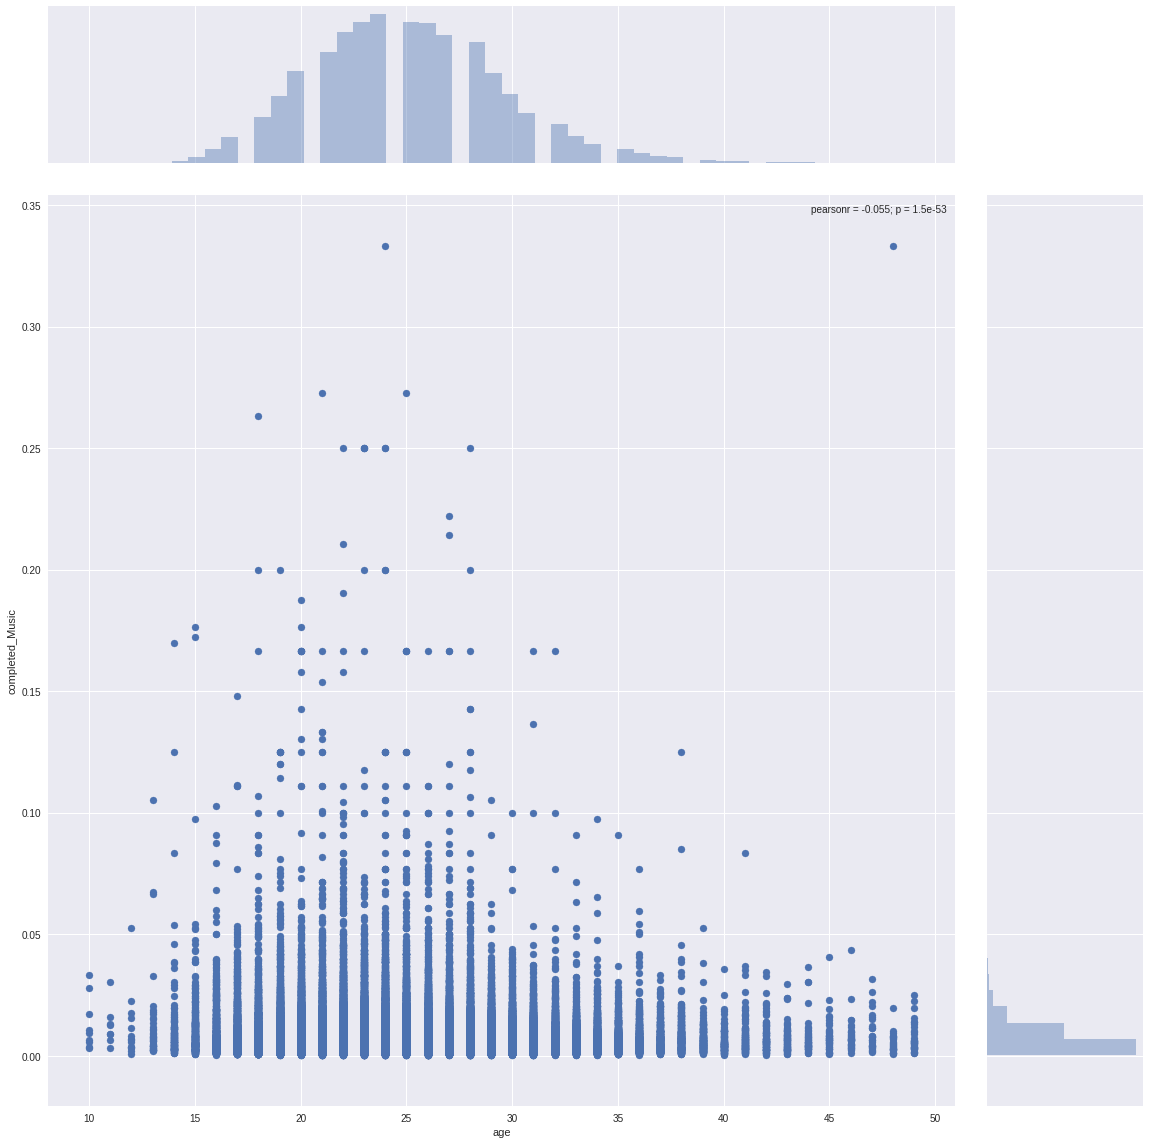

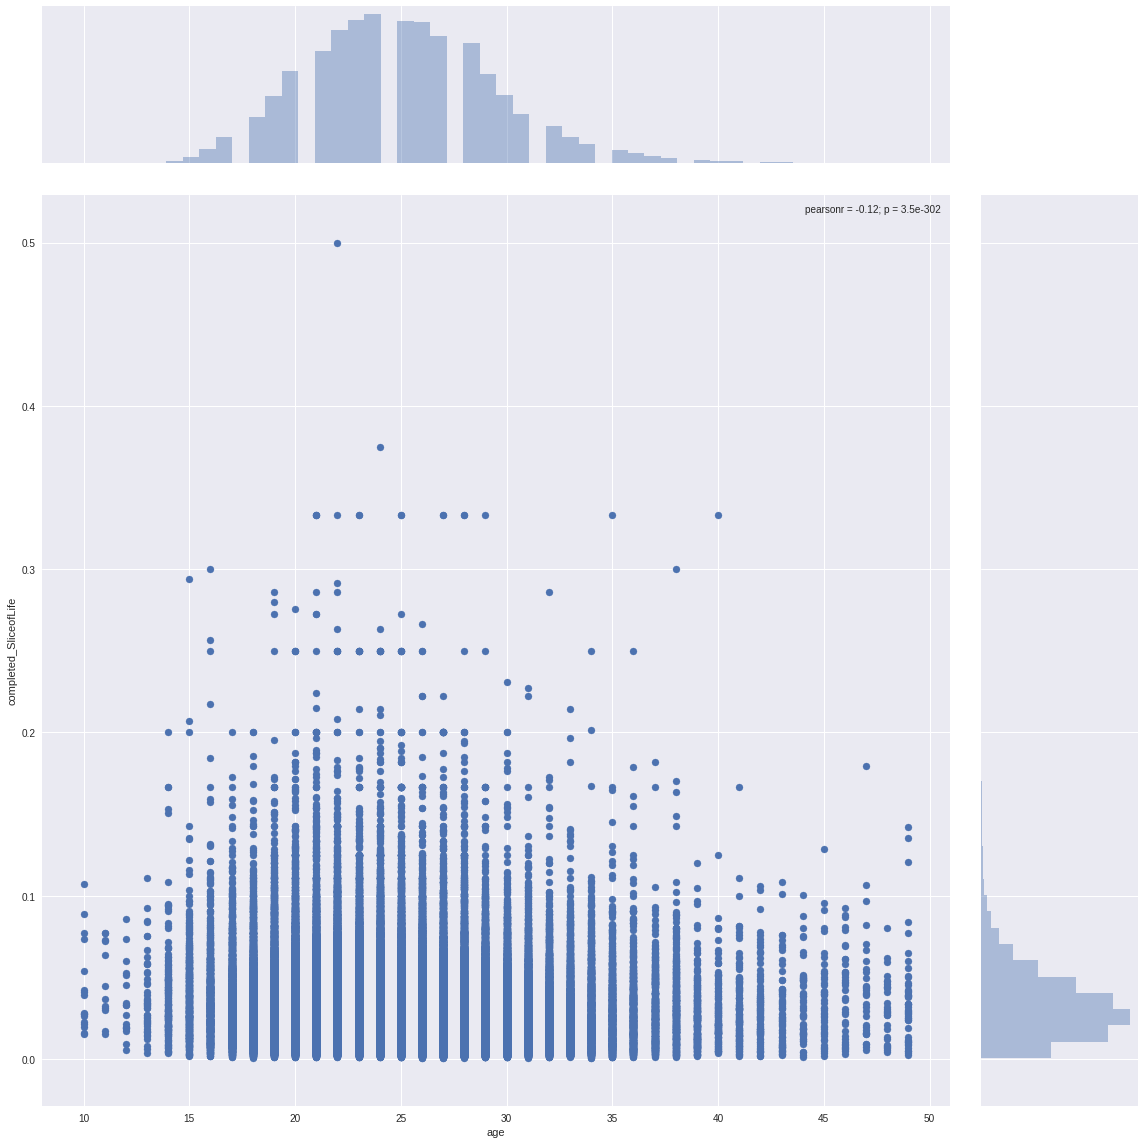

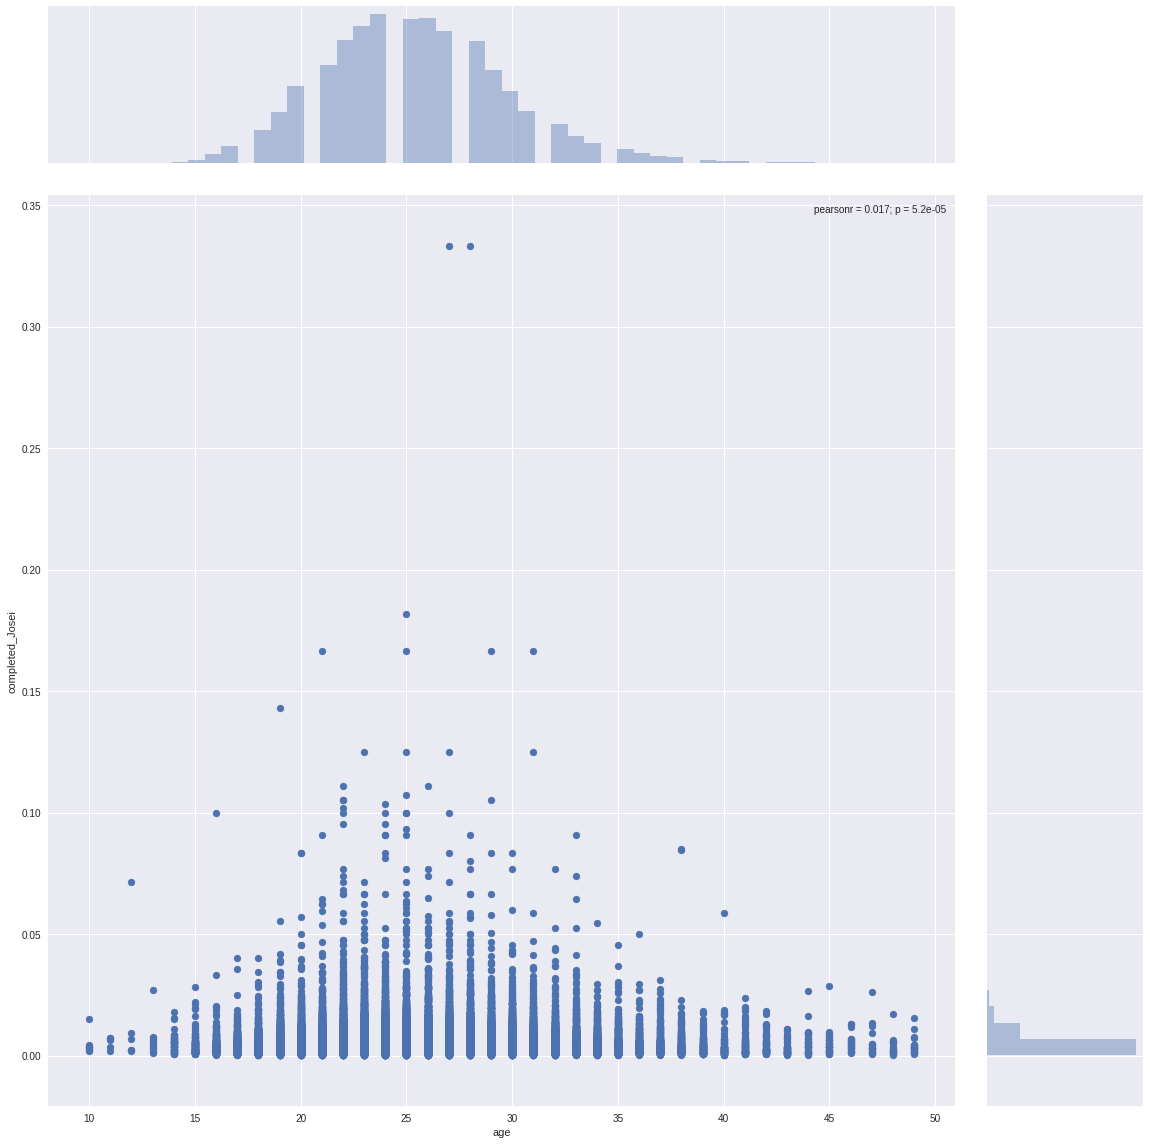

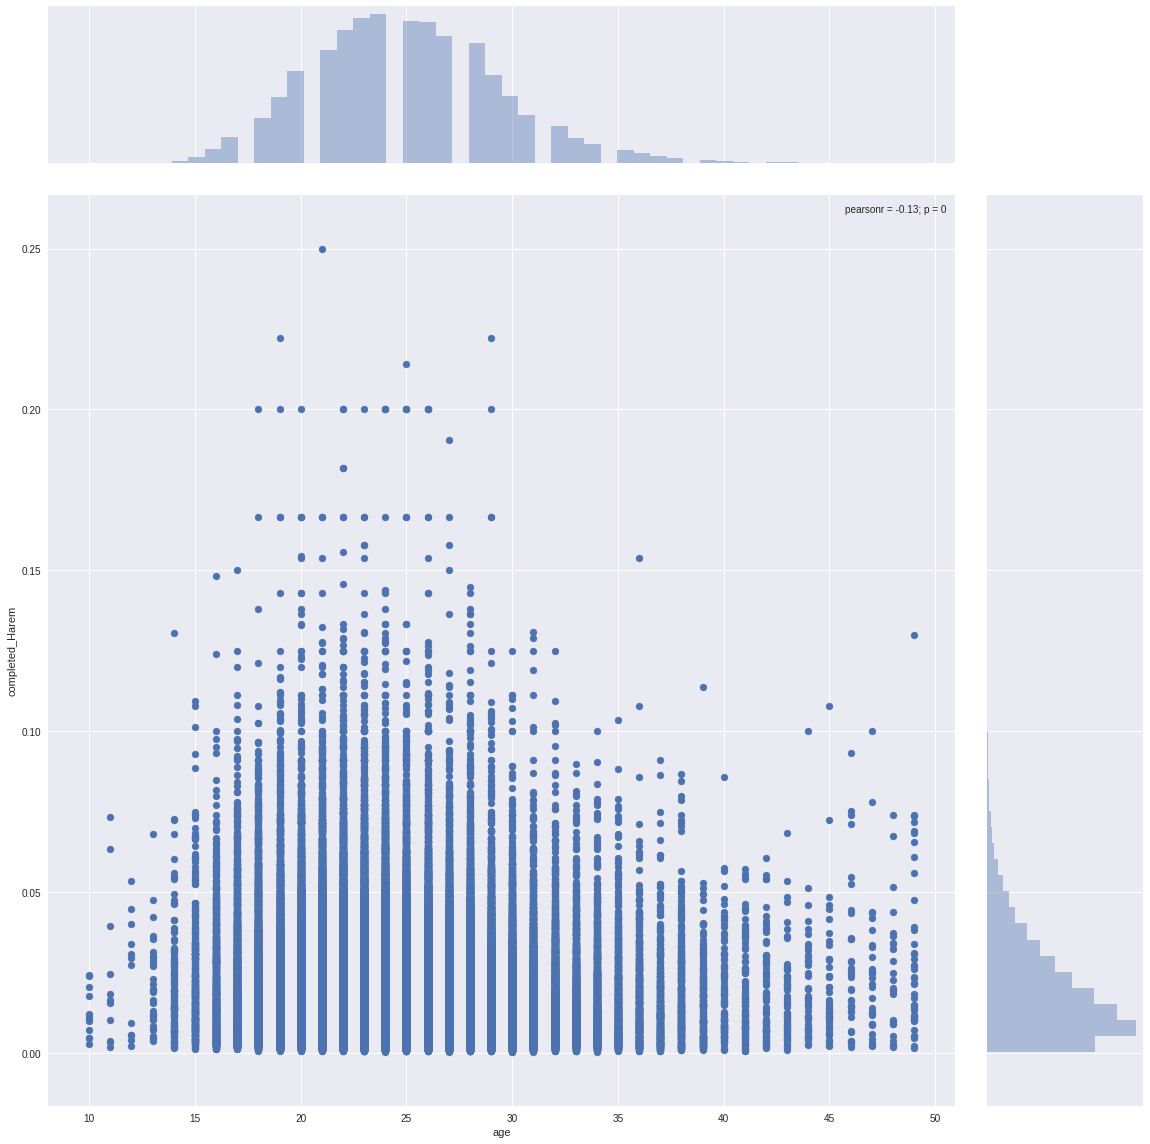

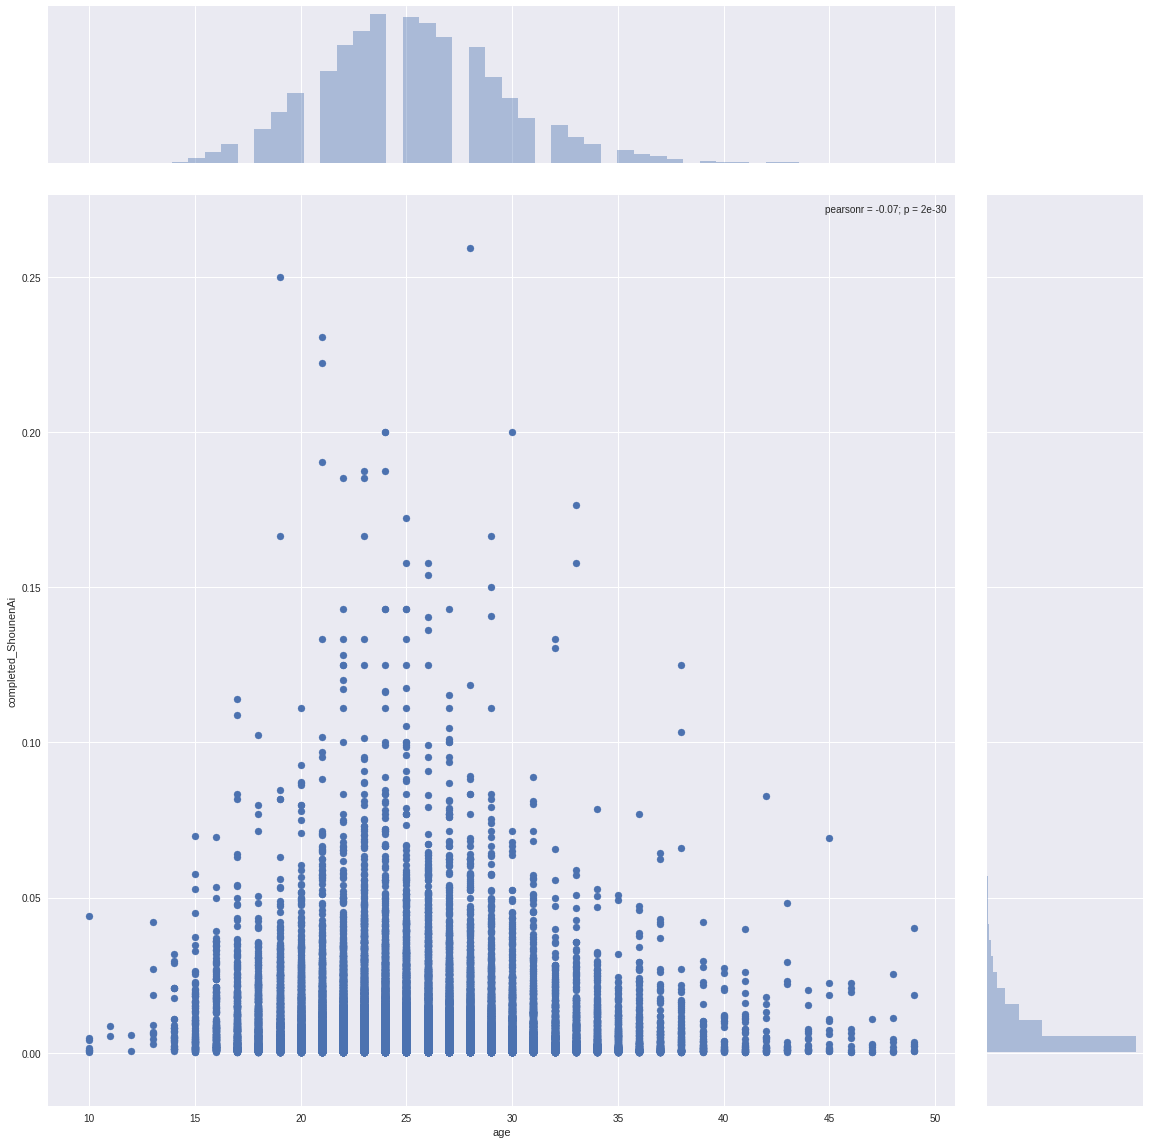

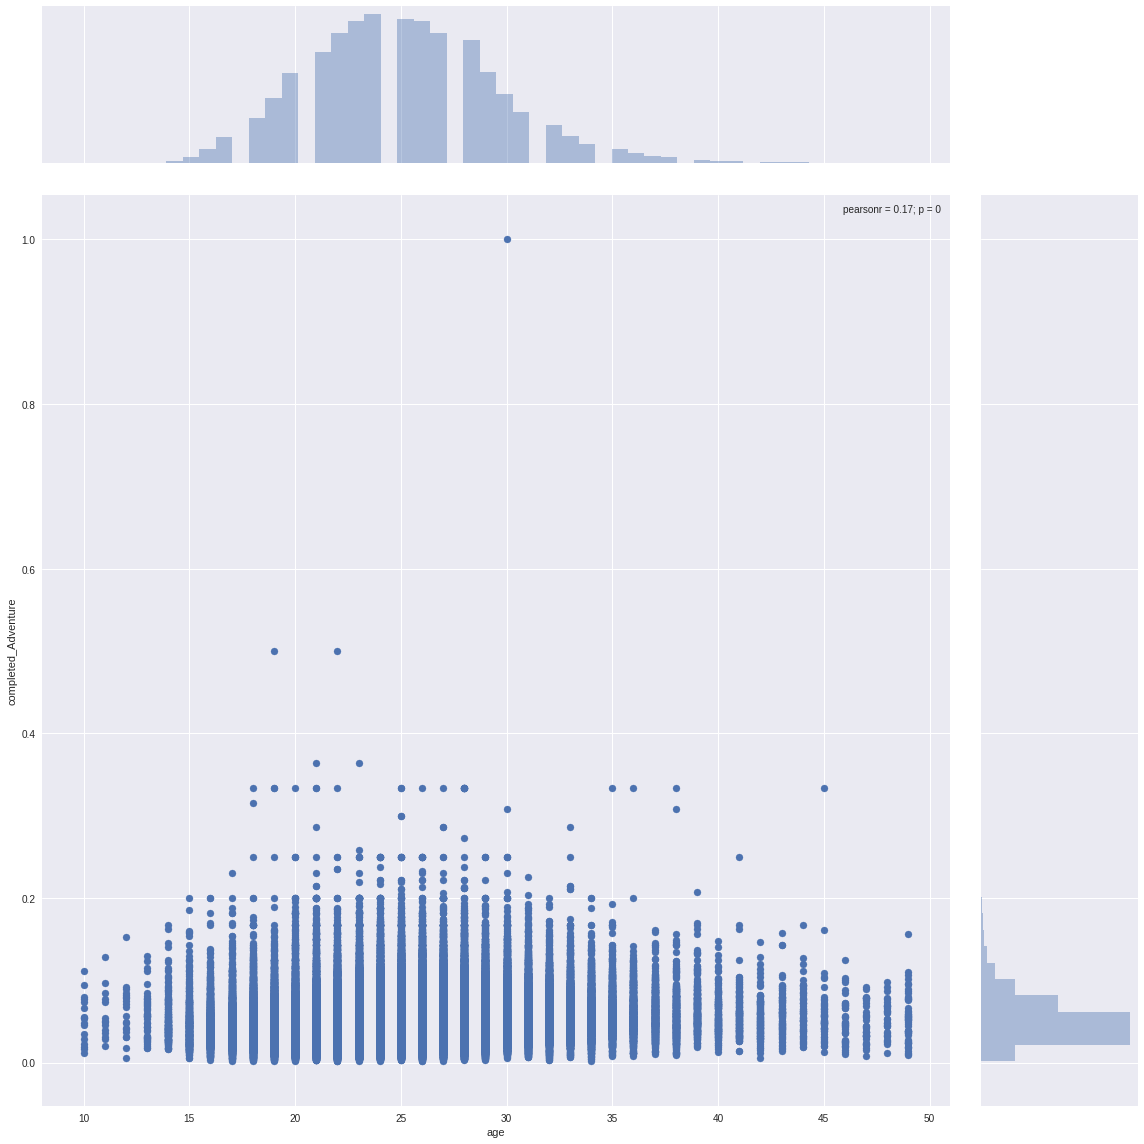

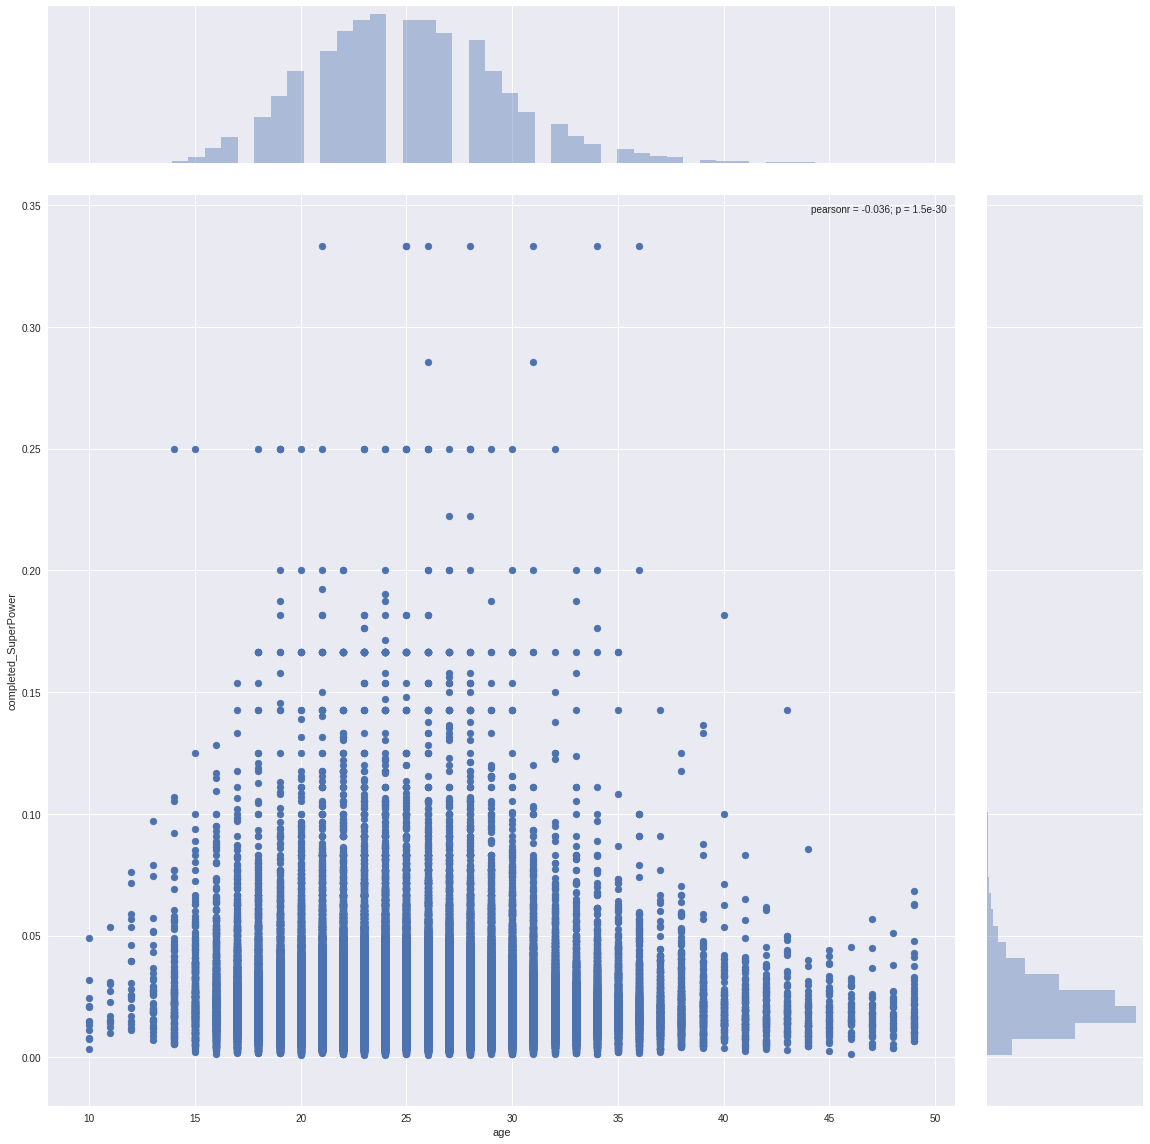

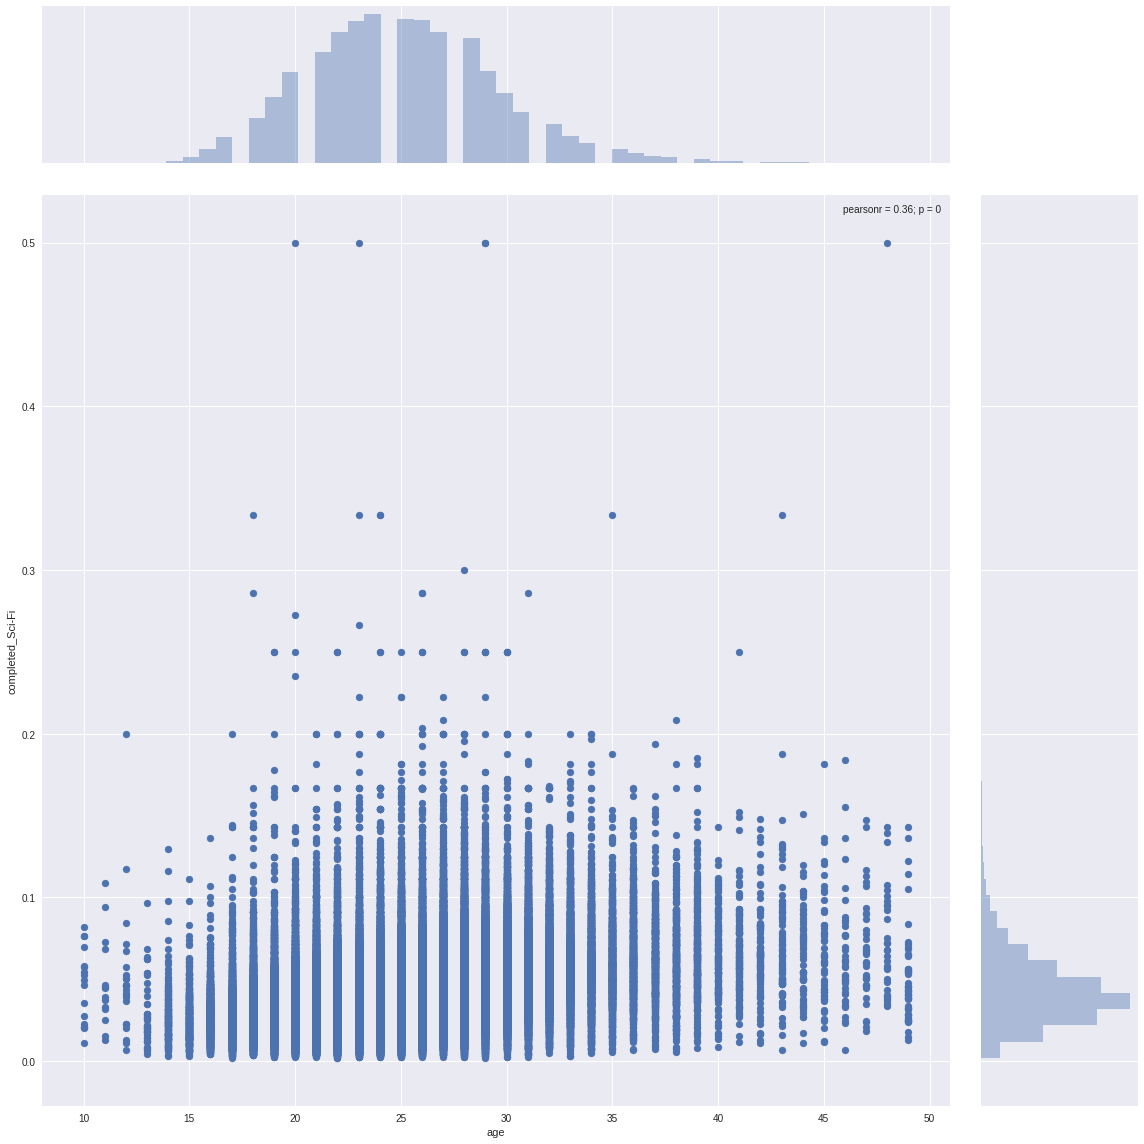

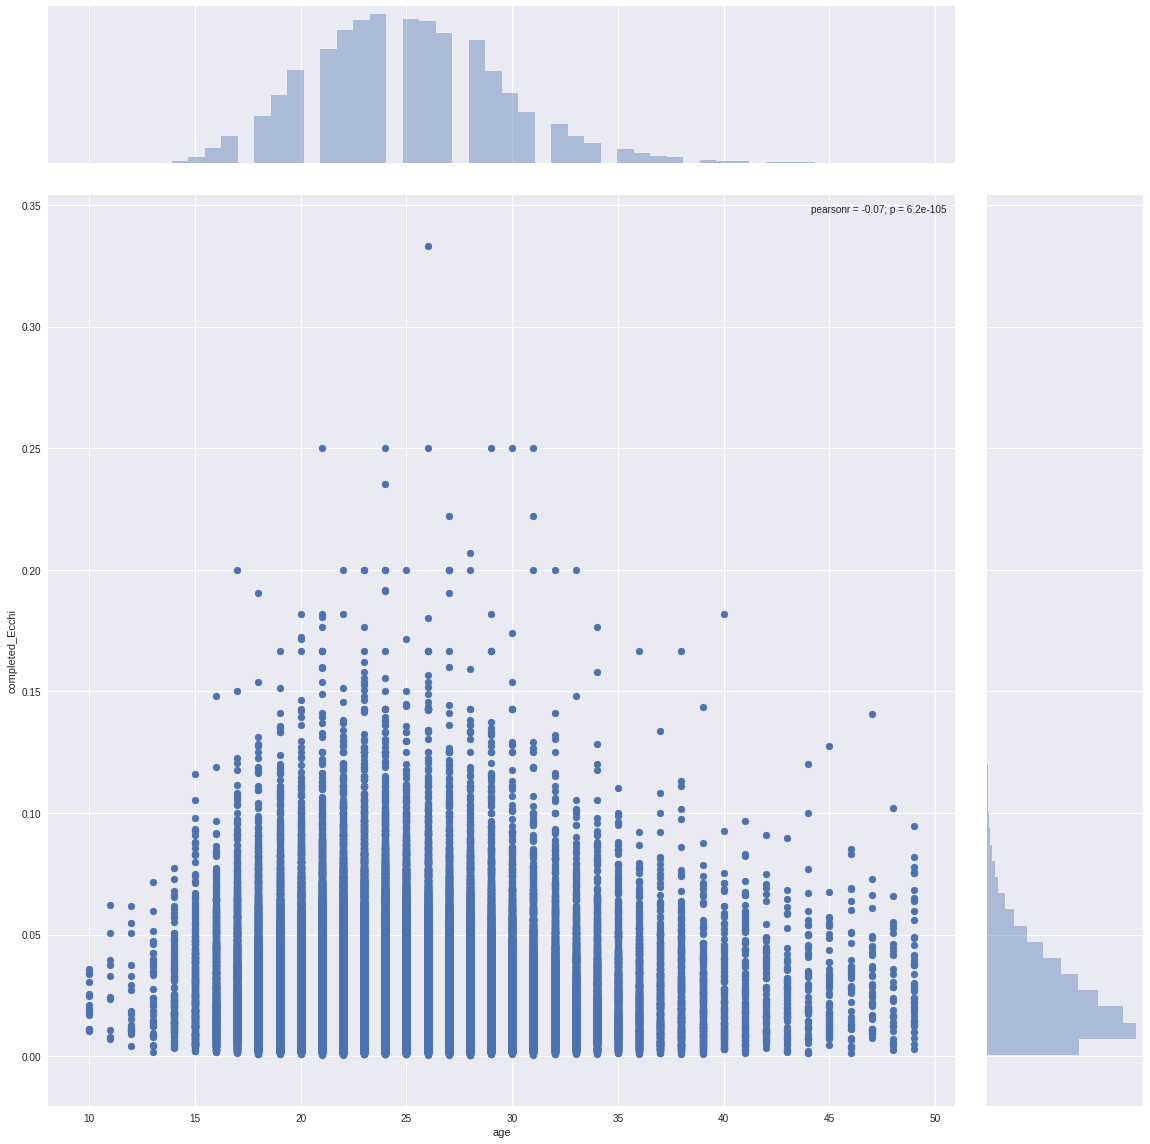

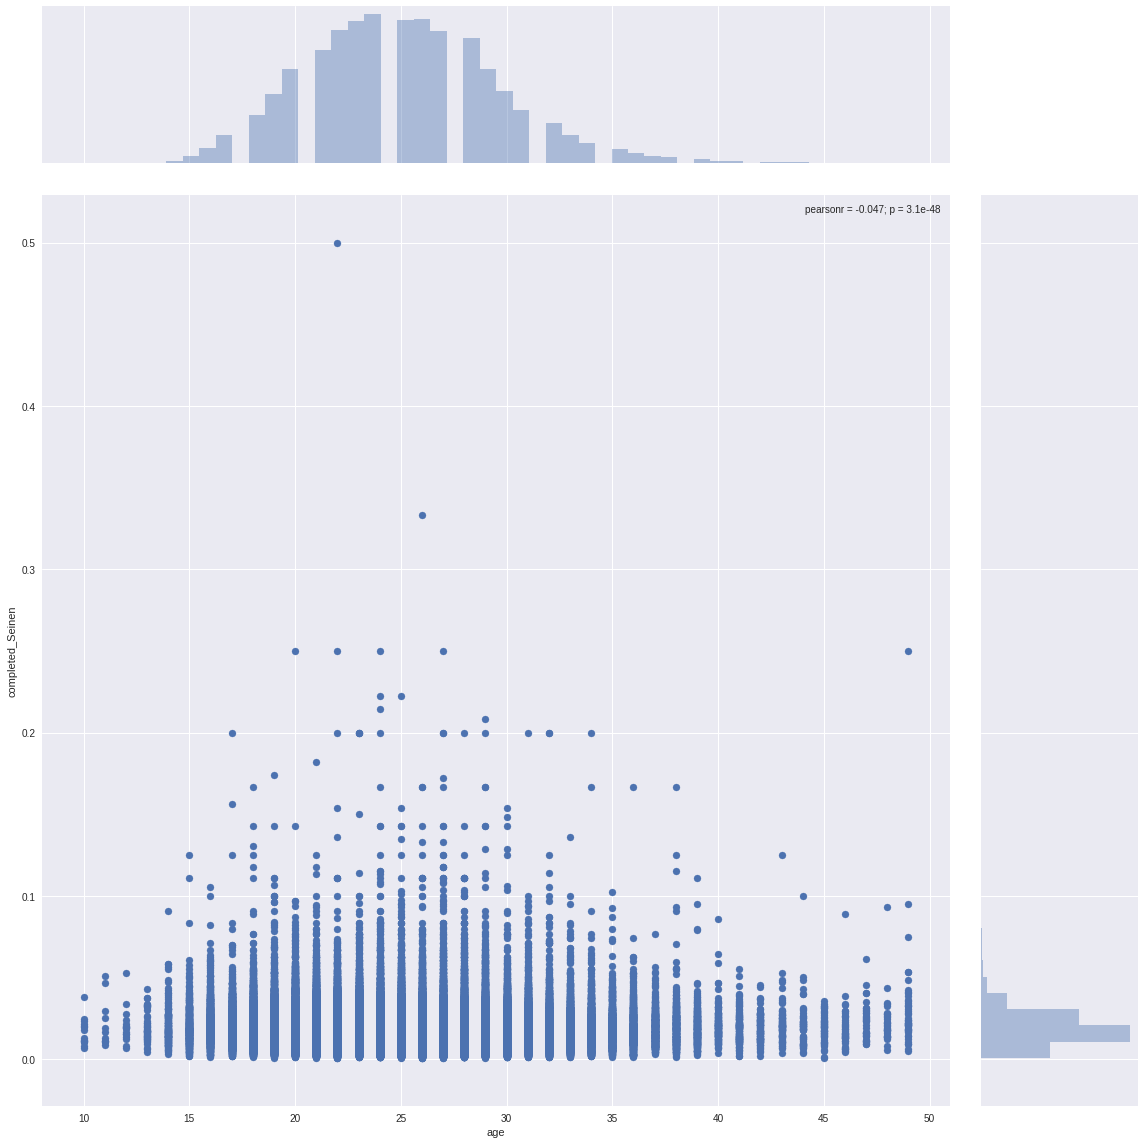

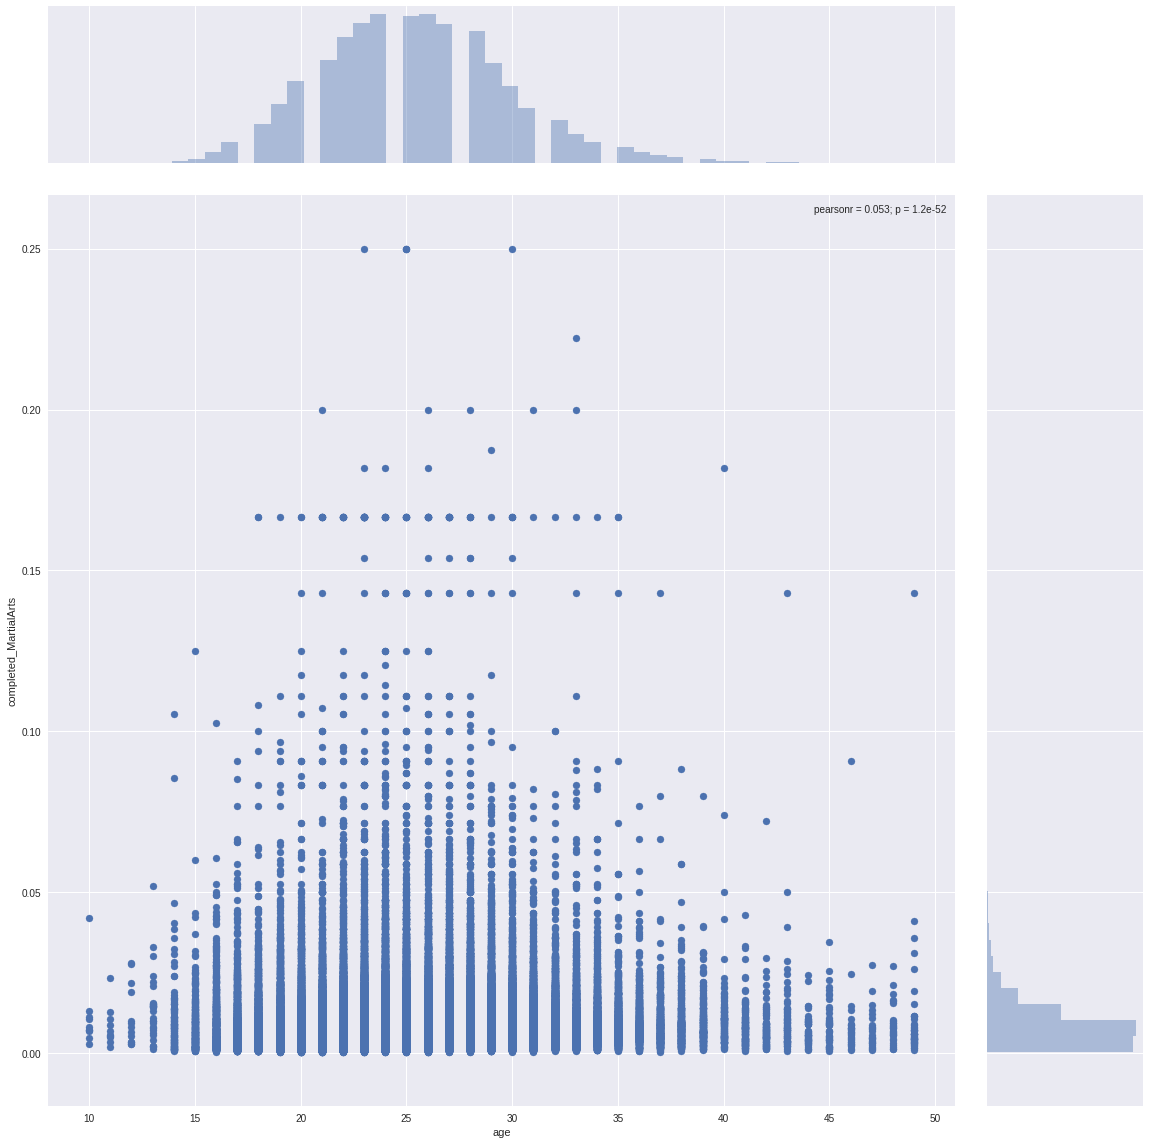

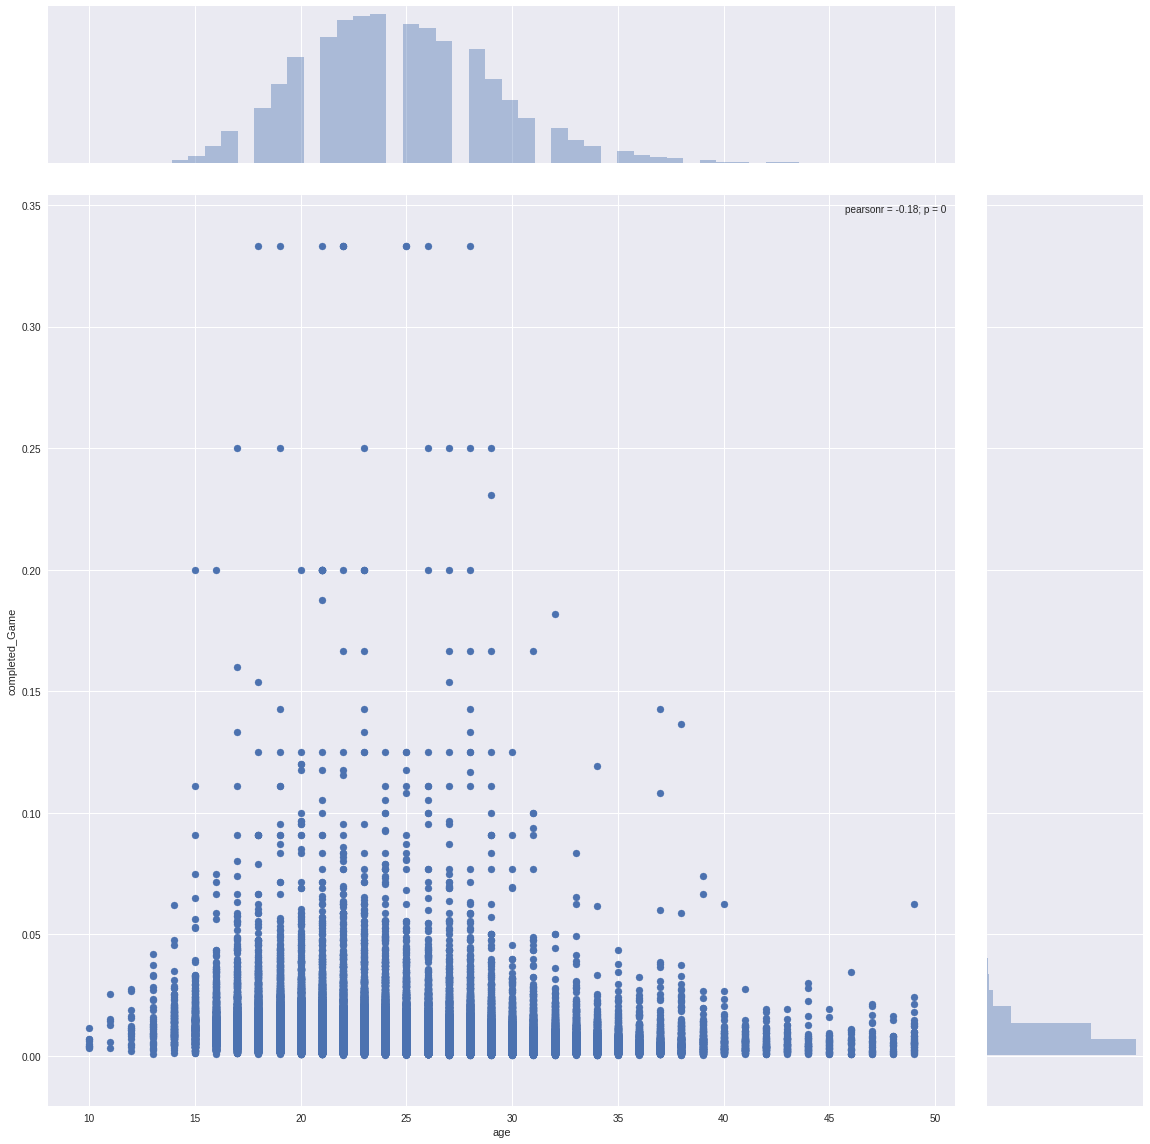

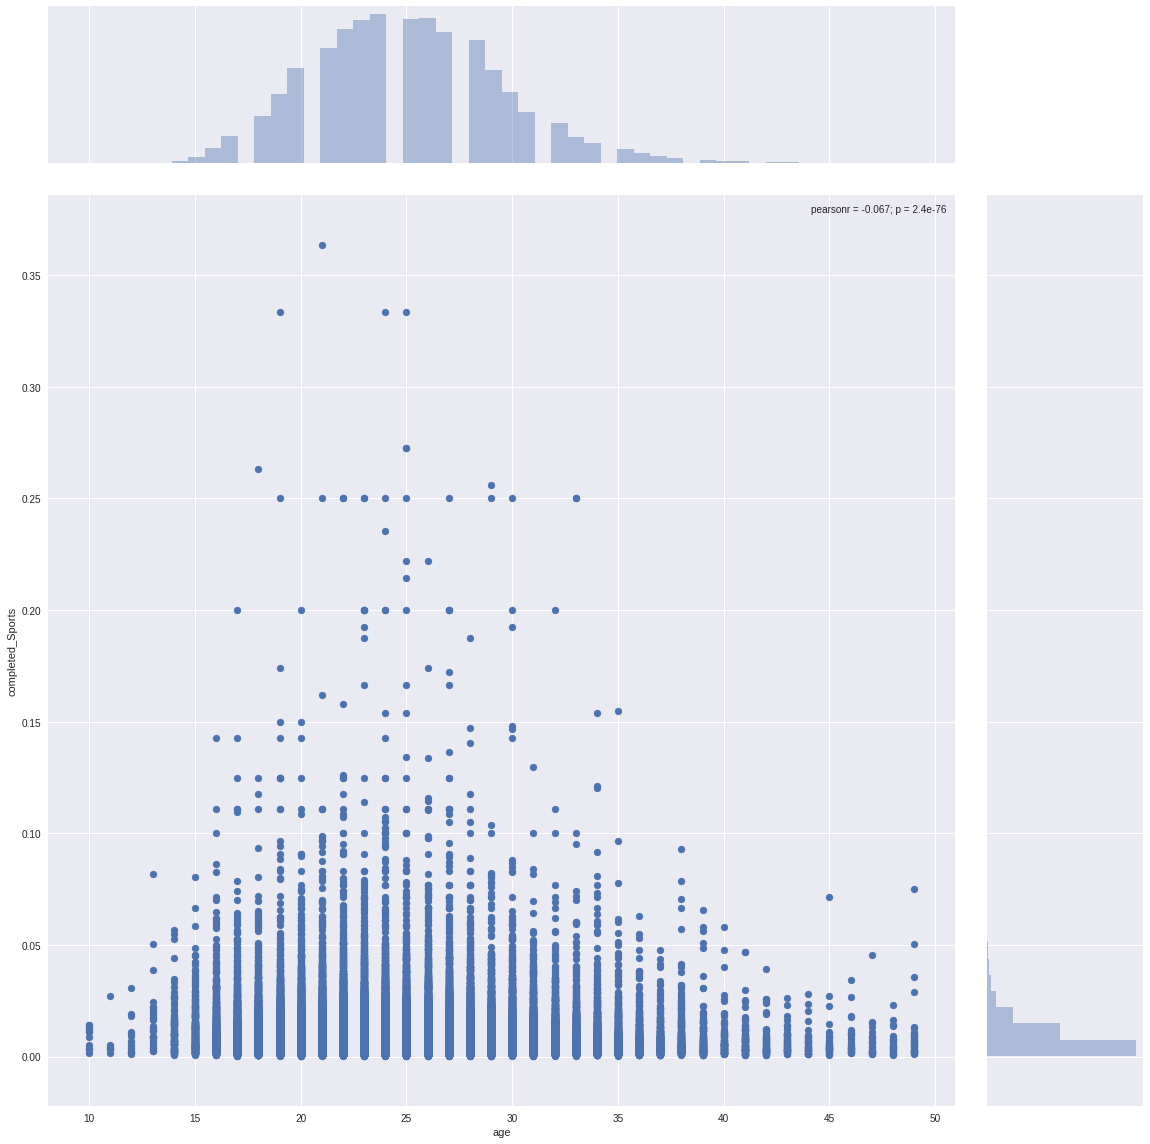

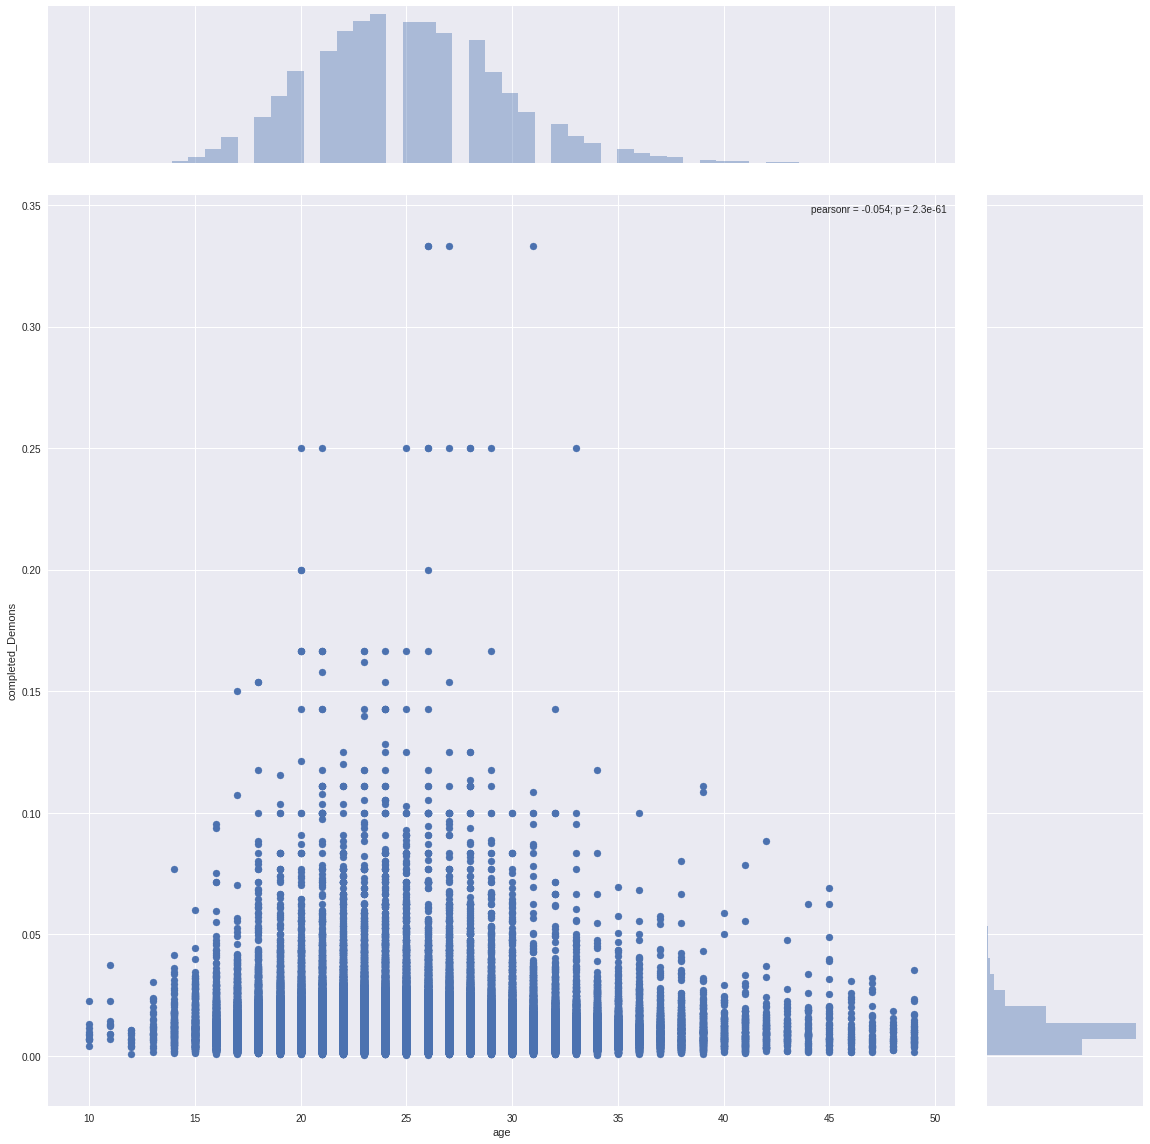

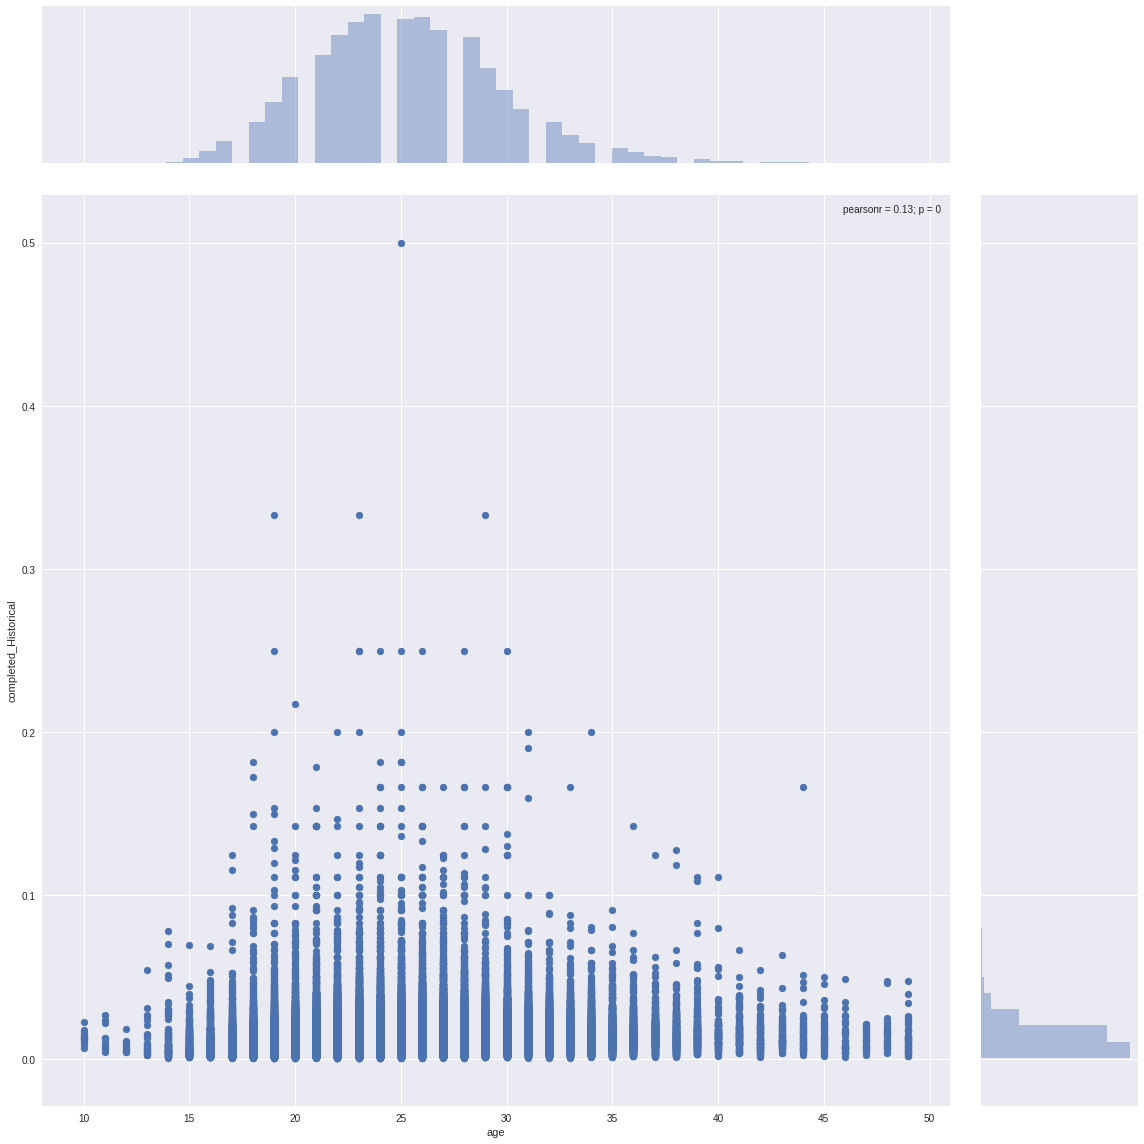

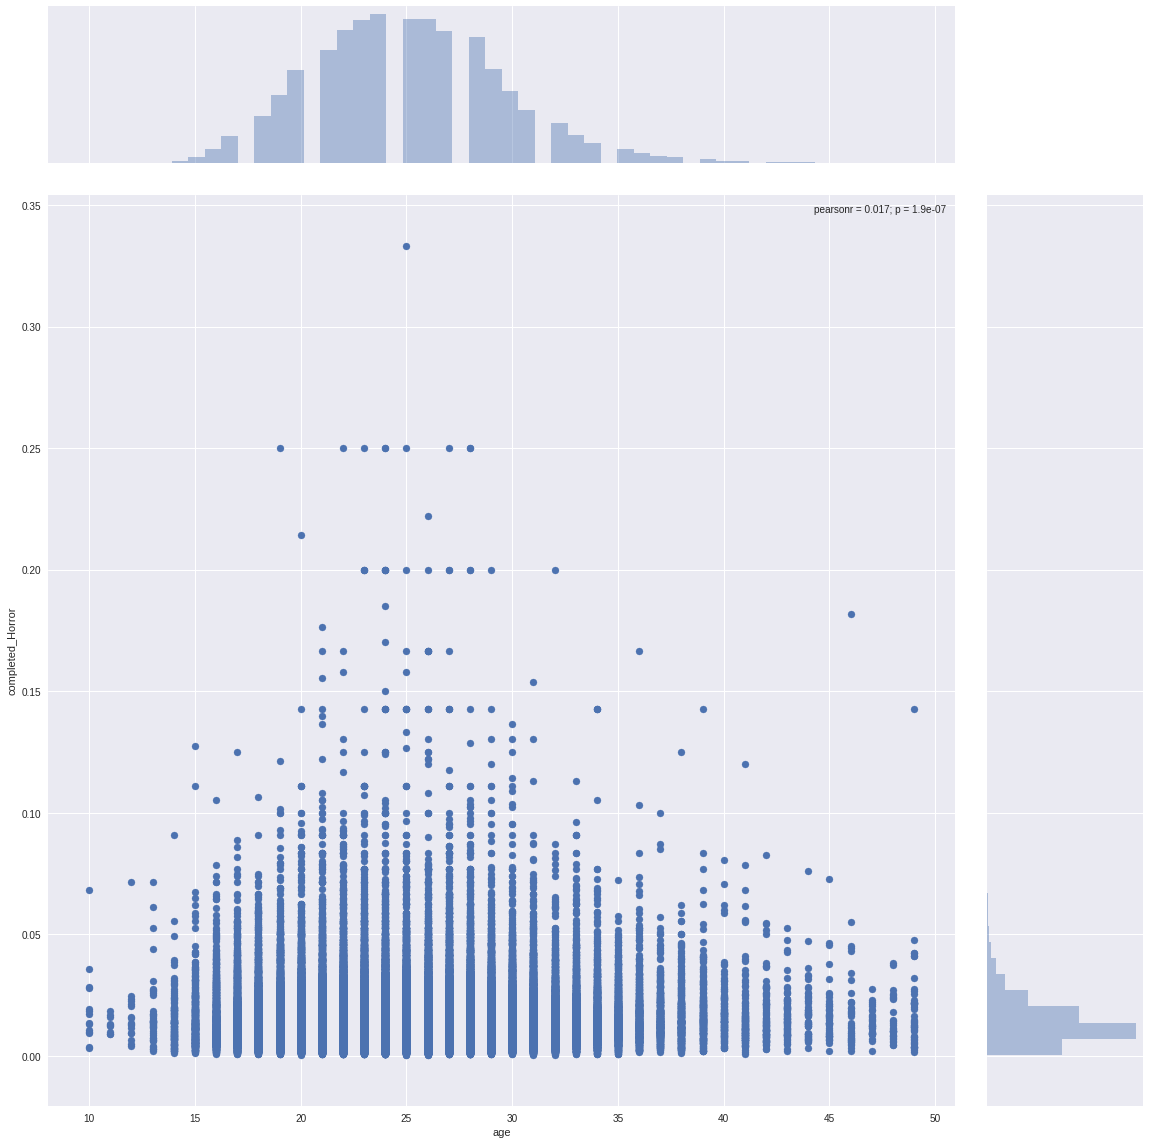

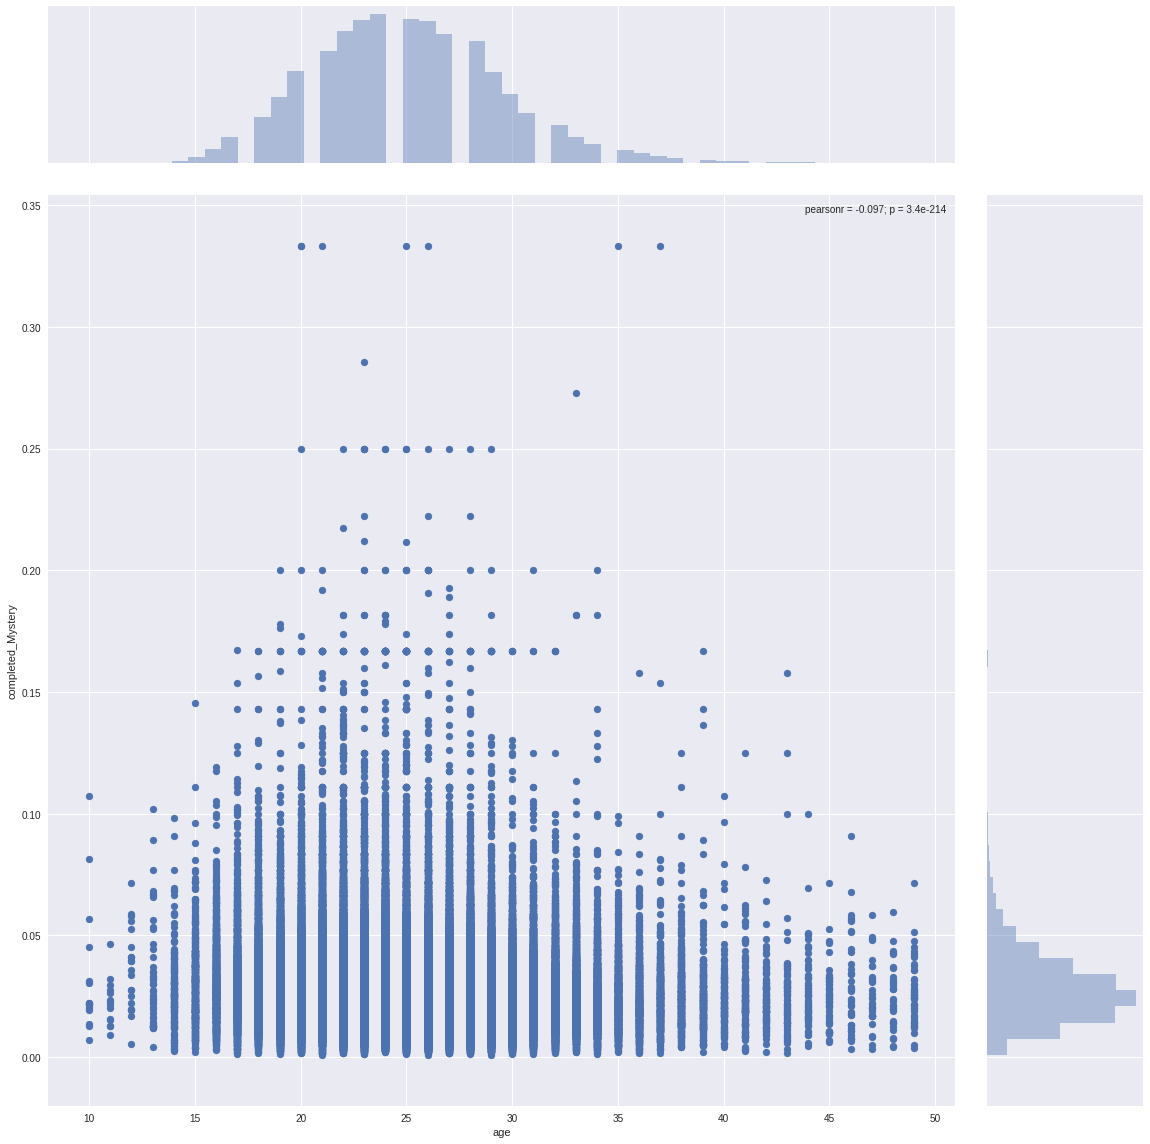

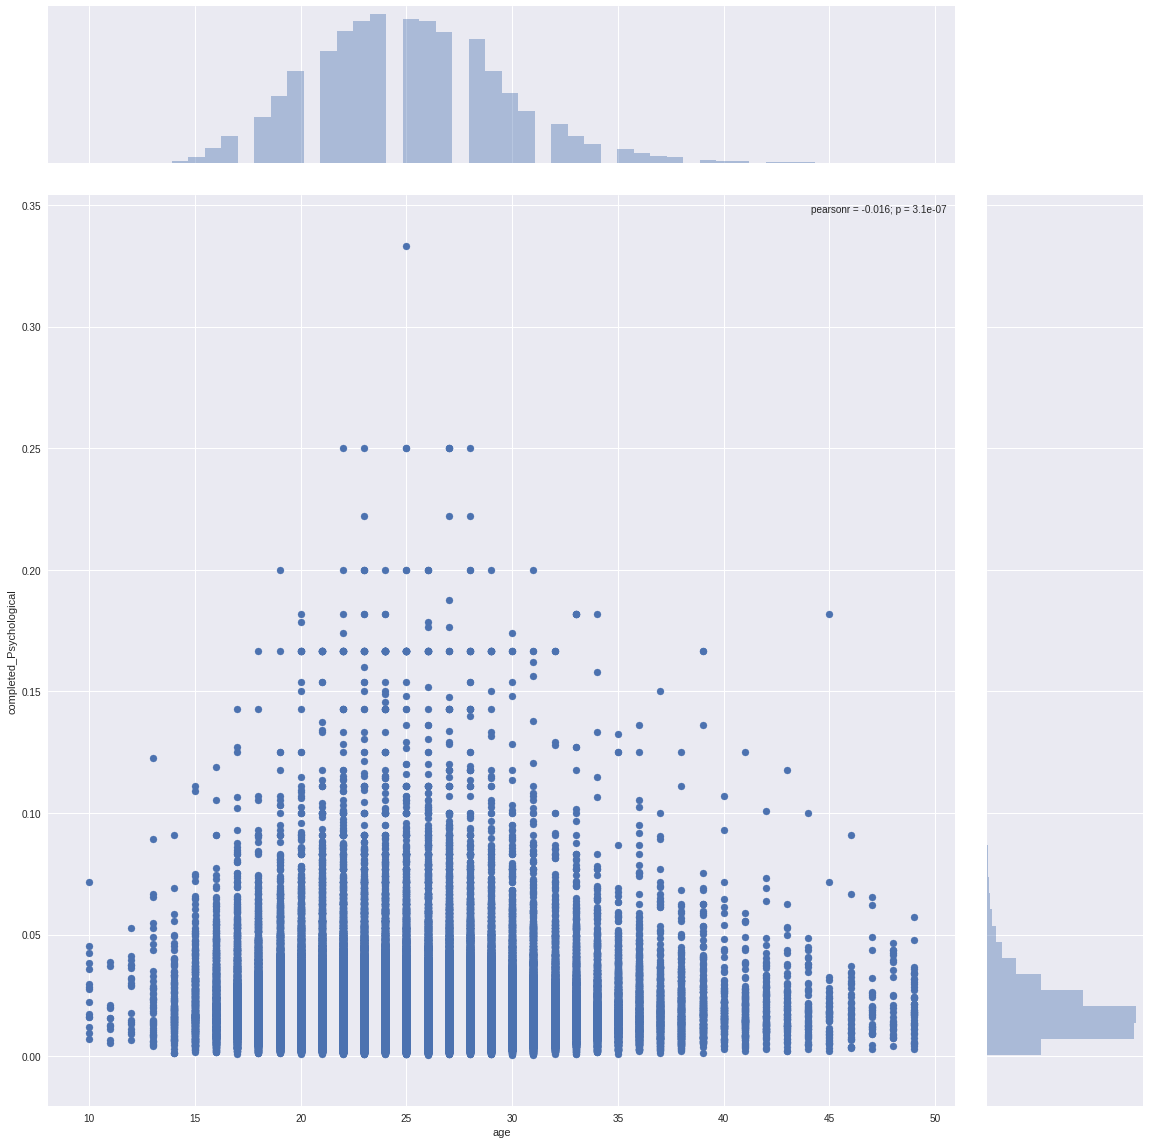

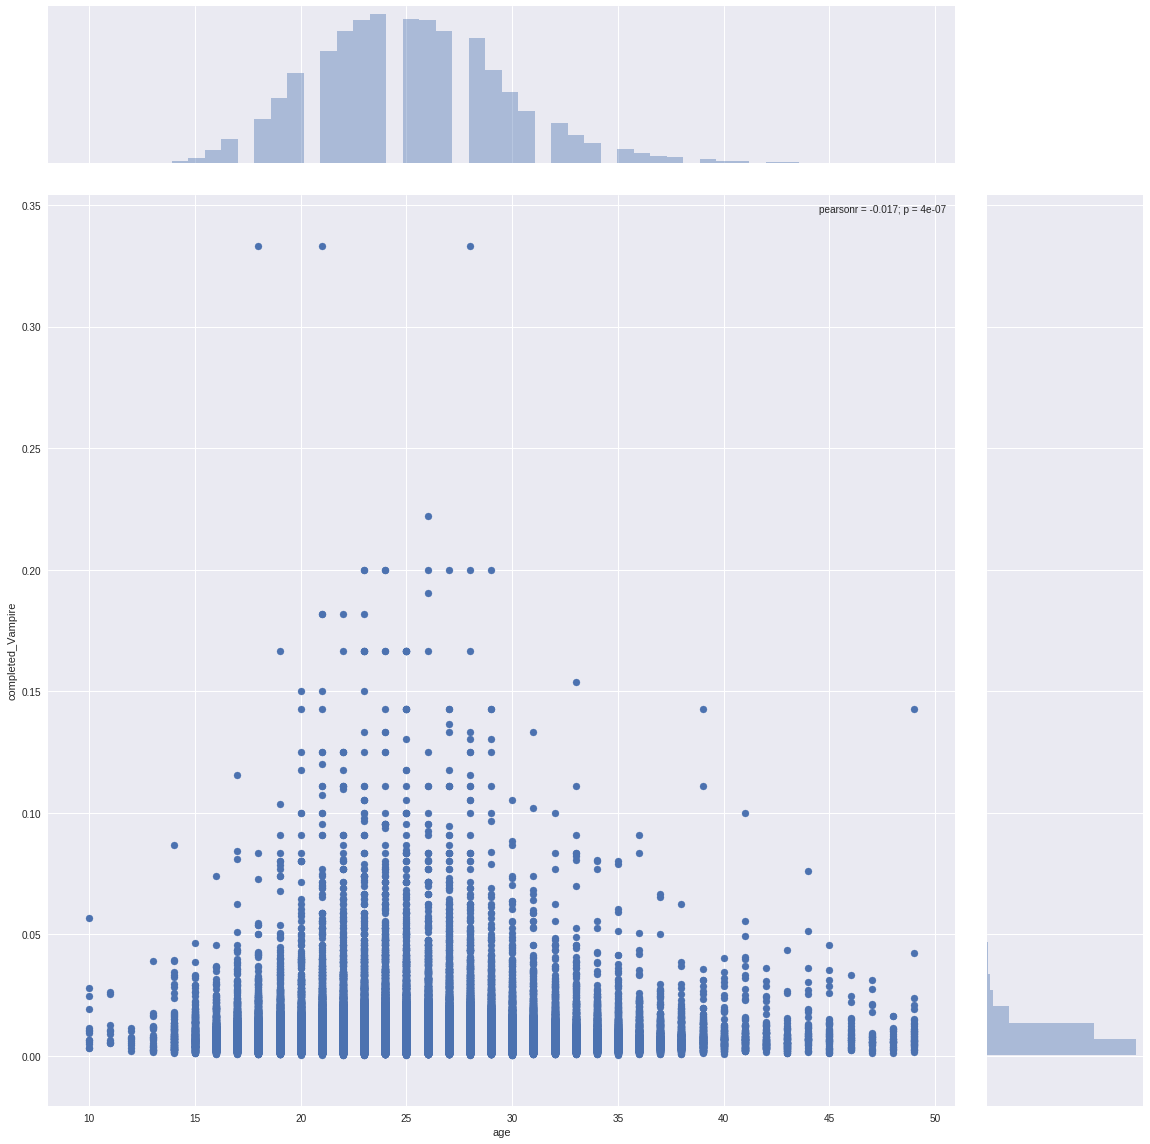

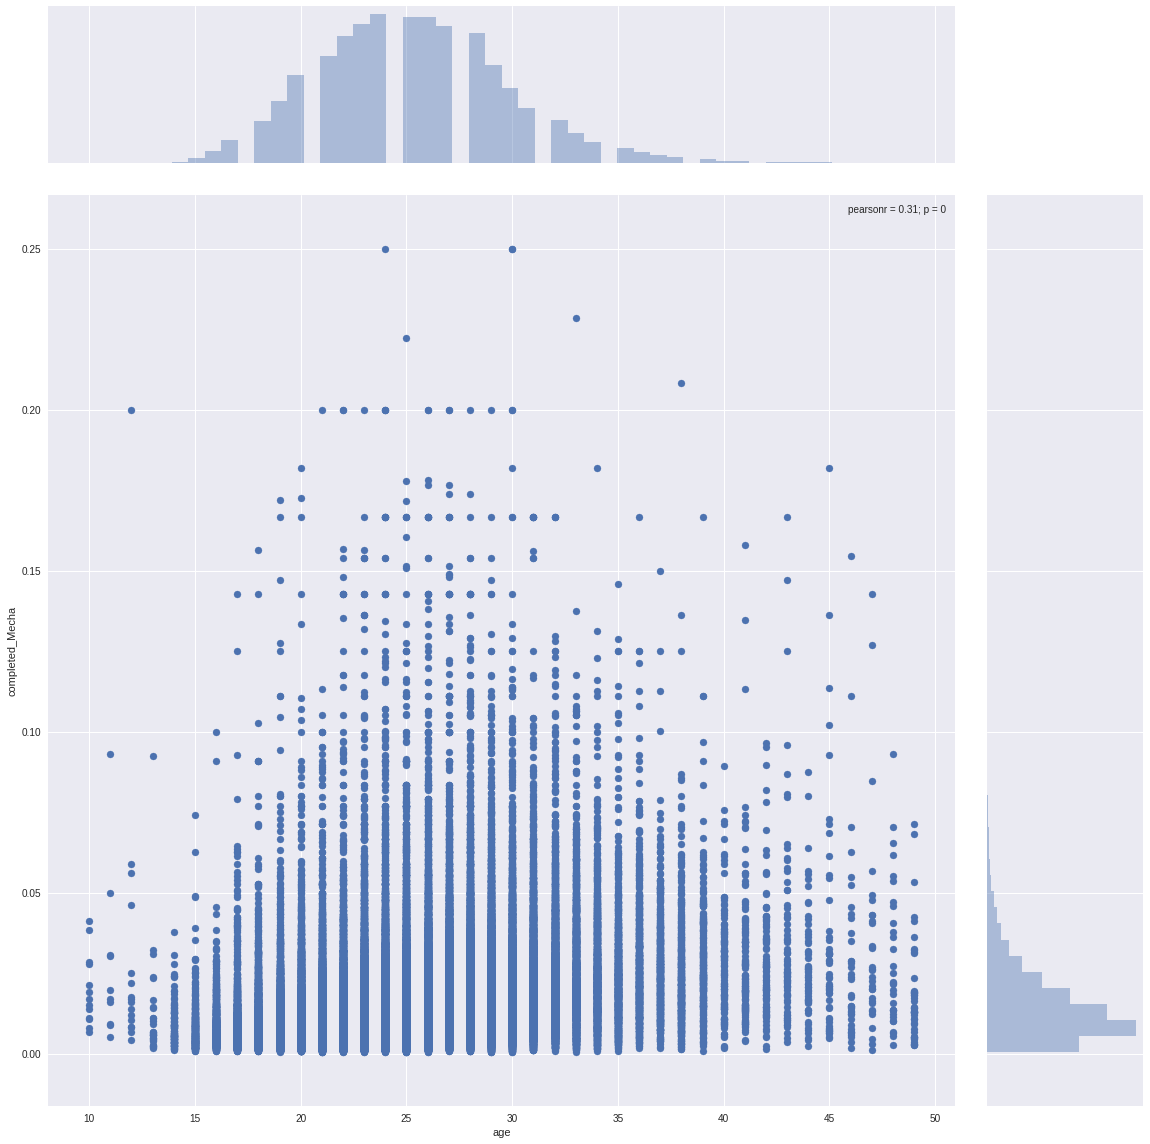

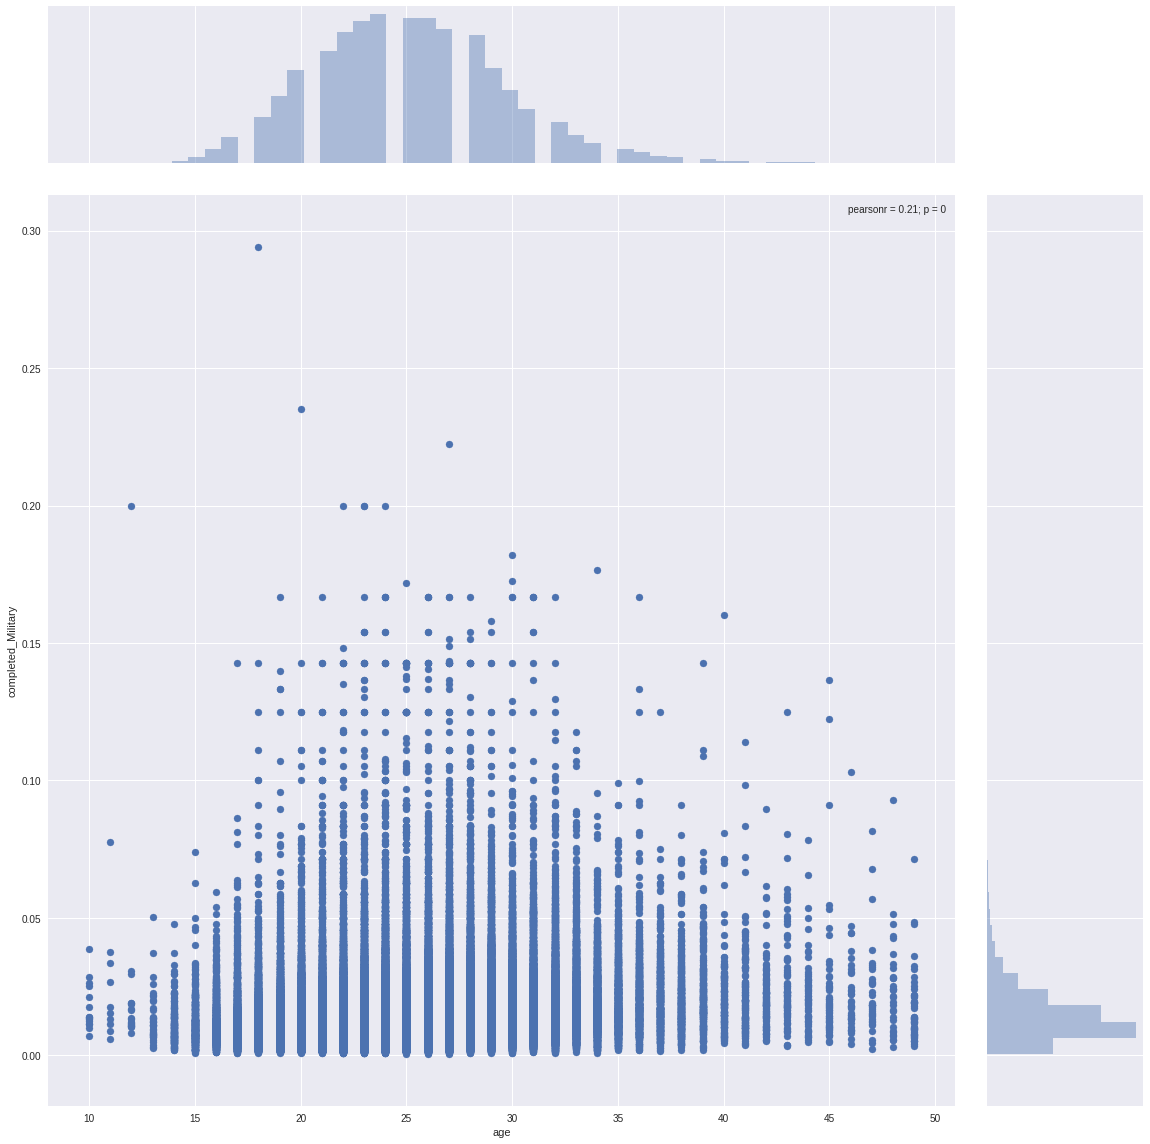

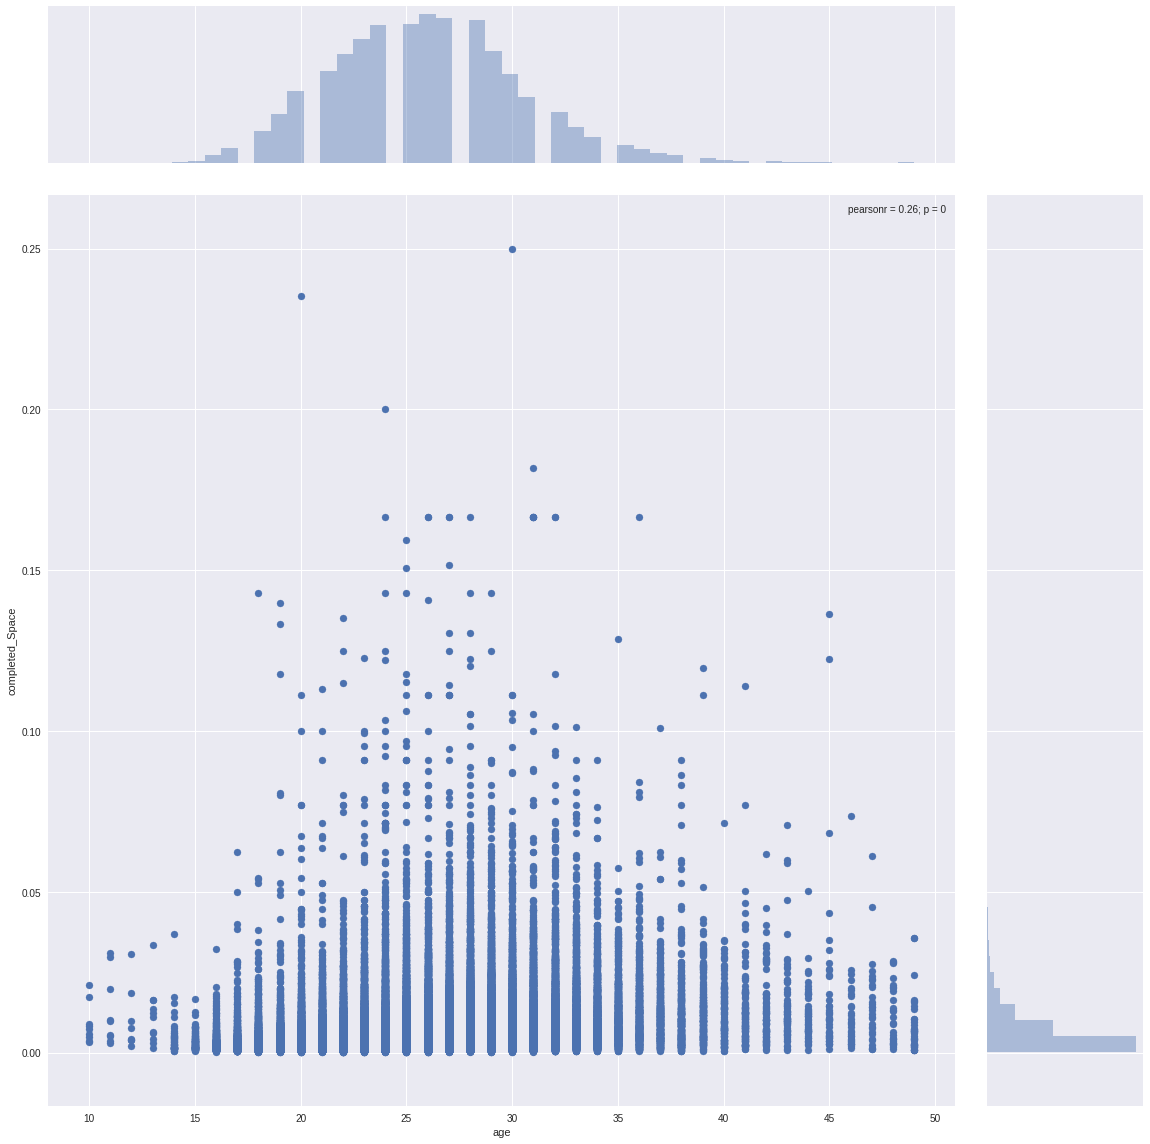

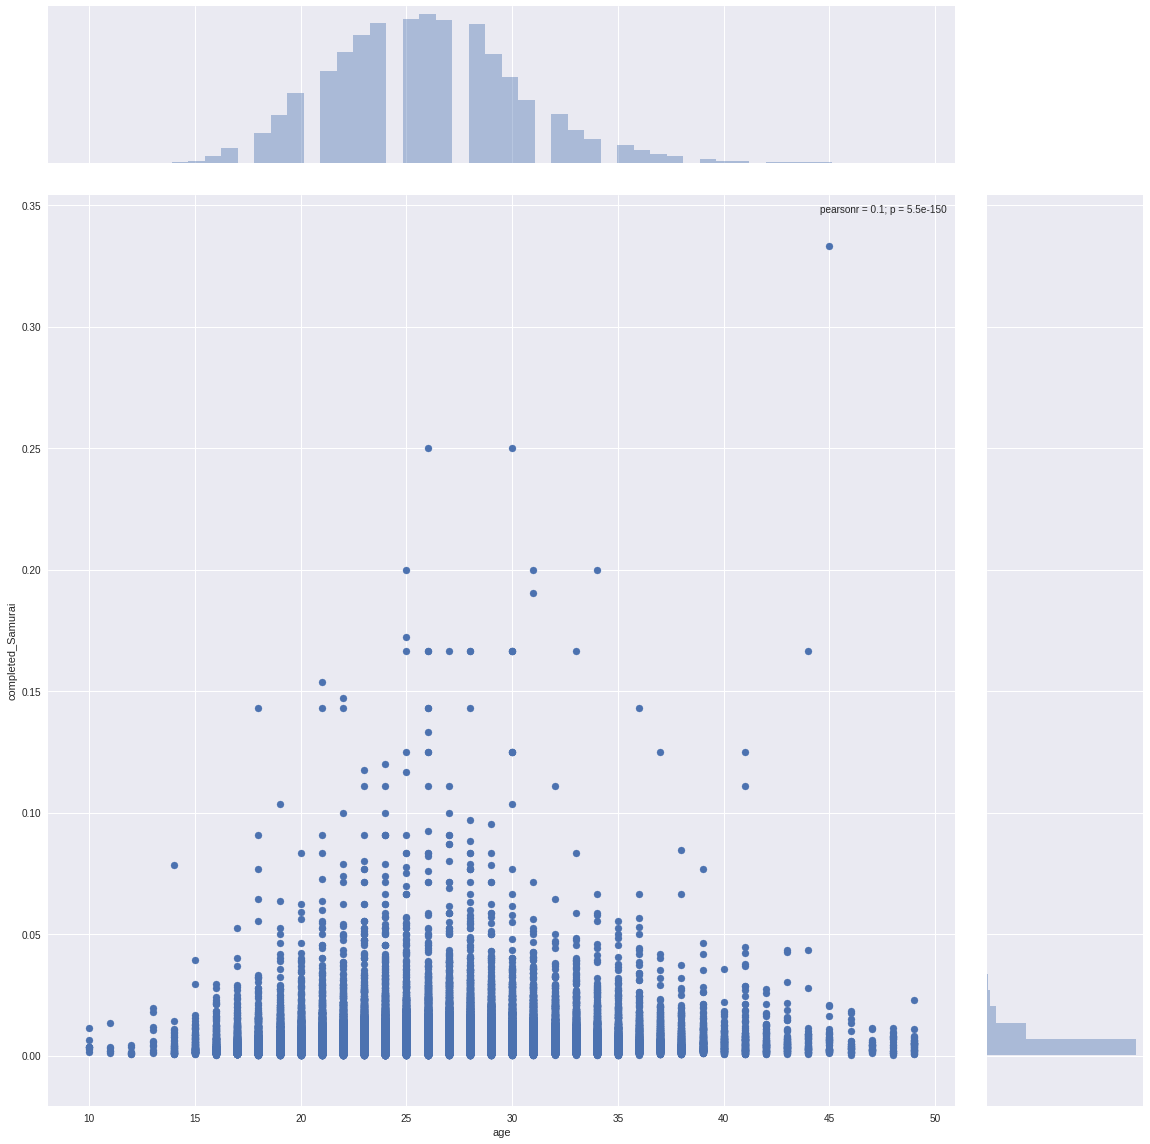

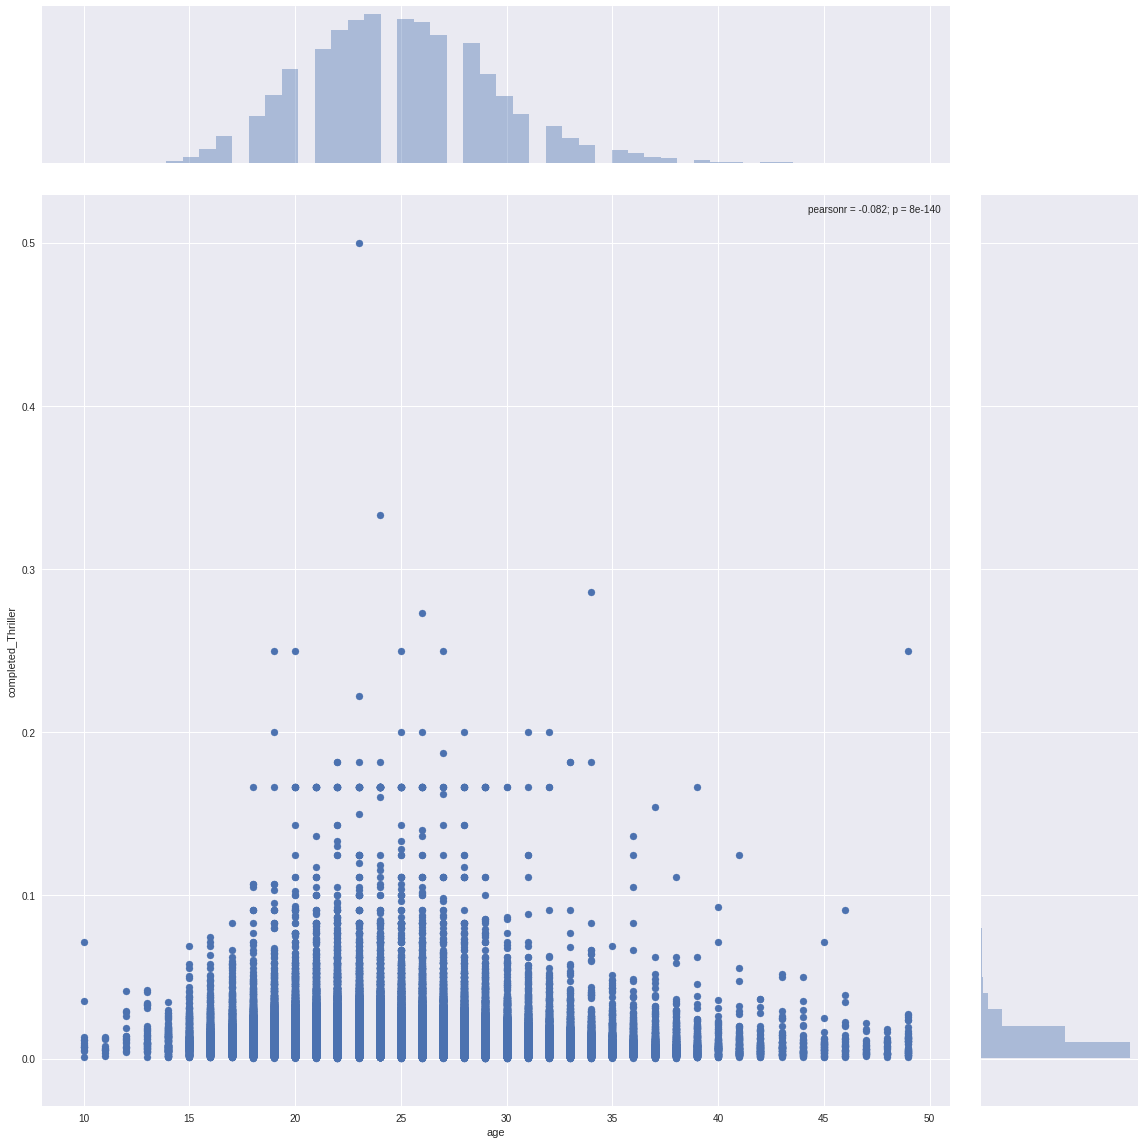

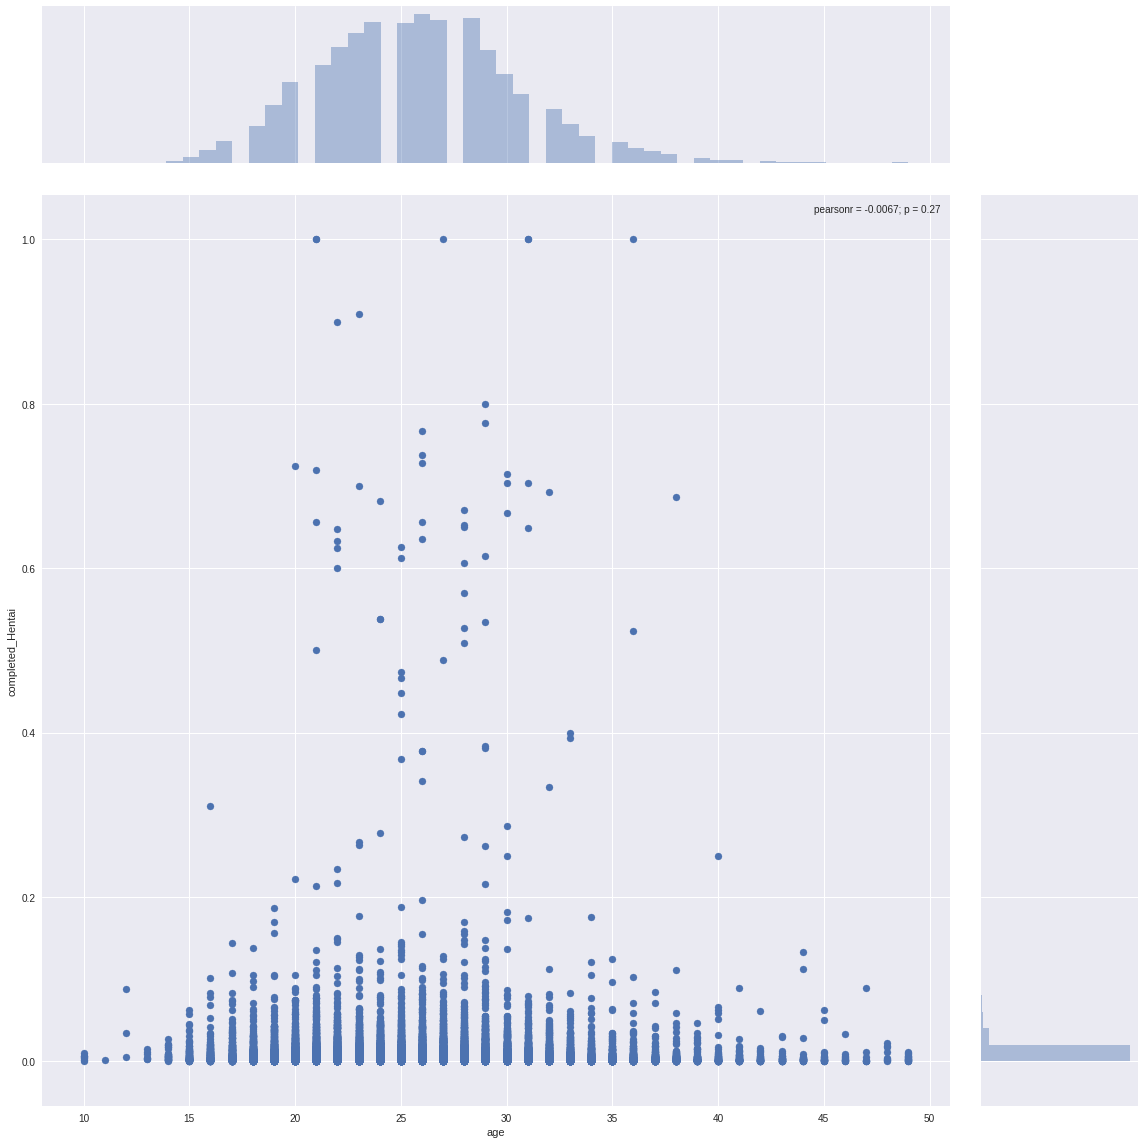

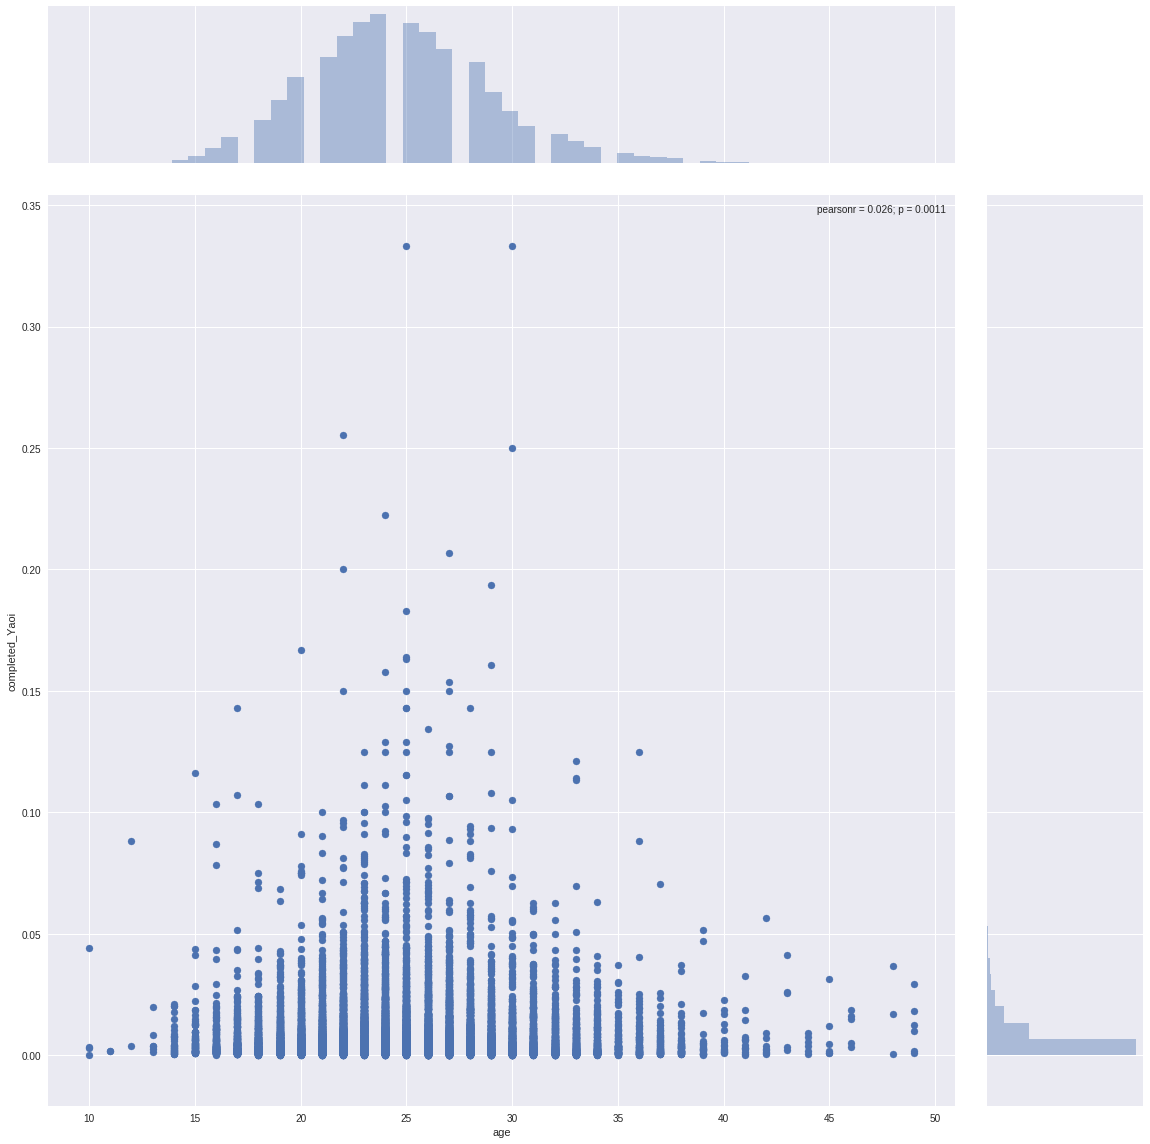

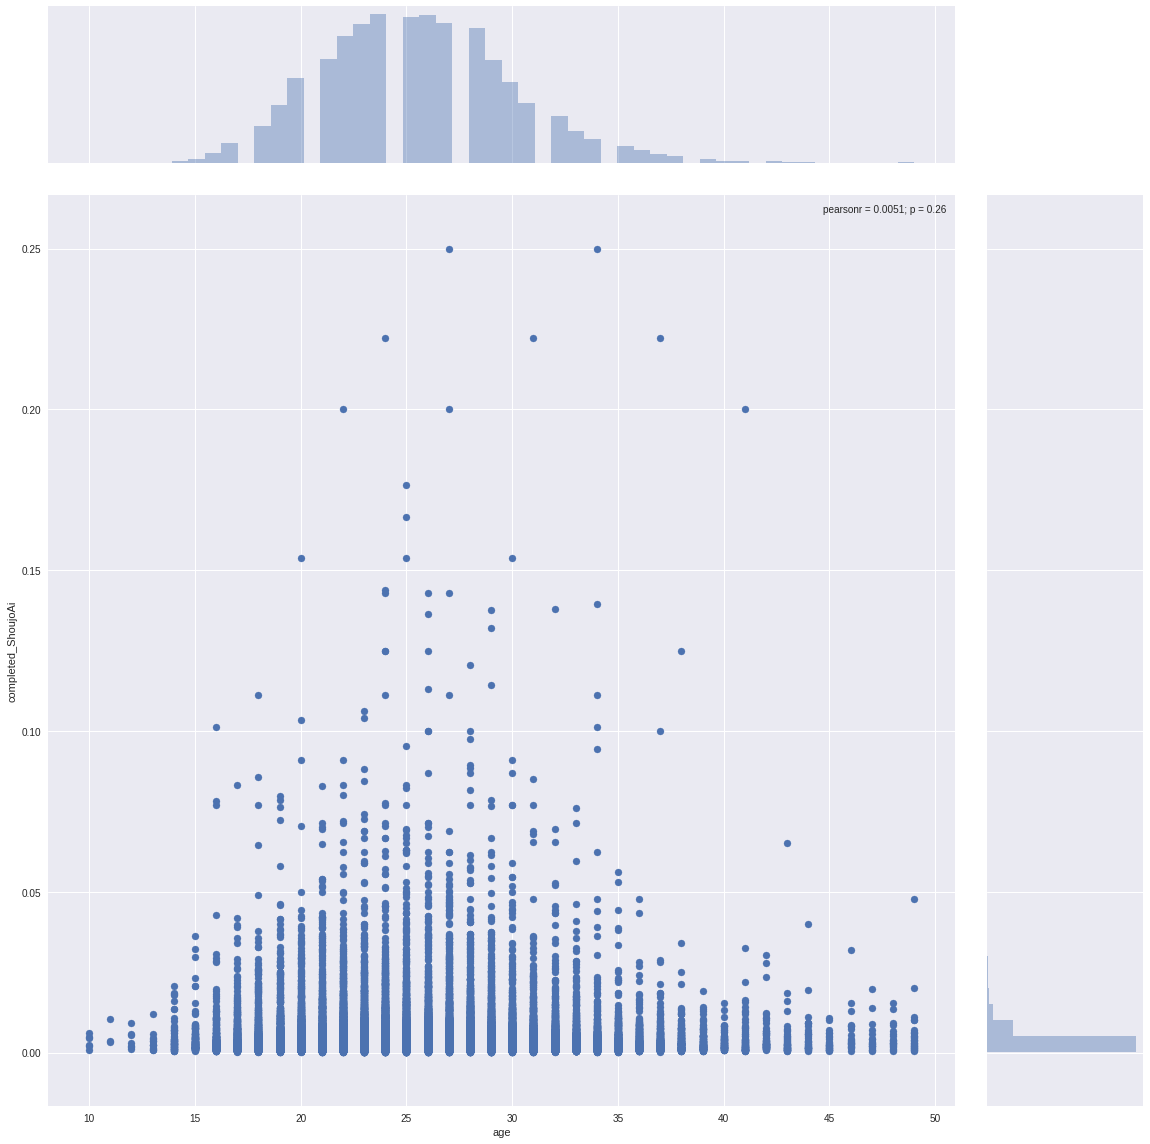

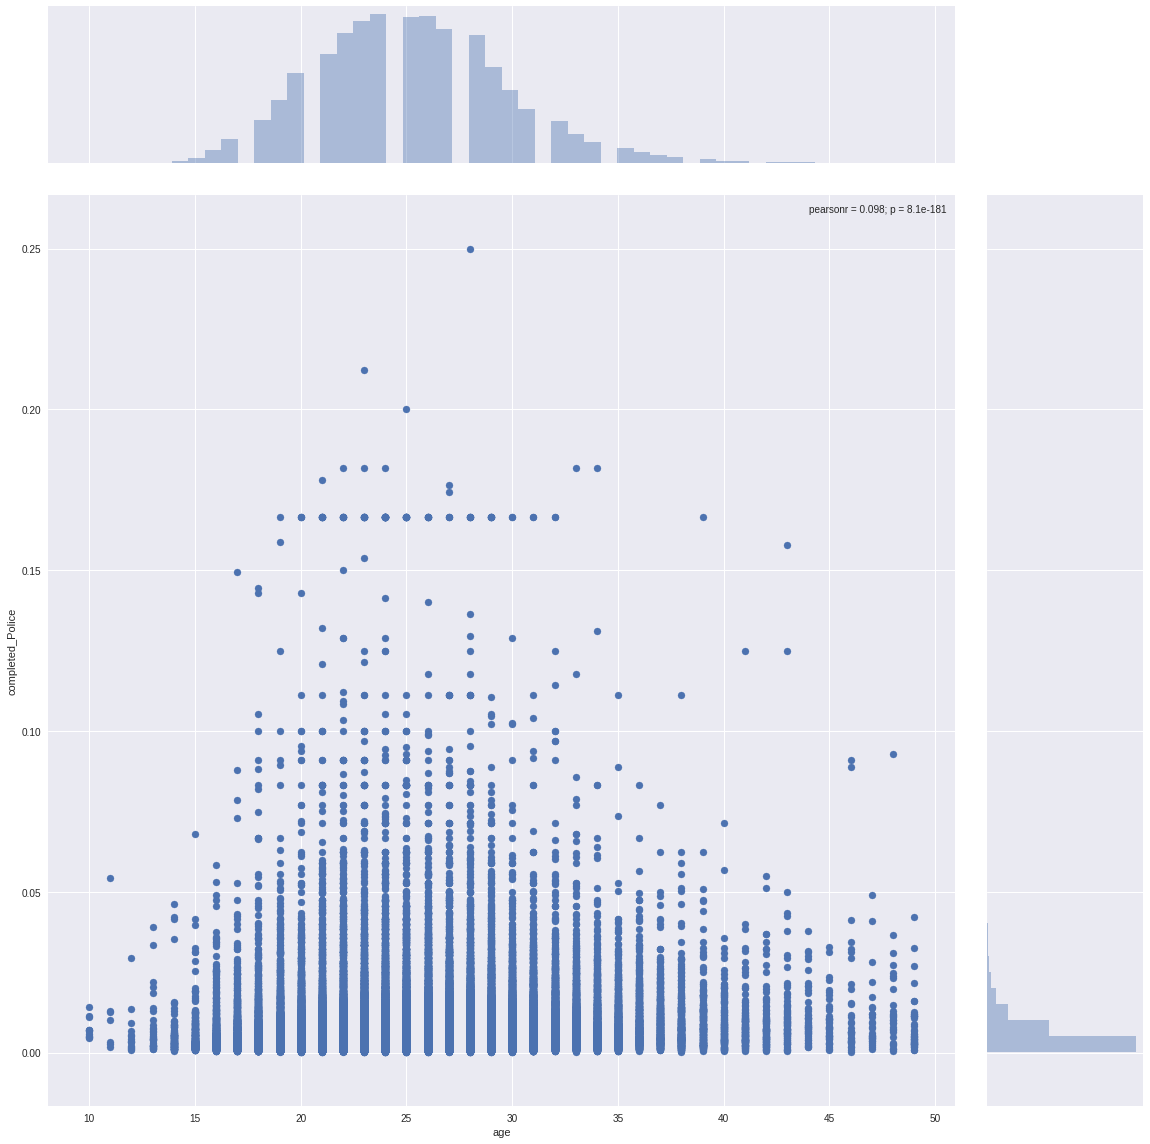

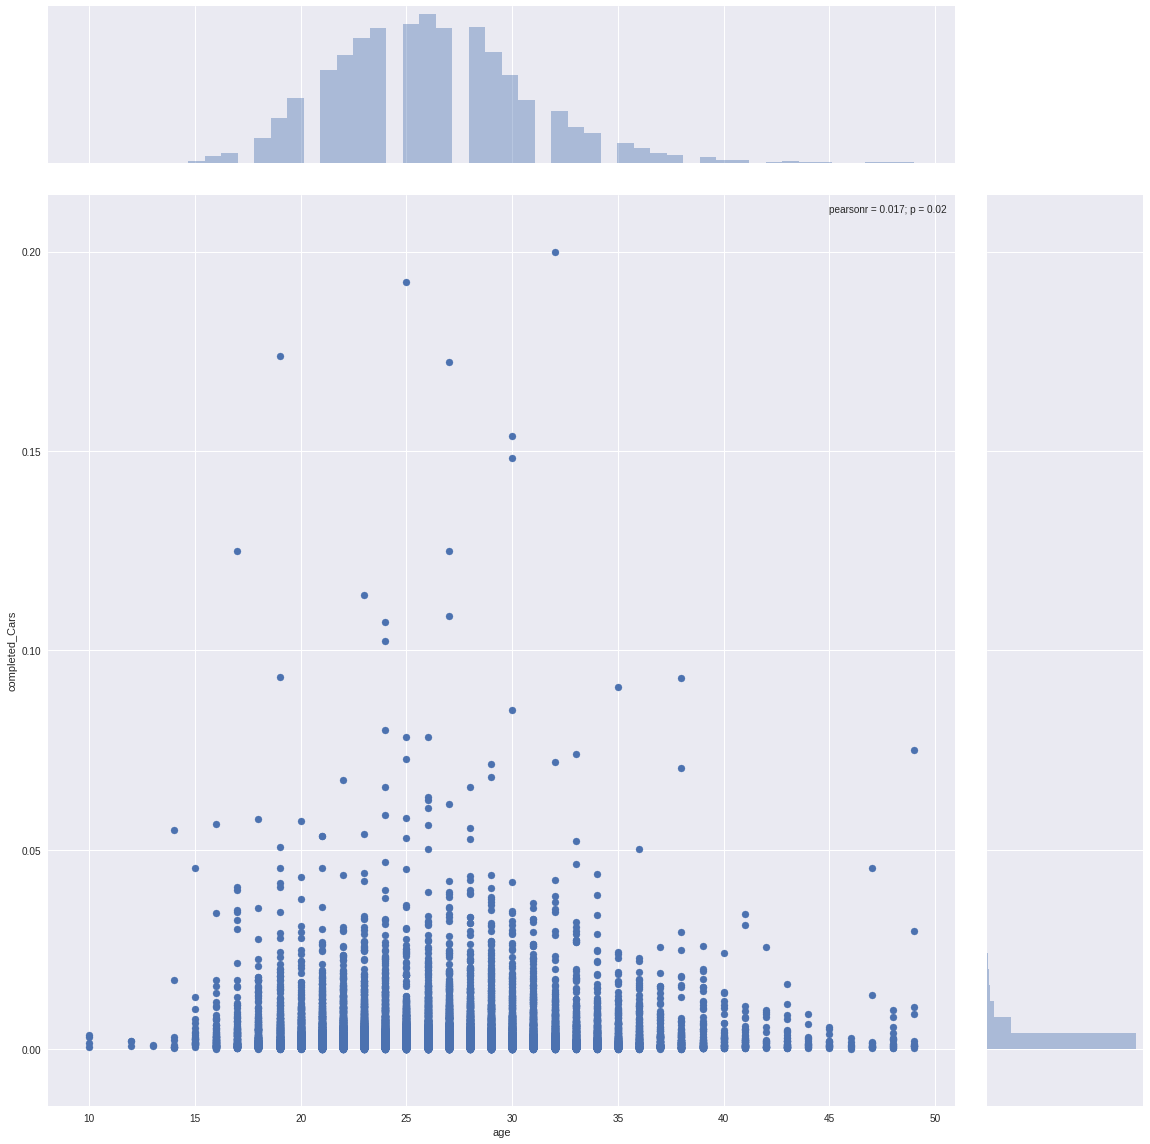

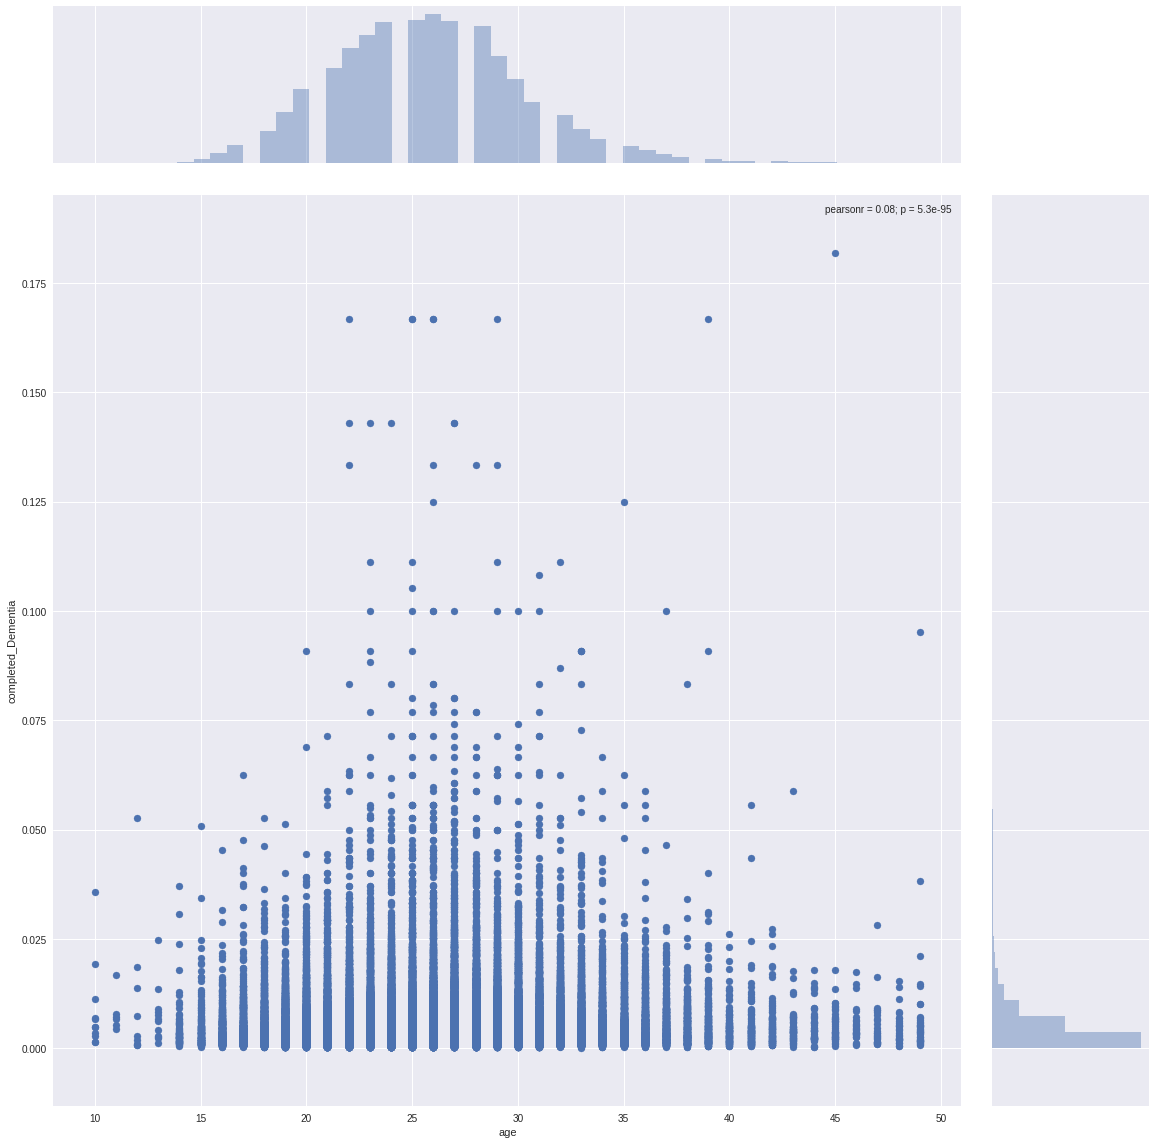

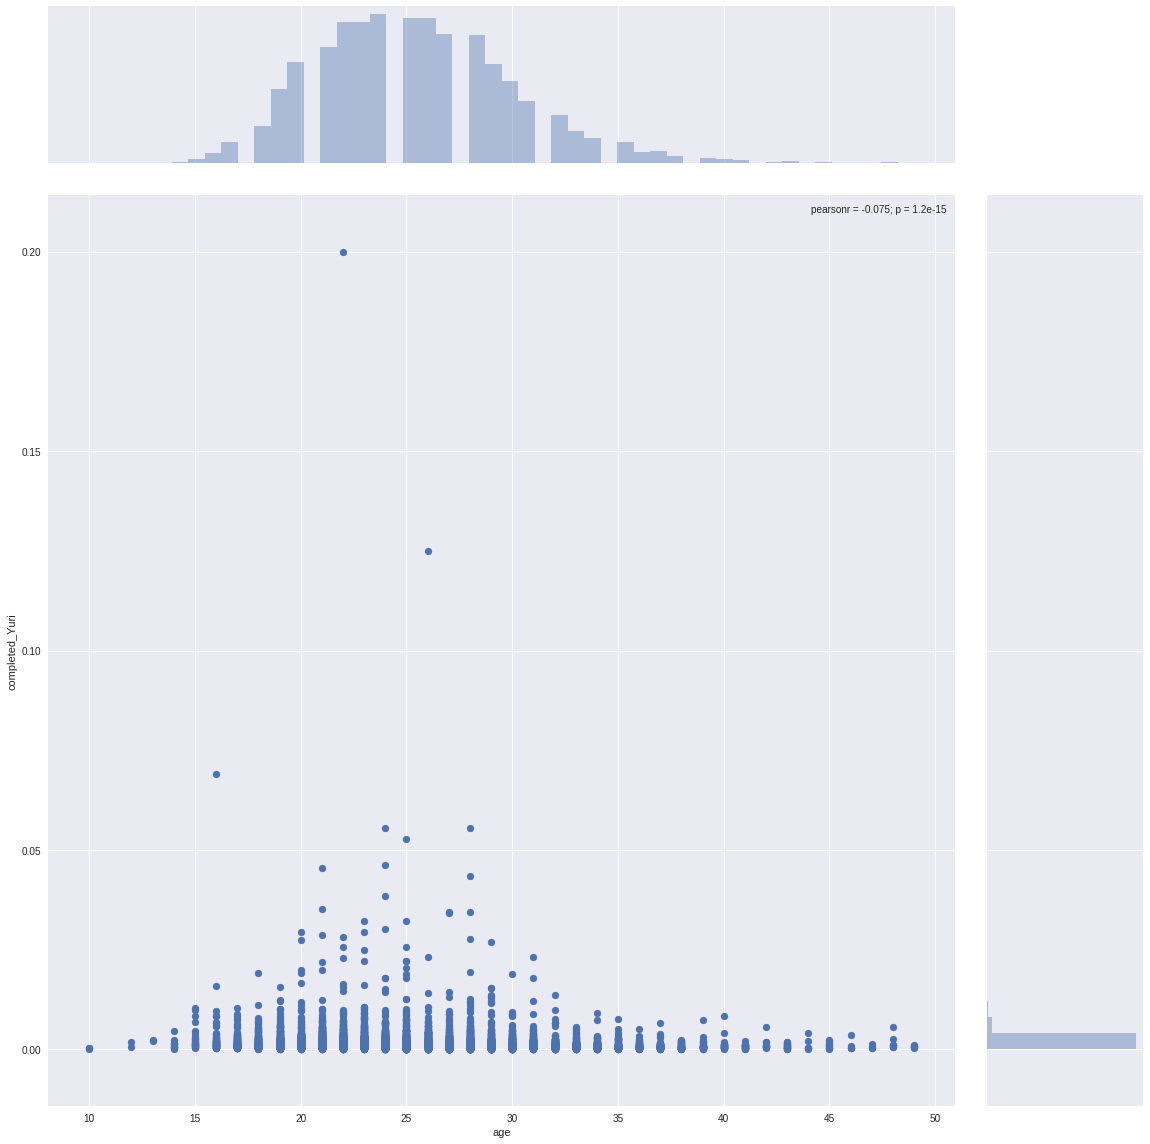

In [34]:
for genre in completed_columns:
    sns.jointplot(x='age', y=genre, data=users_ages_completed, size=16)
    plt.show()

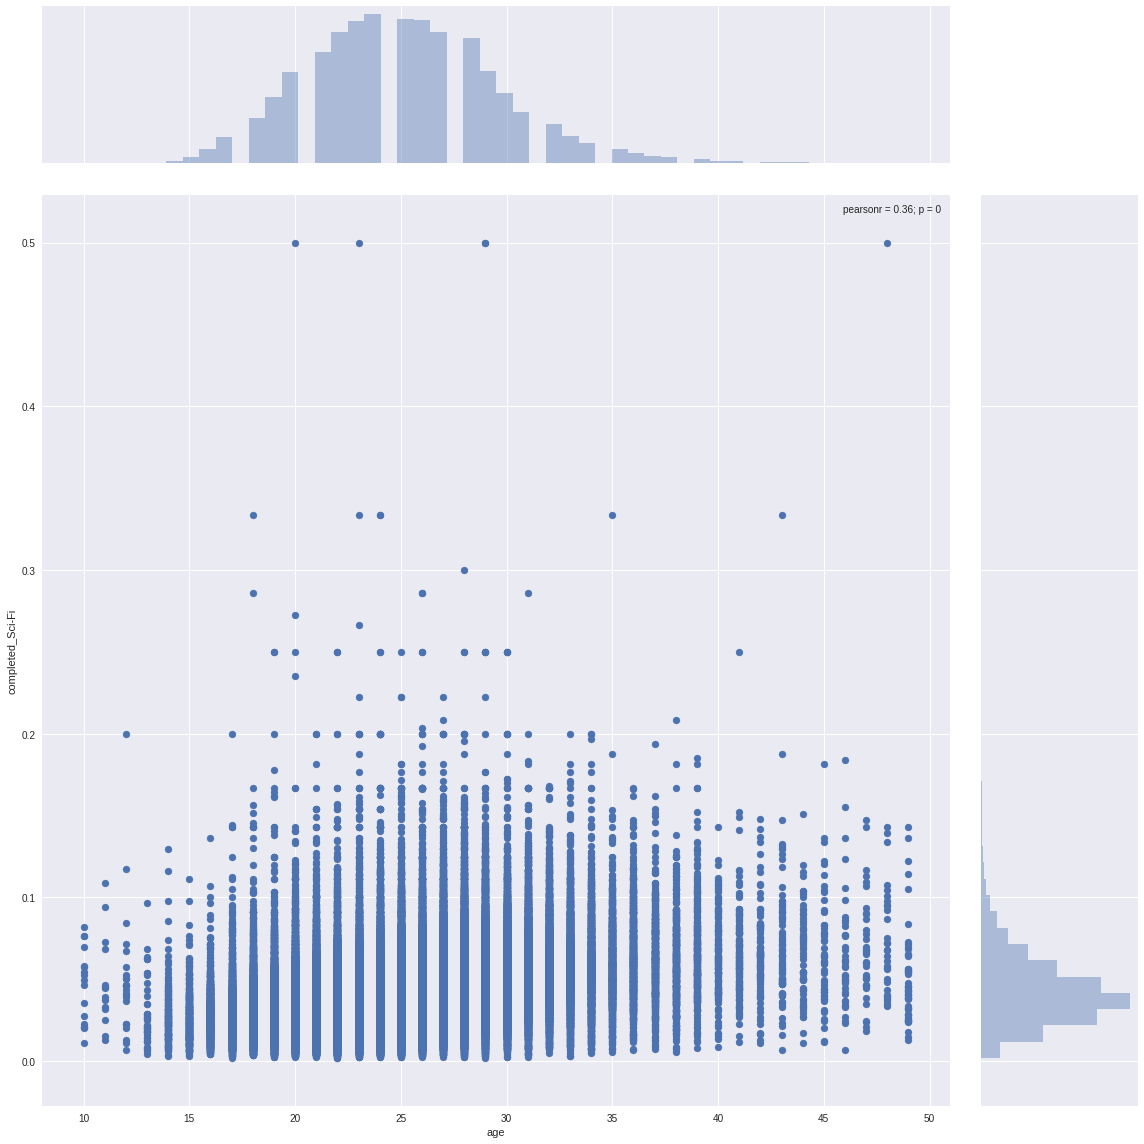

In [35]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='scatter')

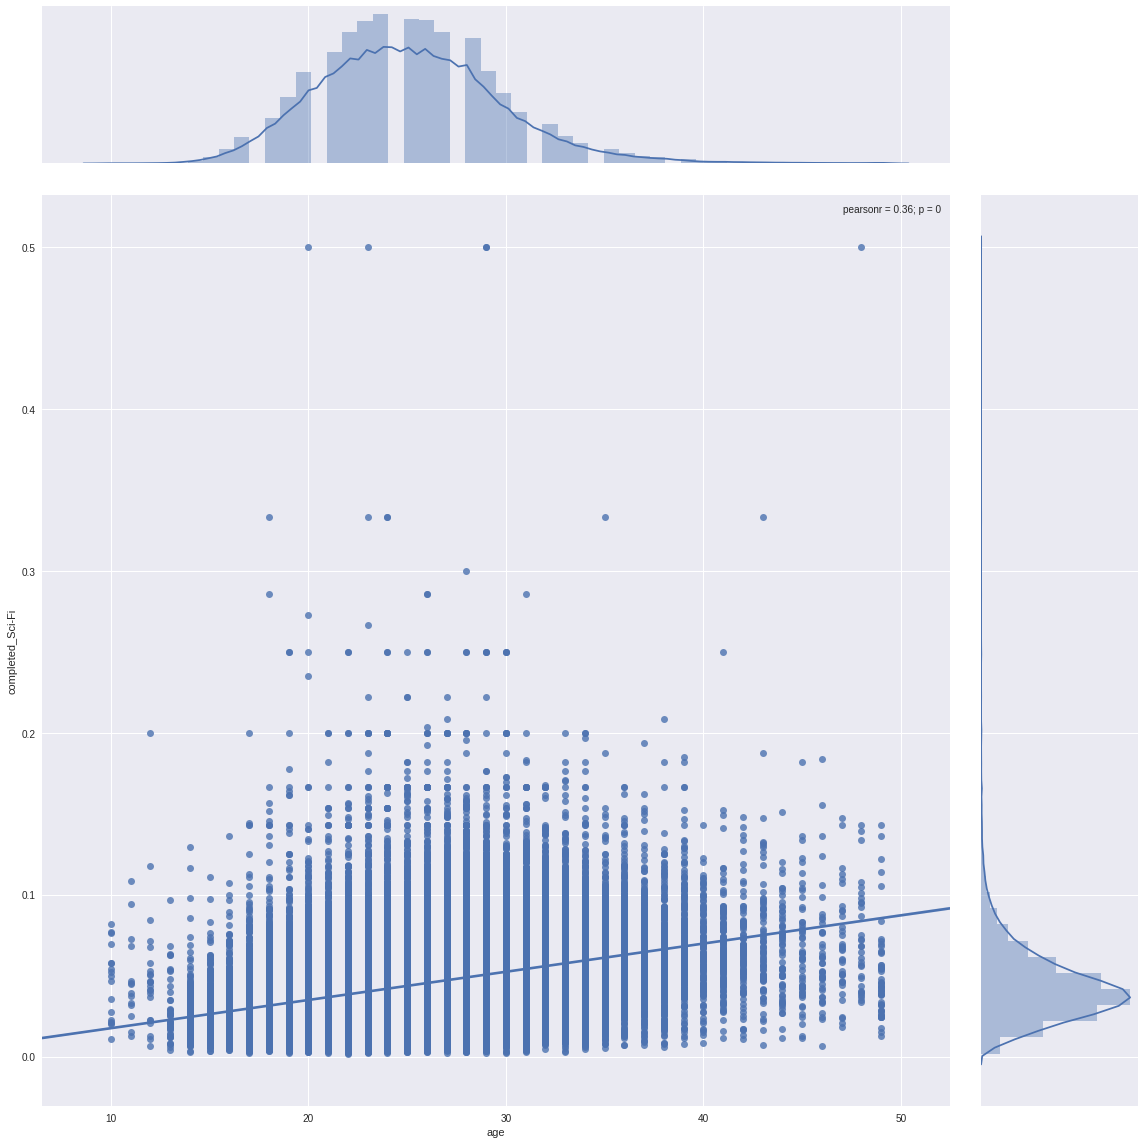

In [36]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='reg')

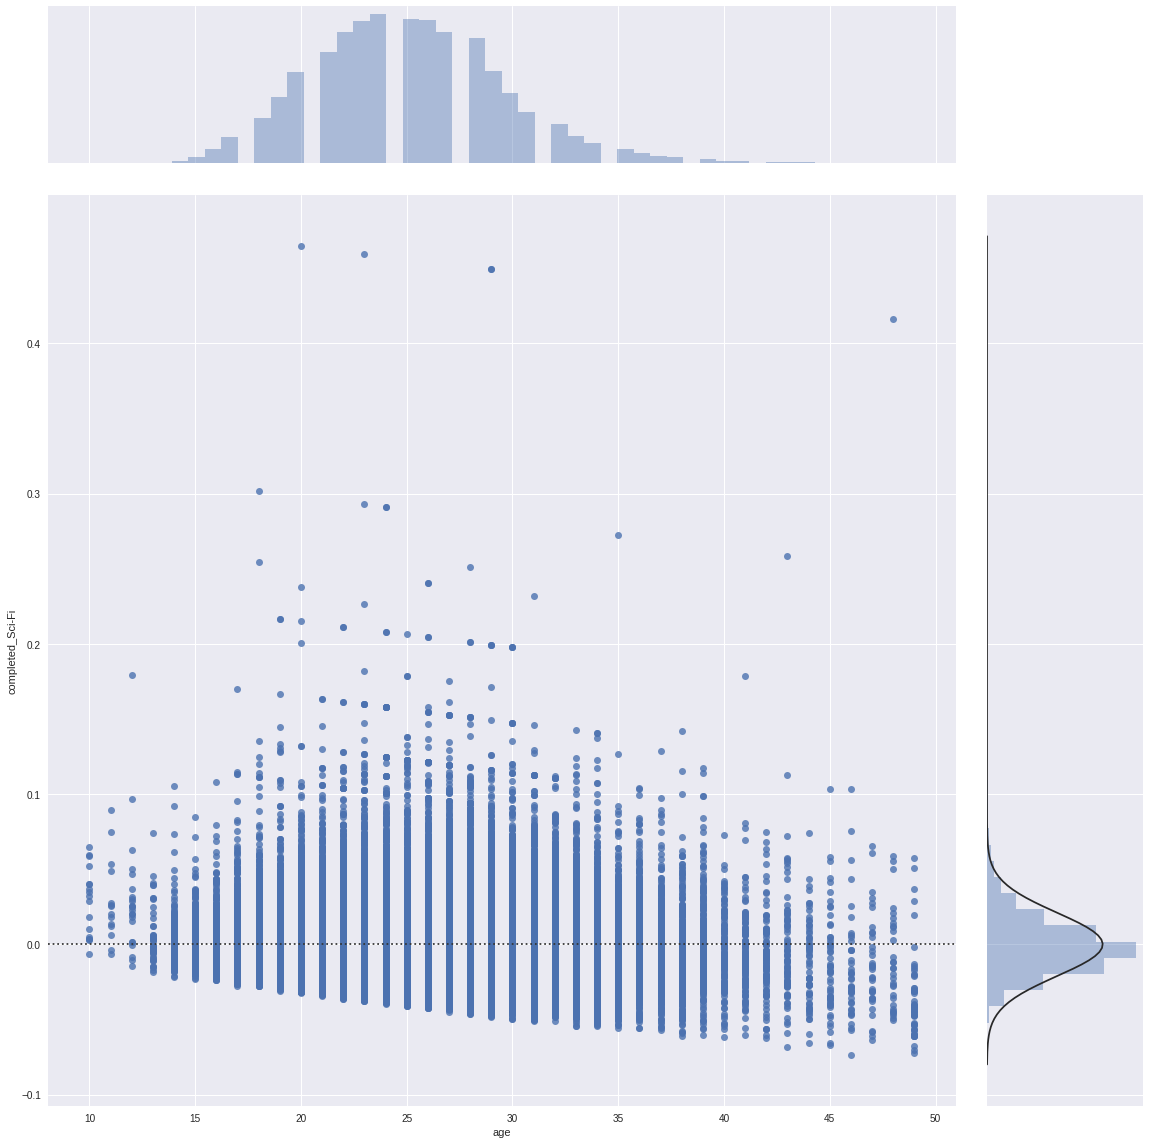

In [37]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='resid')

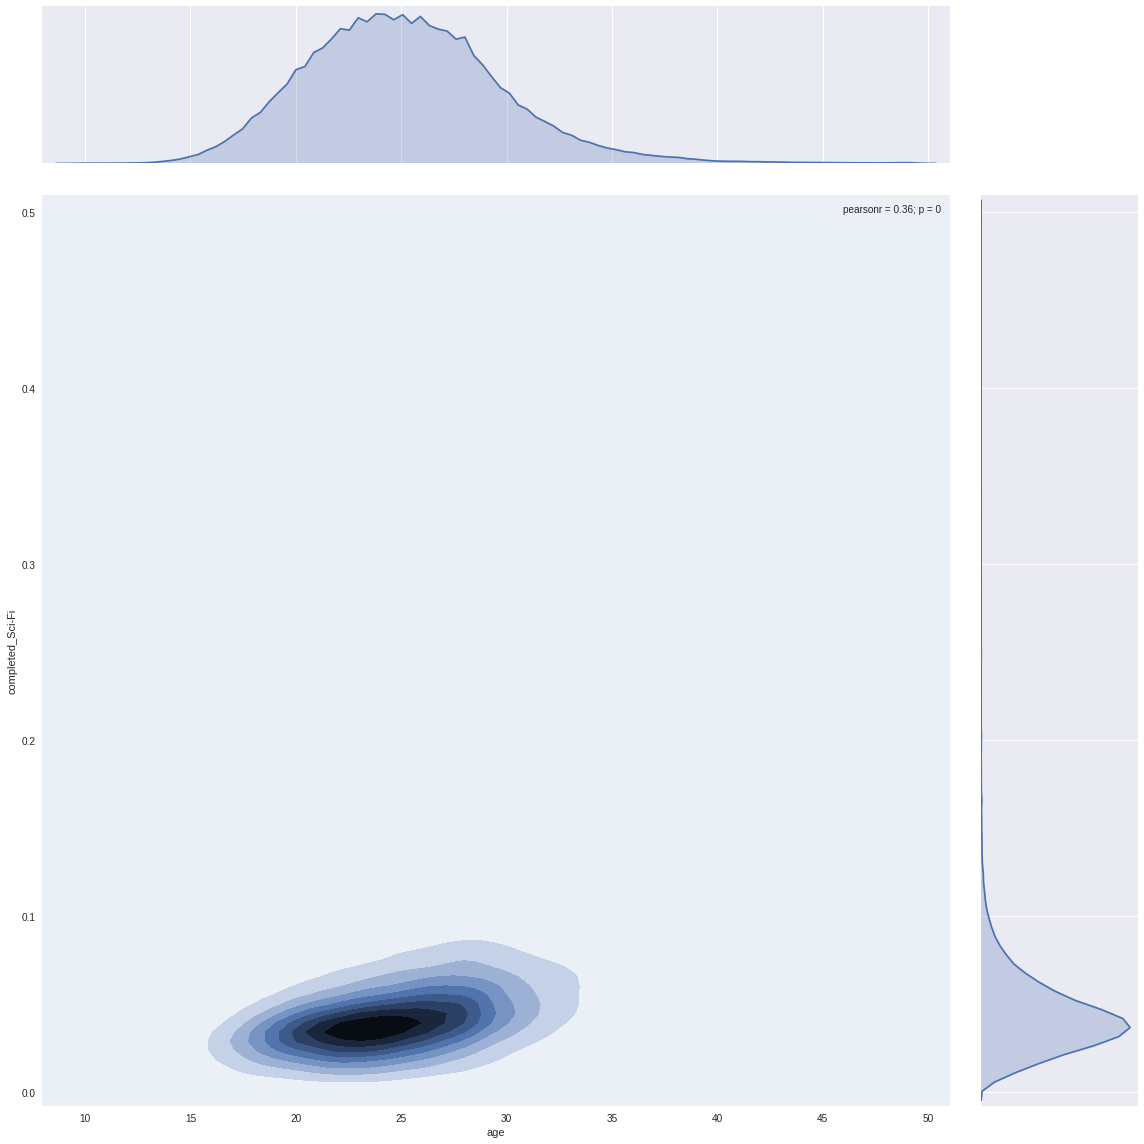

In [38]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='kde')

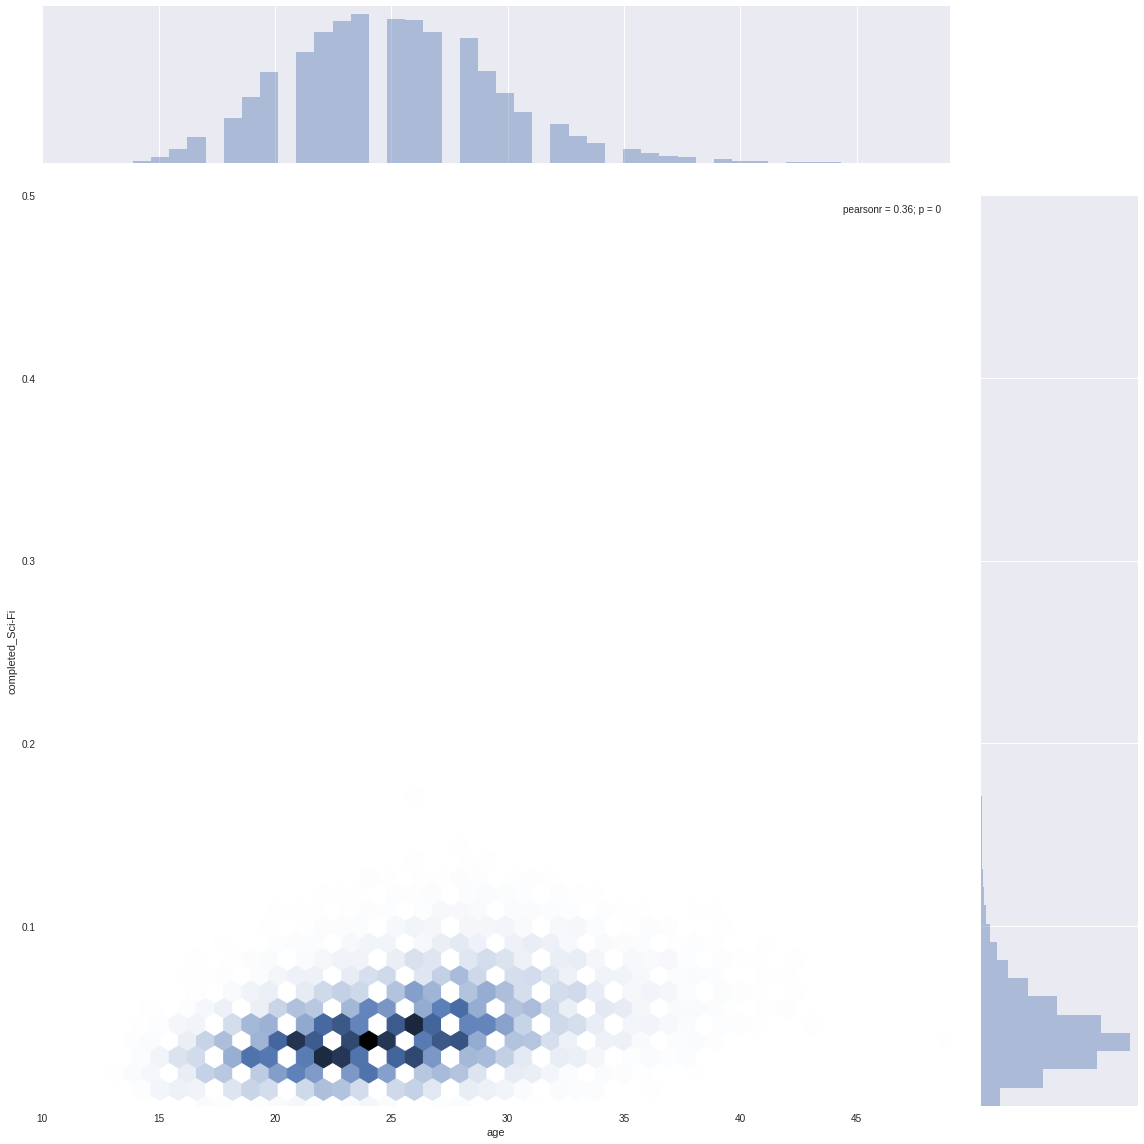

In [39]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16, kind='hex')

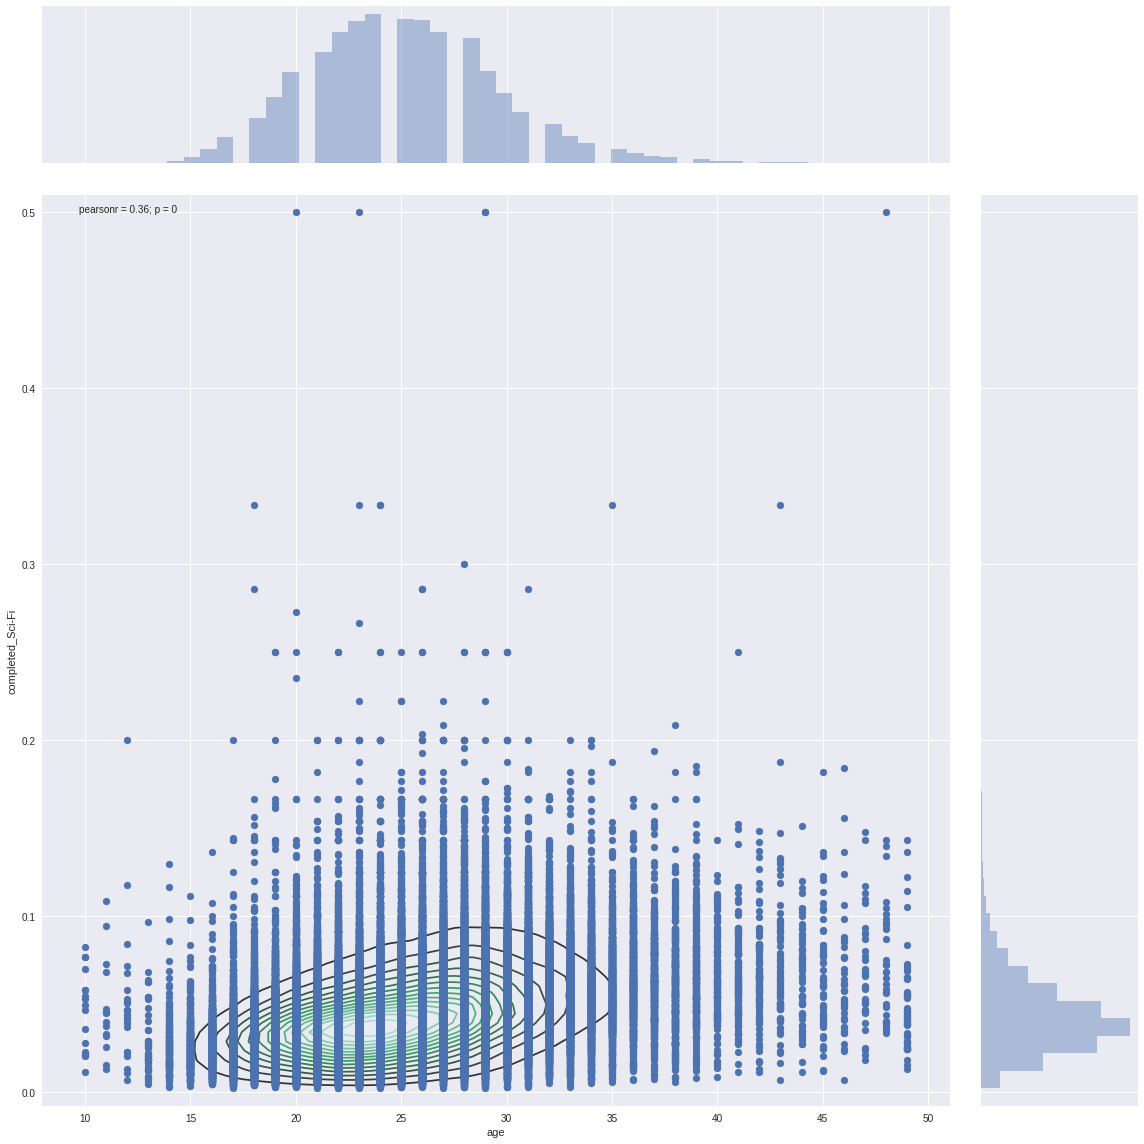

In [40]:
sns.jointplot(x='age', y='completed_Sci-Fi', data=users_ages_completed, size=16).plot_joint(sns.kdeplot, zorder=0, n_levels=20)

In [41]:
# entropy describes how many information it contains. Uniform distribution has highest entropy, dirac distribution lowest. 
# Lower entropy of genre means higher dependency on age
ages_genres[completed_columns].fillna(0).apply(entropy).sort_values()
# shows genres sorted by their dependency on age

completed_Yaoi             3.505824
completed_Hentai           3.548476
completed_Cars             3.570432
completed_Yuri             3.579103
completed_Space            3.600339
completed_Mecha            3.612297
completed_Kids             3.628315
completed_Game             3.637393
completed_Samurai          3.640120
completed_Police           3.643334
completed_Josei            3.647331
completed_Sci-Fi           3.647991
completed_ShounenAi        3.649455
completed_Military         3.657138
completed_Music            3.658333
completed_Dementia         3.660213
completed_School           3.662624
completed_Sports           3.669546
completed_Thriller         3.669823
completed_Shoujo           3.672210
completed_Harem            3.672955
completed_Historical       3.673158
completed_ShoujoAi         3.674394
completed_Parody           3.675738
completed_Vampire          3.676004
completed_SuperPower       3.678974
completed_MartialArts      3.679764
completed_Demons           3

In [42]:
arr = np.ones(ages_genres.index.size)
entropy(arr / arr.sum())

3.6888794541139363

In [43]:
dependent_genres = ages_genres[completed_columns].fillna(0).apply(entropy).sort_values().index[0:6]

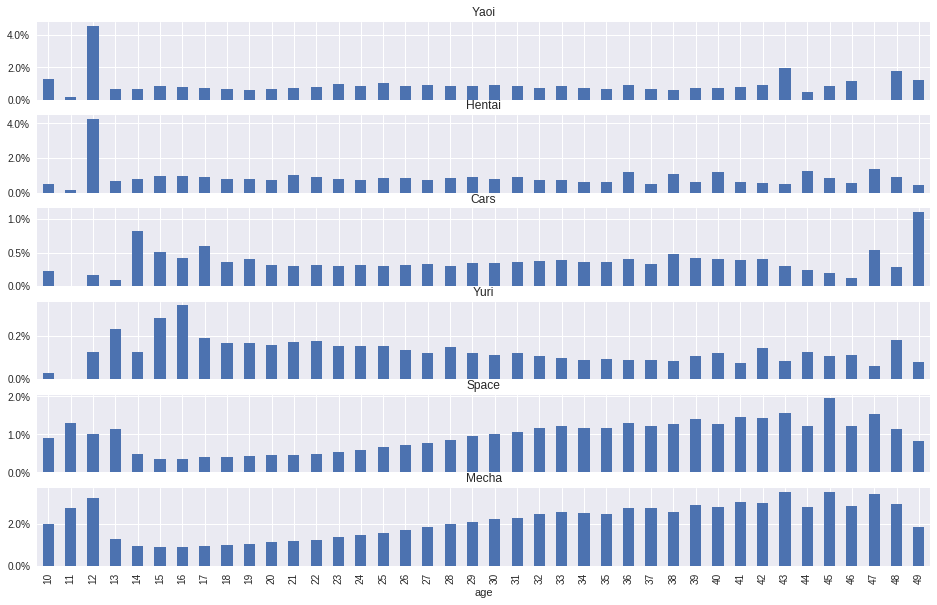

In [44]:
fig, ax = plt.subplots(len(dependent_genres), 1, sharex=True, figsize=(16, 10))
for i, genre in enumerate(dependent_genres):
    ages_genres[genre].plot(kind='bar', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

In [45]:
users_genders_completed = users_completed.join(users['gender'])
genders_genres = users_genders_completed.groupby('gender').mean()

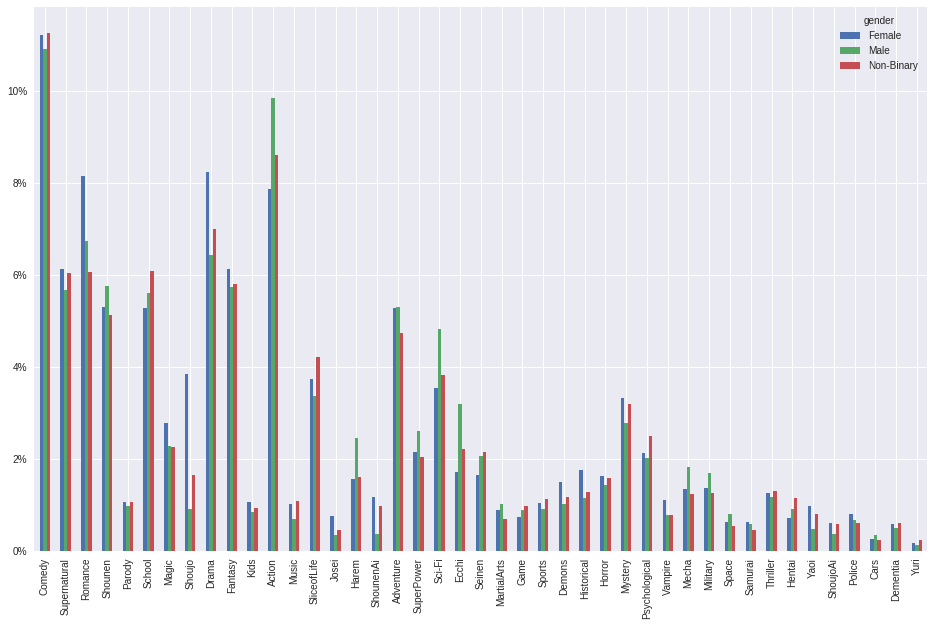

In [46]:
genders_genres.T.plot(kind='bar', figsize=(16, 10))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda y, _: genders_genres.columns[y].replace('completed_', '')))
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [47]:
genders_genres[completed_columns].fillna(0).apply(entropy).sort_values()

completed_Shoujo           0.931019
completed_ShounenAi        1.000696
completed_Josei            1.045204
completed_Yaoi             1.055412
completed_Ecchi            1.065970
completed_Yuri             1.069710
completed_ShoujoAi         1.073579
completed_Harem            1.075489
completed_Hentai           1.078873
completed_Music            1.079429
completed_Cars             1.080235
completed_Historical       1.081688
completed_Mecha            1.083212
completed_Vampire          1.083764
completed_Demons           1.085277
completed_MartialArts      1.086113
completed_Space            1.086852
completed_Sci-Fi           1.089544
completed_Samurai          1.090223
completed_Romance          1.090862
completed_Military         1.090883
completed_Police           1.091546
completed_Seinen           1.091957
completed_Game             1.092236
completed_SuperPower       1.092910
completed_Drama            1.093183
completed_Kids             1.094022
completed_Magic            1

In [48]:
genders_genres[completed_columns].fillna(0).apply(np.var).sort_values(ascending=False)

completed_Shoujo           1.562634e-04
completed_Romance          7.653753e-05
completed_Action           6.780926e-05
completed_Drama            5.720716e-05
completed_Ecchi            3.727980e-05
completed_Sci-Fi           3.055185e-05
completed_Harem            1.687140e-05
completed_ShounenAi        1.172815e-05
completed_SliceofLife      1.161226e-05
completed_School           1.065577e-05
completed_Shounen          7.472252e-06
completed_Adventure        6.924385e-06
completed_Mecha            6.796410e-06
completed_Historical       6.716658e-06
completed_SuperPower       5.910026e-06
completed_Mystery          5.511982e-06
completed_Magic            5.511904e-06
completed_Seinen           4.923939e-06
completed_Yaoi             4.514310e-06
completed_Psychological    4.363203e-06
completed_Demons           4.104106e-06
completed_Supernatural     3.946531e-06
completed_Hentai           3.349972e-06
completed_Military         3.248365e-06
completed_Music            3.125850e-06


In [49]:
arr = np.ones(genders_genres.index.size)
entropy(arr / arr.sum())

1.0986122886681096

In [50]:
# variance is better than entropy now
dependent_genres = genders_genres[completed_columns].fillna(0).apply(np.var).sort_values(ascending=False).index[0:12]

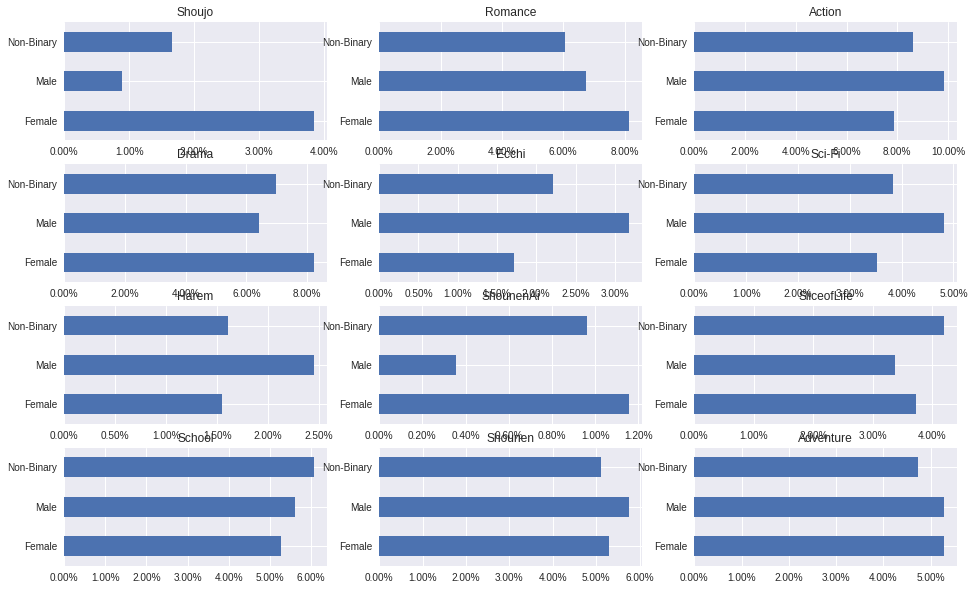

In [51]:
sqrt_num = np.ceil(np.sqrt(len(dependent_genres))).astype('int')
#fig, ax = plt.subplots(sqrt_num, sqrt_num, figsize=(16, 10), squeeze=False)
fig, ax = plt.subplots(4, 3, figsize=(16, 10), squeeze=False)
ax = ax.flatten()
for i, genre in enumerate(dependent_genres):
    genders_genres[genre].plot(kind='barh', ax=ax[i], title=genre.replace('completed_', ''))
    ax[i].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
    ax[i].set_ylabel('')


In [52]:
### and now binning ages into equi-sized bins
age_bins, intervals = pd.qcut(users['age'], 10, retbins=True)
intervals

array([10., 20., 21., 23., 24., 25., 26., 27., 29., 31., 49.])

In [53]:
age_bins.value_counts()
# these intervals suck, they fit 10-20 into one interval

(21.0, 23.0]     17871
(9.999, 20.0]    16448
(27.0, 29.0]     13788
(23.0, 24.0]      9760
(24.0, 25.0]      9379
(25.0, 26.0]      9231
(31.0, 49.0]      8927
(26.0, 27.0]      8383
(29.0, 31.0]      7690
(20.0, 21.0]      7234
Name: age, dtype: int64

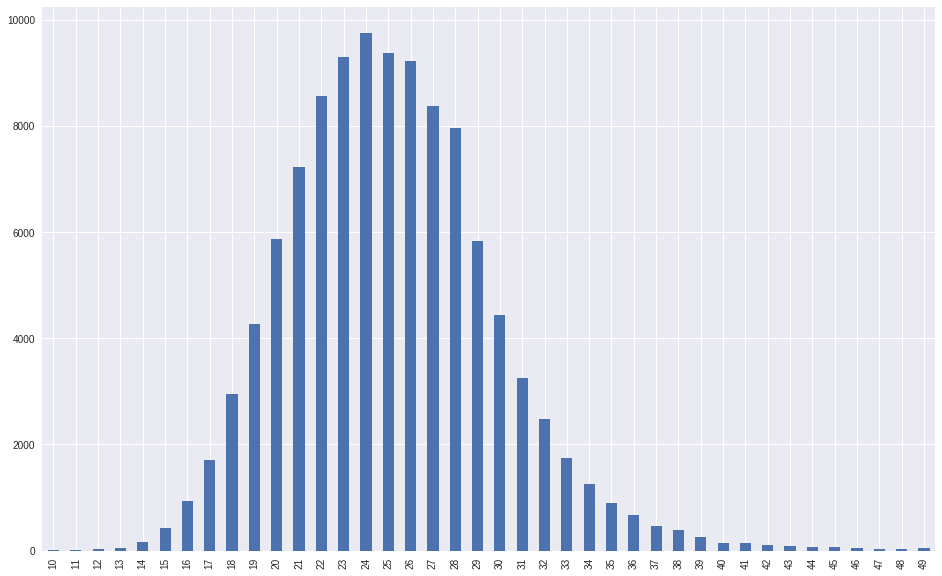

In [54]:
users_ages_completed['age'].value_counts().sort_index().plot(kind='bar', figsize=(16, 10))

In [90]:
bins = [9, 14, 17, 20, 23, 26, 30, 40, 50]
pd.cut(users_ages_completed['age'], bins, right=True).value_counts()
# hand-crafted by intuition

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age, dtype: int64

In [91]:
users_ages_completed['age_bin'] = pd.cut(users_ages_completed['age'], bins, right=True).astype(str)

In [92]:
users_ages_completed['age_bin'].value_counts()

(23, 26]    28370
(26, 30]    26617
(20, 23]    25105
(17, 20]    13097
(30, 40]    11555
(14, 17]     3077
(40, 50]      616
(9, 14]       274
Name: age_bin, dtype: int64

In [263]:
# guessing gender based on completed genres histogram
users_genders_completed = users_genders_completed.fillna(0)

clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.82      0.80      0.81     37330
       Male       0.89      0.91      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.86      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


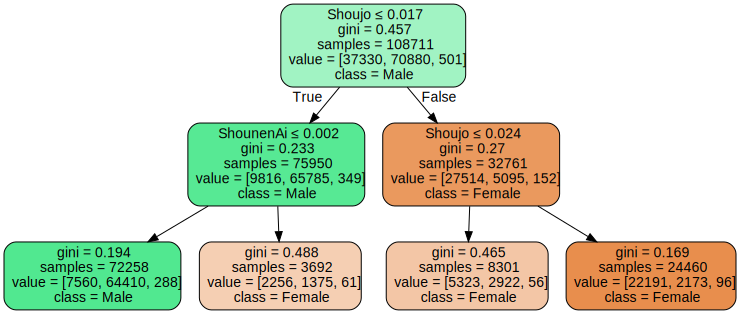

In [264]:
tree.export_graphviz(clf, out_file='gender_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_genders_completed['gender'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [267]:
tree_to_table(clf)

age probability
Shoujo <= 1.7% ShounenAi <= 0.2%    Male      89.14%
               ShounenAi > 0.2%   Female      61.11%
Shoujo > 1.7%  Shoujo <= 2.4%     Female      64.12%
               Shoujo > 2.4%      Female      90.72%

In [270]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=1)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf)

             precision    recall  f1-score   support

     Female       0.84      0.74      0.79     37330
       Male       0.87      0.93      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.85      0.86      0.85    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


age probability
Shoujo <= 1.7%    Male      86.62%
Shoujo > 1.7%   Female      83.98%

In [271]:
# comparing precision depending on depth
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf)

             precision    recall  f1-score   support

     Female       0.82      0.80      0.81     37330
       Male       0.89      0.91      0.90     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.86      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


age probability
Shoujo <= 1.7% ShounenAi <= 0.2%    Male      89.14%
               ShounenAi > 0.2%   Female      61.11%
Shoujo > 1.7%  Shoujo <= 2.4%     Female      64.12%
               Shoujo > 2.4%      Female      90.72%

In [272]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))
tree_to_table(clf)

             precision    recall  f1-score   support

     Female       0.88      0.72      0.79     37330
       Male       0.86      0.95      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.87      0.87      0.86    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


age probability
Shoujo <= 1.7% ShounenAi <= 0.2% Ecchi <= 0.1%        Male      66.31%
                                 Ecchi > 0.1%         Male      91.67%
                                 ShounenAi <= 0.4%    Male      55.90%
                                 ShounenAi > 0.4%   Female      70.91%
Shoujo > 1.7%  Shoujo > 2.4%     ShounenAi <= 0.1%    Male      50.28%
                                 ShounenAi > 0.1%   Female      84.28%
                                 Josei <= 0.2%      Female      84.53%
                                 Josei > 0.2%       Female      94.14%

In [63]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.85      0.78      0.81     37330
       Male       0.89      0.93      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.87      0.87      0.87    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [64]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.87      0.77      0.82     37330
       Male       0.88      0.94      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.87      0.88      0.87    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [65]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.87      0.77      0.82     37330
       Male       0.88      0.94      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.88      0.88      0.88    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [66]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.86      0.80      0.83     37330
       Male       0.90      0.93      0.91     70880
 Non-Binary       0.00      0.00      0.00       501

avg / total       0.88      0.88      0.88    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_genders_completed[completed_columns], users_genders_completed['gender'])
y_true = users_genders_completed['gender']
y_pred = clf.predict(users_genders_completed[completed_columns])
target_names = users_genders_completed['gender'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

     Female       0.86      0.82      0.84     37330
       Male       0.90      0.93      0.92     70880
 Non-Binary       1.00      0.00      0.00       501

avg / total       0.89      0.89      0.89    108711



In [94]:
# guessing age bin based on completed genres histogram
users_ages_completed[completed_columns] = users_ages_completed[completed_columns].fillna(0)
# first, trying some depths


In [95]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.31      0.36      0.34     25105
   (30, 40]       0.31      0.51      0.38     28370
   (23, 26]       0.36      0.43      0.39     26617
   (14, 17]       0.00      0.00      0.00     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.24      0.32      0.27    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [96]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.33      0.29      0.31     25105
   (30, 40]       0.30      0.65      0.41     28370
   (23, 26]       0.39      0.36      0.37     26617
   (14, 17]       0.00      0.00      0.00     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.25      0.33      0.27    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [97]:
clf = tree.DecisionTreeClassifier(max_depth=4)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.00      0.00      0.00     13097
   (20, 23]       0.33      0.52      0.40     25105
   (30, 40]       0.32      0.36      0.34     28370
   (23, 26]       0.38      0.43      0.41     26617
   (14, 17]       0.41      0.24      0.30     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.30      0.35      0.31    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [98]:
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.33      0.20      0.25     13097
   (20, 23]       0.35      0.34      0.34     25105
   (30, 40]       0.32      0.50      0.39     28370
   (23, 26]       0.41      0.41      0.41     26617
   (14, 17]       0.46      0.18      0.26     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.35      0.35      0.34    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [99]:
clf = tree.DecisionTreeClassifier(max_depth=6)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.38      0.09      0.14     13097
   (20, 23]       0.34      0.49      0.40     25105
   (30, 40]       0.33      0.38      0.35     28370
   (23, 26]       0.40      0.50      0.44     26617
   (14, 17]       0.50      0.15      0.23     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.36      0.36      0.33    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [100]:
clf = tree.DecisionTreeClassifier(max_depth=7)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.38      0.11      0.17     13097
   (20, 23]       0.34      0.53      0.42     25105
   (30, 40]       0.34      0.36      0.35     28370
   (23, 26]       0.40      0.49      0.44     26617
   (14, 17]       0.49      0.18      0.27     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.37      0.37      0.35    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [101]:
clf = tree.DecisionTreeClassifier(max_depth=8)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.33      0.00      0.00      3077
   (17, 20]       0.39      0.20      0.27     13097
   (20, 23]       0.36      0.48      0.41     25105
   (30, 40]       0.35      0.41      0.38     28370
   (23, 26]       0.42      0.48      0.45     26617
   (14, 17]       0.51      0.21      0.29     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.39      0.38      0.37    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [102]:
clf = tree.DecisionTreeClassifier(max_depth=9)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       1.00      0.00      0.00      3077
   (17, 20]       0.40      0.24      0.30     13097
   (20, 23]       0.38      0.46      0.42     25105
   (30, 40]       0.37      0.44      0.40     28370
   (23, 26]       0.44      0.50      0.47     26617
   (14, 17]       0.51      0.25      0.33     11555
   (40, 50]       0.50      0.00      0.01       616
    (9, 14]       1.00      0.01      0.02       274

avg / total       0.43      0.40      0.39    108711



In [103]:
# 5 depth seems like nice tradeoff based 
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(users_ages_completed[completed_columns], users_ages_completed['age_bin'])
y_true = users_ages_completed['age_bin']
y_pred = clf.predict(users_ages_completed[completed_columns])
target_names = users_ages_completed['age_bin'].unique()
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   (26, 30]       0.00      0.00      0.00      3077
   (17, 20]       0.33      0.20      0.25     13097
   (20, 23]       0.35      0.34      0.34     25105
   (30, 40]       0.32      0.50      0.39     28370
   (23, 26]       0.41      0.41      0.41     26617
   (14, 17]       0.46      0.18      0.26     11555
   (40, 50]       0.00      0.00      0.00       616
    (9, 14]       0.00      0.00      0.00       274

avg / total       0.35      0.35      0.34    108711



/home.others/eb/easybuild/software/scikit-learn/0.19.1-foss-2018a-Python-3.6.4/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


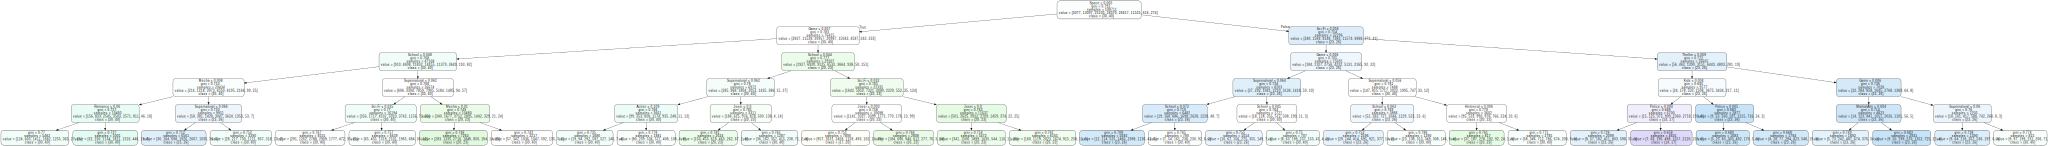

In [104]:
tree.export_graphviz(clf, out_file='age_classifier.dot',
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
dot_data = tree.export_graphviz(clf, out_file=None,
                         feature_names=[i.replace('completed_', '') for i in completed_columns],
                         class_names=users_ages_completed['age_bin'].unique(),
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [266]:
def tree_to_table(clf):
    n_nodes = clf.tree_.node_count
    children_left = clf.tree_.children_left
    children_right = clf.tree_.children_right
    feature = clf.tree_.feature
    threshold = clf.tree_.threshold
    value = clf.tree_.value
    max_depth = clf.tree_.max_depth

    fnames = [i.replace('completed_', '') for i in completed_columns]
    
    res = []
    for i in range(max_depth+1):
        res += list(product(range(2), repeat=i))
    res.sort()
    #display(res)

    targets = [target_names[np.argmax(v)] for v in value]

    levels = [[] for i in range(max_depth+1)]
    level_paths = [[] for i in range(max_depth+1)]
    classes = [[] for i in range(max_depth+1)]
    values = [[] for i in range(max_depth+1)]
    for i, path in enumerate(res):
        #print(i, len(path), feature[i], fnames[feature[i]])
        thr_percent = "{0:.1%}".format(threshold[i])
        levels[len(path)].append([fnames[feature[i]] + ' <= ' + thr_percent, fnames[feature[i]] + ' > ' + thr_percent])
        level_paths[len(path)].append([levels[len(path)][-1][-2]])
        level_paths[len(path)].append([levels[len(path)][-1][-1]])
        classes[len(path)].append(targets[i])
        values[len(path)].append(value[i])
        #print(level_paths[len(path)][-2], level_paths[len(path)][-1])
        #print(len(level_paths[len(path)]), 2 ** len(path))
        if len(path) > 0:
            prev_paths = level_paths[len(path) - 1]
            if len(level_paths[len(path)]) <= 2 ** len(path):
                #print('<')
                parent = prev_paths[-2]
            else:
                #print('>')
                parent = prev_paths[-1]
            level_paths[len(path)][-2] = parent + level_paths[len(path)][-2]
            level_paths[len(path)][-1] = parent + level_paths[len(path)][-1]
            #print(level_paths[len(path)][-2], level_paths[len(path)][-1])
    #levels = levels[:-1]
    paths = level_paths[-2]
    indices = pd.MultiIndex.from_tuples(paths)
    distr = np.array(values[-1])
    df = pd.DataFrame({'age': classes[-1], 'probability': (distr.max(axis=2) / distr.sum(axis=2))[:,0]}, index=indices)
    df['probability'] = df['probability'].apply(lambda x: "{0:.2f}%".format(x * 100))
    return df

In [262]:
tree_to_table(clf)

age  \
Space <= 0.5% Game <= 0.7%  School <= 4.8%  Mecha <= 0.8%        Romance <= 6.0%       (30, 40]   
                                                                 Romance > 6.0%        (30, 40]   
                                                                 Supernatural <= 6.6%  (23, 26]   
                                                                 Supernatural > 6.6%   (30, 40]   
                                            Supernatural <= 6.2% Sci-Fi <= 3.5%        (30, 40]   
                                                                 Sci-Fi > 3.5%         (30, 40]   
                                                                 Mecha <= 1.0%         (20, 23]   
                                                                 Mecha > 1.0%          (30, 40]   
                            School <= 4.4%  Supernatural <= 6.2% Action <= 10.9%       (30, 40]   
                                                                 Action > 10.9%        (30, 40]   
                                                                 Josei <= 0.0%         (20, 23]   
                                                                 Josei > 0.0%          (30, 40]   
                                            Sci-Fi <= 3.2%       Josei <= 0.3%         (17, 20]   
                                                                 Josei > 0.3%          (20, 23]   
                                                                 Josei <= 0.0%         (20, 23]   
                                                                 Josei > 0.0%          (20, 23]   
Space > 0.5%  Sci-Fi > 5.6% Game > 0.6%     Supernatural > 6.4%  School <= 7.2%        (23, 26]   
                                                                 School > 7.2%         (30, 40]   
                                                                 School <= 4.5%        (23, 26]   
                                                                 School > 4.5%         (30, 40]   
                                            Supernatural > 5.6%  School <= 6.3%        (23, 26]   
                                                                 School > 6.3%         (30, 40]   
                                                                 Historical <= 0.6%    (20, 23]   
                                                                 Historical > 0.6%     (30, 40]   
                            Thriller > 0.9% Kids > 0.4%          Police <= 0.4%        (23, 26]   
                                                                 Police > 0.4%         (14, 17]   
                                                                 Police <= 0.5%        (23, 26]   
                                                                 Police > 0.5%         (23, 26]   
                                            Game > 0.6%          MartialArts <= 0.4%   (23, 26]   
                                                                 MartialArts > 0.4%    (23, 26]   
                                                                 Supernatural <= 6.0%  (23, 26]   
                                                                 Supernatural > 6.0%   (30, 40]   

                                                                                       probability  
Space <= 0.5% Game <= 0.7%  School <= 4.8%  Mecha <= 0.8%        Romance <= 6.0%          0.306822  
                                                                 Romance > 6.0%           0.364127  
                                                                 Supernatural <= 6.6%     0.406493  
                                                                 Supernatural > 6.6%      0.330678  
                                            Supernatural <= 6.2% Sci-Fi <= 3.5%           0.304448  
                                                                 Sci-Fi > 3.5%            0.316463  
                                                                 Mecha <= 1.0%            0.373950  
                

age  \
Space <= 0.5% Game <= 0.7%  School <= 4.8%  Mecha <= 0.8%        Romance <= 6.0%       (30, 40]   
                                                                 Romance > 6.0%        (30, 40]   
                                                                 Supernatural <= 6.6%  (23, 26]   
                                                                 Supernatural > 6.6%   (30, 40]   
                                            Supernatural <= 6.2% Sci-Fi <= 3.5%        (30, 40]   
                                                                 Sci-Fi > 3.5%         (30, 40]   
                                                                 Mecha <= 1.0%         (20, 23]   
                                                                 Mecha > 1.0%          (30, 40]   
                            School <= 4.4%  Supernatural <= 6.2% Action <= 10.9%       (30, 40]   
                                                                 Action > 10.9%        (30, 40]   
                                                                 Josei <= 0.0%         (20, 23]   
                                                                 Josei > 0.0%          (30, 40]   
                                            Sci-Fi <= 3.2%       Josei <= 0.3%         (17, 20]   
                                                                 Josei > 0.3%          (20, 23]   
                                                                 Josei <= 0.0%         (20, 23]   
                                                                 Josei > 0.0%          (20, 23]   
Space > 0.5%  Sci-Fi > 5.6% Game > 0.6%     Supernatural > 6.4%  School <= 7.2%        (23, 26]   
                                                                 School > 7.2%         (30, 40]   
                                                                 School <= 4.5%        (23, 26]   
                                                                 School > 4.5%         (30, 40]   
                                            Supernatural > 5.6%  School <= 6.3%        (23, 26]   
                                                                 School > 6.3%         (30, 40]   
                                                                 Historical <= 0.6%    (20, 23]   
                                                                 Historical > 0.6%     (30, 40]   
                            Thriller > 0.9% Kids > 0.4%          Police <= 0.4%        (23, 26]   
                                                                 Police > 0.4%         (14, 17]   
                                                                 Police <= 0.5%        (23, 26]   
                                                                 Police > 0.5%         (23, 26]   
                                            Game > 0.6%          MartialArts <= 0.4%   (23, 26]   
                                                                 MartialArts > 0.4%    (23, 26]   
                                                                 Supernatural <= 6.0%  (23, 26]   
                                                                 Supernatural > 6.0%   (30, 40]   

                                                                                       probability  
Space <= 0.5% Game <= 0.7%  School <= 4.8%  Mecha <= 0.8%        Romance <= 6.0%          0.306822  
                                                                 Romance > 6.0%           0.364127  
                                                                 Supernatural <= 6.6%     0.406493  
                                                                 Supernatural > 6.6%      0.330678  
                                            Supernatural <= 6.2% Sci-Fi <= 3.5%           0.304448  
                                                                 Sci-Fi > 3.5%            0.316463  
                                                                 Mecha <= 1.0%            0.373950  
                

array([0.30682233, 0.36412717, 0.40649291, 0.33067847, 0.30444793,
       0.31646332, 0.37395016, 0.3254585 , 0.35535714, 0.29126704,
       0.30583004, 0.32245532, 0.33346008, 0.33475783, 0.34703947,
       0.32814274, 0.42129304, 0.30126582, 0.35009862, 0.33521924,
       0.35477658, 0.27054264, 0.34026928, 0.28222621, 0.38256313,
       0.4607694 , 0.45429363, 0.45875139, 0.35623679, 0.46127602,
       0.38561151, 0.28343558])

In [253]:
distr.shape

(32, 1, 8)